# ЗАДАЧА ДЛЯ САМОСТОЯТЕЛЬНОГО ПРОЕКТА

Представьте, что вы работаете в государственной компании, предоставляющей анализ экономической ситуации в мире по заказу государства.

Перед вами стоит задача проанализировать ВВП африканской страны Гана. Для этого вам предоставили показатели ВВП Ганы за 62 года. Вам предстоит исследовать временной ряд, изучить его свойства, построить модели и сделать выводы по результатам.

1. Прочитайте исходный файл с данными. Визуализируйте исходный временной ряд, сделайте первичные выводы о присутствии компонент тренда и сезонности в ряде.

Отложите последние три года из датасета как тестовую выборку для оценки результатов предсказания.

In [289]:
#читаем данные

import pandas as pd

data = pd.read_csv("data/ghana_gdp.zip",parse_dates=["year"], index_col=["year"])
data.head()

,GDP (current US$)
year,
1960-01-01,1.217087e+09
1961-01-01,0.000000e+00
1962-01-01,1.382353e+09
1963-01-01,1.540616e+09
1964-01-01,1.731092e+09


<AxesSubplot: xlabel='year'>

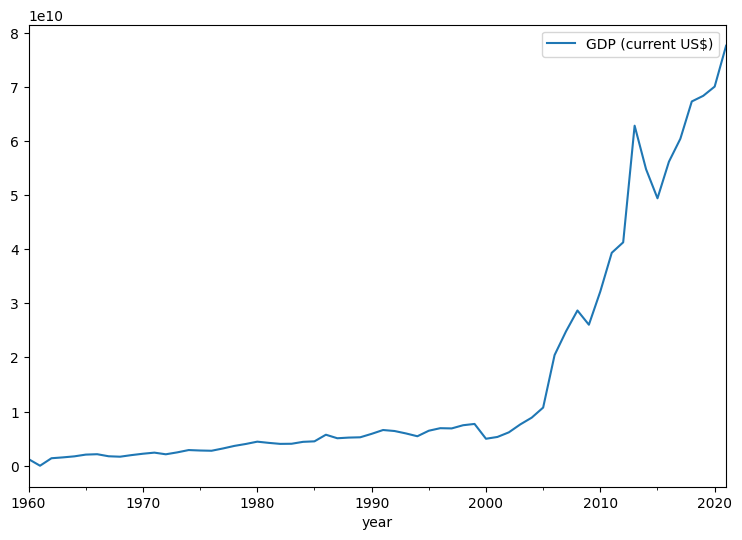

In [290]:
%matplotlib inline
import matplotlib.pyplot as plt

data.plot(figsize=(9,6))

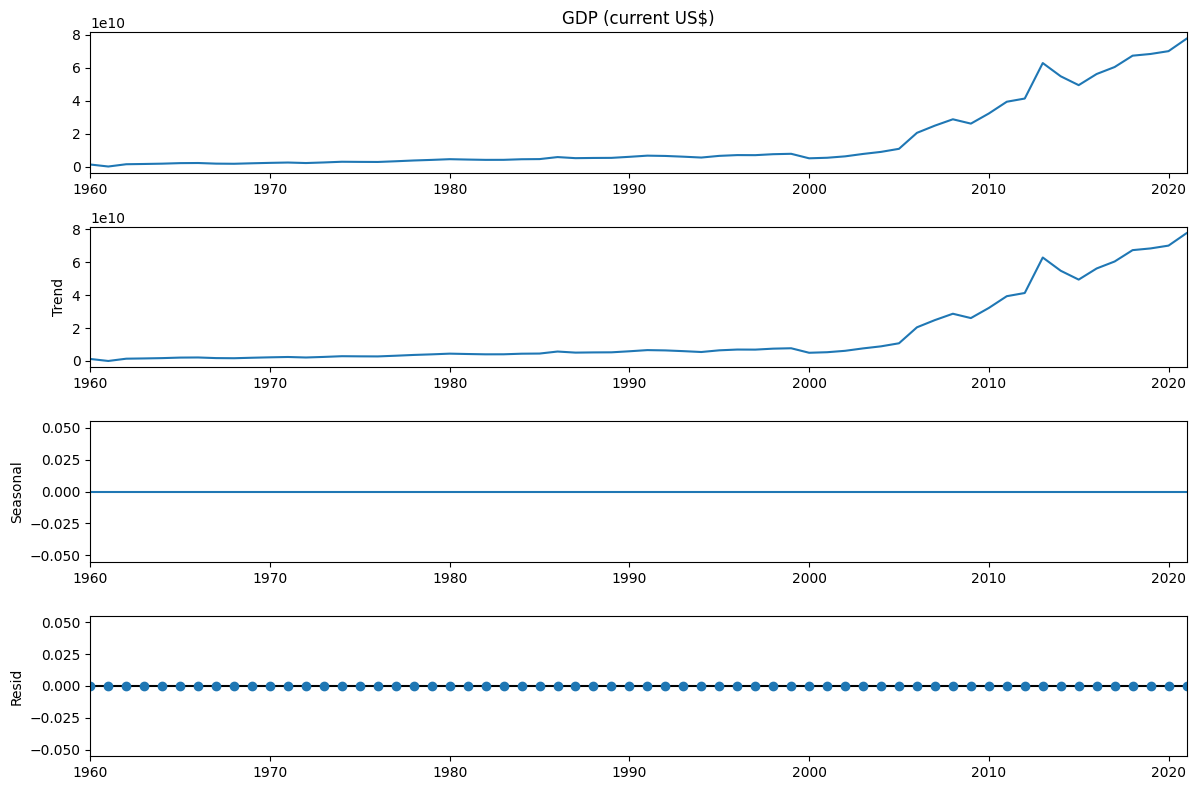

In [291]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(data['GDP (current US$)'])

plt.rcParams["figure.figsize"] = 12, 8
result.plot()
plt.show()

In [292]:
# откладываем train и test
train_df = data.iloc[:-3]
test_df = data.iloc[-3:]
train_df.shape, test_df.shape

((59, 1), (3, 1))

## Выводы:
Сезонной и шумовой компоненты не выявлено. Все данные `seasonal_decompose` отнёс к тренду, который показывает тенденцию к росту c cсередины 2000-х годов

2. Постройте график скользящего среднего, проанализируйте результат. Для построения MA используйте метод `rolling()`, который принимает в качестве параметра размер окна. Используйте среднее как функцию для сглаживания. Ширину окна подберите самостоятельно.

Визуализируйте исходный временной ряд и построенный с помощью скользящего среднего прогноз, сравните графики между собой и сделайте выводы.

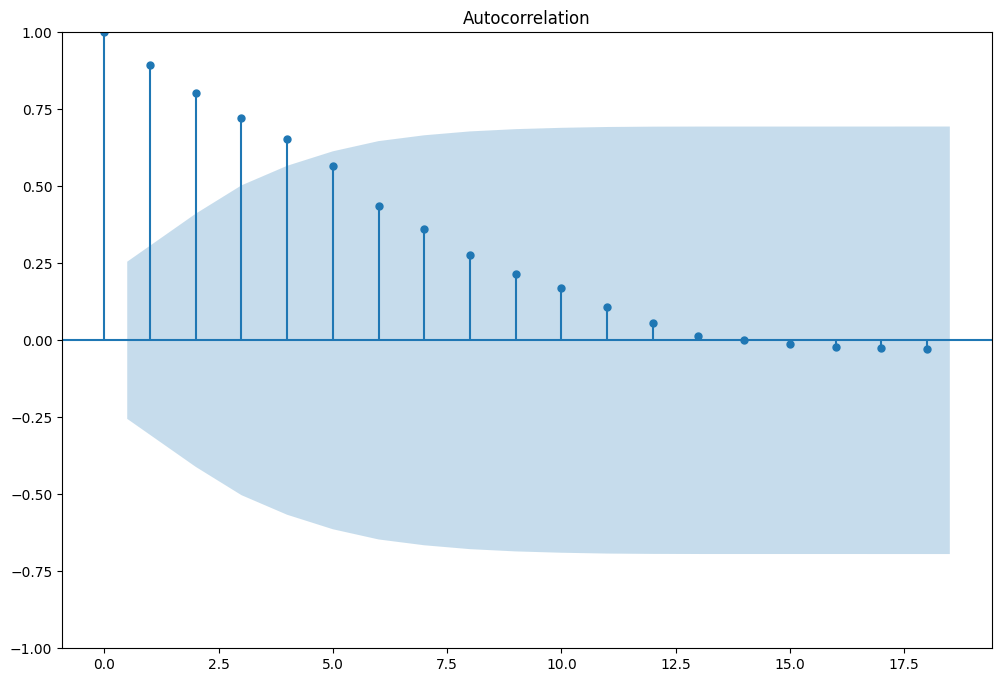

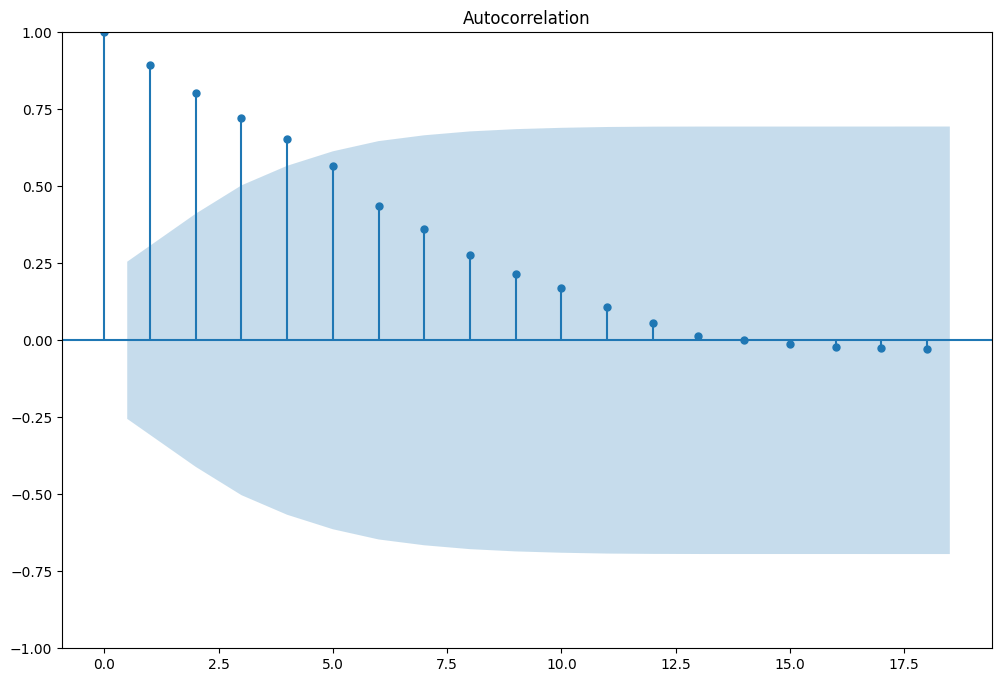

In [293]:
#Параметр q для скользящего среднего определяют по коррелограмме (графику автокорреляции).
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(train_df['GDP (current US$)'])
# Максимальное значение соответстветвует k=1, т.е. ряд содержит только тенденцию (тренд). Ближайшие крупные k: 2, 3, 4

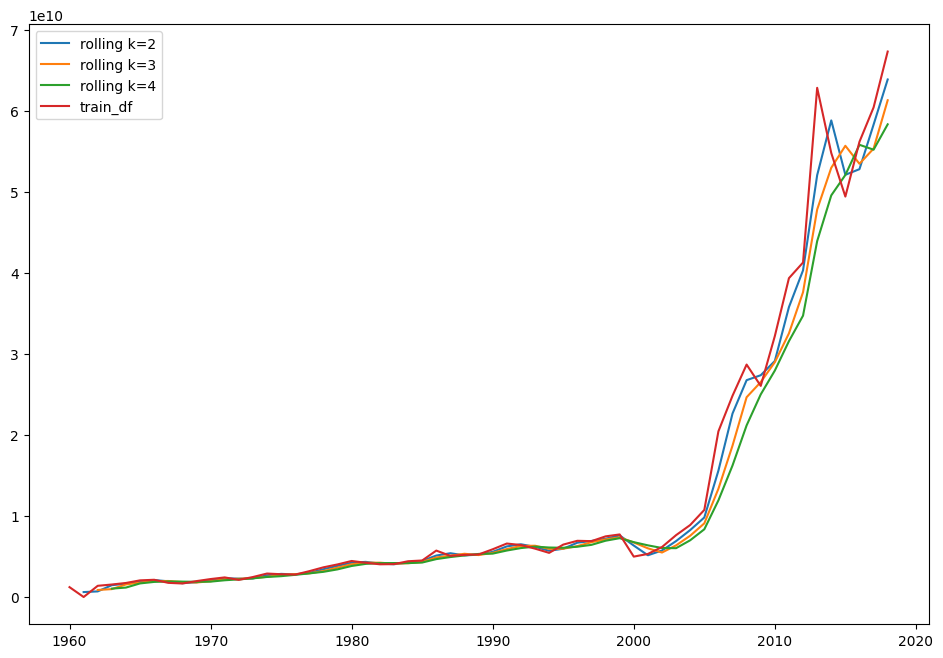

In [294]:
#построим все варианты

fig = plt.figure(figsize=(9, 6))
axes = fig.add_axes([0, 0, 1, 1])

for i in [2, 3, 4]:
    axes.plot(train_df['GDP (current US$)'].rolling(window=i).mean(), label=f'rolling k={i}')  

axes.plot(train_df, label='train_df')
axes.legend();

## Выводы:
При построении скользящих средних с различными размерами окон (k=2, k=3, k=4) достигается определённая степень сглаживания, но т.к. сезонной компоненты нет, то этот факт слабо помогает дальнейшему прогнозированию. Тренд графика виден и без сглаживания.

3. С помощью теста Дики-Фуллера оцените стационарность временного ряда и примите решение о выборе модели ARMA/ARIMA.

**Примечание. Если ваш ряд является нестационарным, дифференцируйте его до тех пор, пока он не станет таковым. Количество дифференцирований, необходимых для сведения ряда к стационарному, будет вашим параметром d для модели ARIMA.**

Параметры p и q выберите по коррелограммам ACF и PACF.

**Примечание. Помните, что параметры p и q для ARMA/ARIMA определяются из коррелограмм стационарного ряда. То есть, если ваш изначальный временной ряд не являлся стационарным, то коррелограммы строятся для разностей того порядка, которые являются стационарными.**

Постройте модель ARMA/ARIMA для прогнозирования поведения временного ряда.

Также постройте несколько моделей с параметрами, ближайшими к найденным p и q, и сравните коэффициент AIC (или подберите наилучшие параметры с помощью пакета `pmdarima`, как в скринкасте).

In [295]:
# проверка на стационарность
from statsmodels.tsa.stattools import adfuller

def stat_test(df):
    test = adfuller(df)
    print ('adf: ', test[0] )
    print ('p-value: ', test[1])
    print('Critical values: ', test[4])
    if test[0]> test[4]['5%']: 
        print ('есть единичные корни, ряд не стационарен')
    else:
        print ('единичных корней нет, ряд стационарен')

stat_test(train_df['GDP (current US$)'])
    

# После первого теста
#adf:  0.6529066974885377
#p-value:  0.9888496277665573
#Critical values:  {'1%': -3.5745892596209488, '5%': -2.9239543084490744, '10%': -2.6000391840277777}
#есть единичные корни, ряд не стационарен

#напишем функцию для определения d значения

def search_d(df, start_d=1, end_d=4):
    d=start_d
    while d < end_d+1:
        otg_i_diff = df.diff(periods=d).dropna()
        test = adfuller(otg_i_diff)
        if test[0]>test[4]['5%']:
            d+=1
        else:
            break
    return f'Значение d, при котором ряд стационарен - d={d}'

search_d(train_df['GDP (current US$)'])

#'Значение d, при котором ряд стационарен - d=2'


adf:  0.6529066974885377
p-value:  0.9888496277665573
Critical values:  {'1%': -3.5745892596209488, '5%': -2.9239543084490744, '10%': -2.6000391840277777}
есть единичные корни, ряд не стационарен


'Значение d, при котором ряд стационарен - d=2'

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


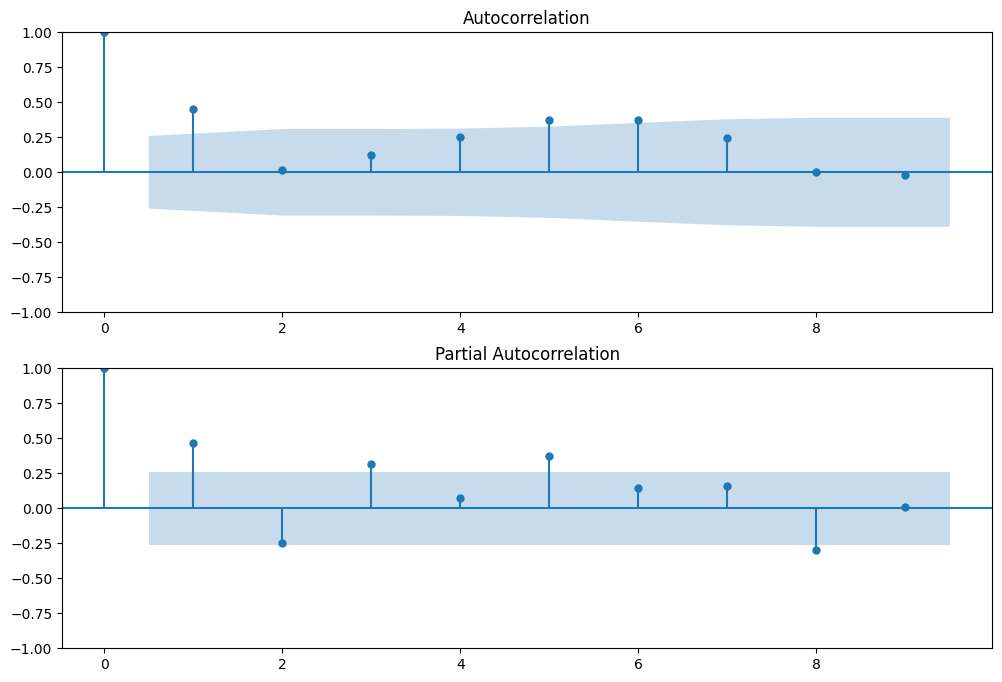

In [296]:
# Определяем параметры p и q выберите по коррелограммам ACF и PACF для стационарного ряда.
from statsmodels.graphics.tsaplots import plot_pacf


otg_2_diff = train_df.diff(periods=2).dropna()
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(otg_2_diff.values.squeeze(), lags=9, ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(otg_2_diff, lags=9, ax=ax2)

#исходя из графиков оптимально использовать значение q=1 (по графику автокорреляции) и значение p=5 (по графику частичной автокорреляции)

In [297]:
#Постройте модель ARMA/ARIMA для прогнозирования поведения временного ряда.
#Используем ARIMA, т.к. используем дифференцирование для получения стационарного ряда
#ARIMA
from statsmodels.tsa.arima.model import ARIMA

arima_model = ARIMA(train_df['GDP (current US$)'].dropna(), order=(5, 2, 1))
arima_model_fit = arima_model.fit()
arima_model_fit.summary()

#Критерий Акаике (AIC) - 2677.512

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting au

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:      GDP (current US$)   No. Observations:                   59
Model:                 ARIMA(5, 2, 1)   Log Likelihood               -1331.756
Date:                Mon, 25 Sep 2023   AIC                           2677.512
Time:                        14:24:48   BIC                           2691.813
Sample:                    01-01-1960   HQIC                          2683.070
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7719      0.374     -2.066      0.039      -1.504      -0.040
ar.L2         -0.7874      0.359     -2.192      0.028      -1.492      -0.083
ar.L3         -0.6264      0.387     -1.617      0.106      -1.385       0.133
ar.L4         -0.7573      0.314     -2.415      0.016      -1.372      -0.143
ar.L5         -0.3846      0.356     -1.079      0.281      -1.083       0.314
ma.L1         -0.3606      0.386     -0.934      0.351      -1.118       0.396
sigma2      1.285e+19   1.26e-20   1.02e+39      0.000    1.28e+19    1.28e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.16   Jarque-Bera (JB):               203.11
Prob(Q):                              0.69   Prob(JB):                         0.00
Heteroskedasticity (H):             175.02   Skew:                             1.89
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.44
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.15e+54. Standard errors may be unstable.
"""

In [298]:
#Также постройте несколько моделей с параметрами, ближайшими к найденным p и q, и сравните коэффициент AIC (или подберите наилучшие параметры с помощью пакета `pmdarima`, как в скринкасте).

import pmdarima as pm

smodel = pm.auto_arima(
    train_df['GDP (current US$)'],
    start_p=1,
    #d=1,
    start_q=1,
    max_p=6,
    max_d=3,
    max_q=2,
    D=1,
    #start_P=0,
    test="adf",
    error_action="ignore",
    trace=True,
)

smodel.summary()

#Критерий Акаике (AIC) - 2728.025


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2732.043, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2728.025, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2729.982, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2730.117, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2730.972, Time=0.03 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.327 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   59
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -1362.013
Date:                Mon, 25 Sep 2023   AIC                           2728.025
Time:                        14:24:48   BIC                           2732.146
Sample:                    01-01-1960   HQIC                          2729.631
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1.139e+09   5.02e+08      2.270      0.023    1.56e+08    2.12e+09
sigma2      1.461e+19      0.176   8.28e+19      0.000    1.46e+19    1.46e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):               451.60
Prob(Q):                              0.82   Prob(JB):                         0.00
Heteroskedasticity (H):              34.65   Skew:                             2.69
Prob(H) (two-sided):                  0.00   Kurtosis:                        15.57
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number    inf. Standard errors may be unstable.
"""

4. Постройте модель с наилучшими параметрами и выполните предсказание для отложенной тестовой выборки (последние три года).

In [299]:
#используем параметры, полученные от собственных наблюдений order=(5, 2, 1), т.к. там AIC ниже, чем в auto_arima

pred_df = pd.DataFrame(index=data.index)

arima_model_best = ARIMA(train_df['GDP (current US$)'].dropna(), order=(5, 2, 1))
arima_model_best_fit = arima_model_best.fit()


pred_df["model_preds"] = arima_model_best_fit.predict(
    start=test_df.index[0], end=test_df.index[-1]
)


pred_df['GDP (current US$)'] = data['GDP (current US$)']

forecast = arima_model_best_fit.get_forecast(len(test_df.index))
forecast_df = forecast.conf_int(alpha=0.05)  # Confidence level of 95%

pred_df.at[test_df.index, "model_preds_lower"] = forecast_df["lower GDP (current US$)"]
pred_df.at[test_df.index, "model_preds_upper"] = forecast_df["upper GDP (current US$)"]

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting au

5. Отобразите результат графически — постройте графики истинного и предсказанного поведения временного ряда, а также 95%-ый доверительный интервал для прогноза.

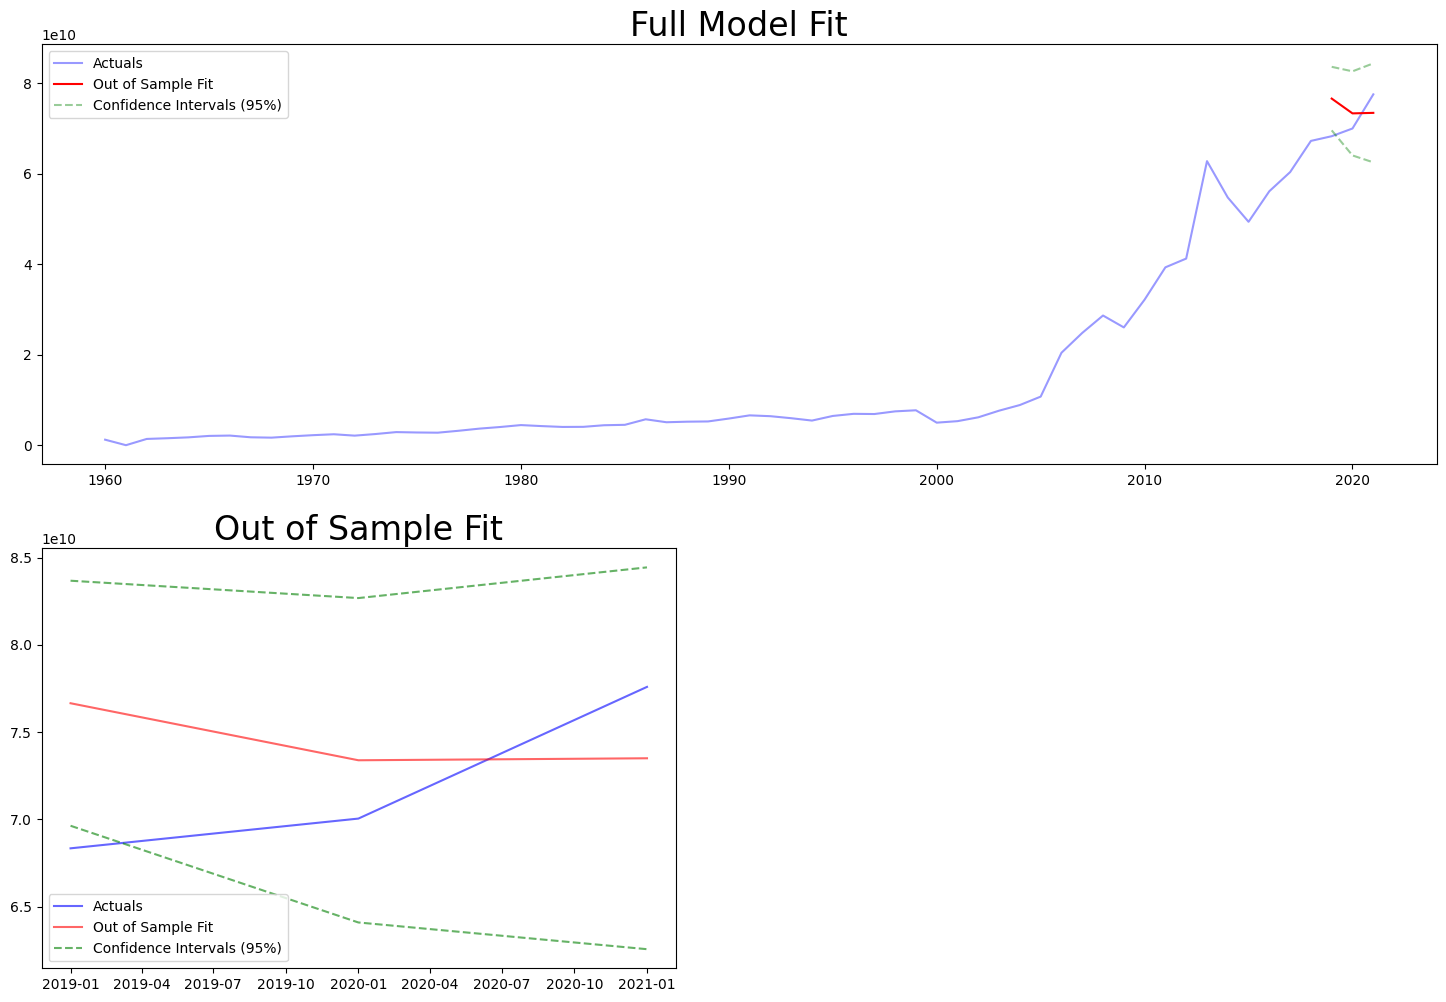

In [300]:
plt.rcParams["figure.figsize"] = 18, 12

plt.subplot(2, 1, 1)
plt.plot(pred_df["GDP (current US$)"], color="blue", label="Actuals", alpha=0.4)

plt.plot(
    pred_df.loc[test_df.index]["model_preds"],
    color="red",
    linestyle="-",
    label="Out of Sample Fit",
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_lower"],
    color="green",
    linestyle="--",
    label="Confidence Intervals (95%)",
    alpha=0.4,
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_upper"],
    color="green",
    linestyle="--",
    alpha=0.4,
)

plt.title("Full Model Fit", size=24)
plt.legend()

plt.subplot(2, 2, 3)

plt.plot(
    pred_df.loc[test_df.index]["GDP (current US$)"], color="blue", label="Actuals", alpha=0.6
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds"],
    color="red",
    linestyle="-",
    label="Out of Sample Fit",
    alpha=0.6,
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_lower"],
    color="green",
    linestyle="--",
    label="Confidence Intervals (95%)",
    alpha=0.6,
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_upper"],
    color="green",
    linestyle="--",
    alpha=0.6,
)

plt.title("Out of Sample Fit", size=24)
plt.legend()

plt.show()

In [301]:
#Посмотрим на MAPE-ошибку

from sklearn.metrics import mean_absolute_percentage_error

(mean_absolute_percentage_error(list(pred_df.loc[test_df.index]["GDP (current US$)"]), list(pred_df.loc[test_df.index]["model_preds"]))*100).round(2)

#7.41%

7.41

6. Сделайте выводы по полученным результатам.

## Выводы:
В целом модель хорошо предсказывает результат: она ошибается на 7,41% от истинного значения

## Интерполяция и сэмплирование

1. Проверьте данные на наличие пропущенных дат. Помимо визуального способа, это можно сделать с помощью метода `DataFrame.asfreq()`, передав в него параметр частоты, например ‘d’ — день, ‘m’ — месяц. Все алиасы для параметров частоты доступны по ссылке.
   
**Подсказка `df.asfreq(freq='AS')`**

In [302]:
data.asfreq(freq='AS') 
# размерность такая же как и исходных данных. пропусков в датах нет

,GDP (current US$)
year,
1960-01-01,1.217087e+09
1961-01-01,0.000000e+00
1962-01-01,1.382353e+09
1963-01-01,1.540616e+09
1964-01-01,1.731092e+09
...,...
2017-01-01,6.040638e+10
2018-01-01,6.729928e+10
2019-01-01,6.833754e+10


2. Проверьте данные на наличие пропущенных значений `(Series.isna().sum())`.

In [303]:
data['GDP (current US$)'].isna().sum()
# явных пропусков в данных тоже нет

0

3. Обратите внимание, что иногда пропуски в данных могут быть заполнены нулями. Сделайте проверку на наличие нулевых значений и в случае нахождения замените их на NaN. Воспользуйтесь кодом ниже:
   

```
import numpy as np
df['GDP (current US$)'] = df['GDP (current US$)'].apply(lambda x: np.nan if x==0 else x)
```

In [304]:
import numpy as np
data['GDP (current US$)'] = data['GDP (current US$)'].apply(lambda x: np.nan if x==0 else x)

4. Для заполнения пропусков выполните интерполяцию с использованием метода `.interpolate()`.
   
**Подсказка `df['GDP (current US$)'].interpolate(method='linear')`**

In [305]:
filled_data = data['GDP (current US$)'].interpolate(method='linear')

5. Проверьте полученный ряд на стационарность, определите параметры модели (ARIMA/ARMA) и запустите модель.

In [306]:
# откладываем train и test
train_df_filled = filled_data.iloc[:-3]
test_df_filled = filled_data.iloc[-3:]
train_df_filled.shape, test_df_filled.shape

((59,), (3,))

In [307]:
stat_test(train_df_filled)
#adf:  0.8030073326980093
#p-value:  0.9916845572455876
#Critical values:  {'1%': -3.5745892596209488, '5%': -2.9239543084490744, '10%': -2.6000391840277777}
#есть единичные корни, ряд не стационарен

adf:  0.8030073326980093
p-value:  0.9916845572455876
Critical values:  {'1%': -3.5745892596209488, '5%': -2.9239543084490744, '10%': -2.6000391840277777}
есть единичные корни, ряд не стационарен


In [308]:
search_d(train_df_filled)
#'Значение d, при котором ряд стационарен - d=2'

'Значение d, при котором ряд стационарен - d=2'

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


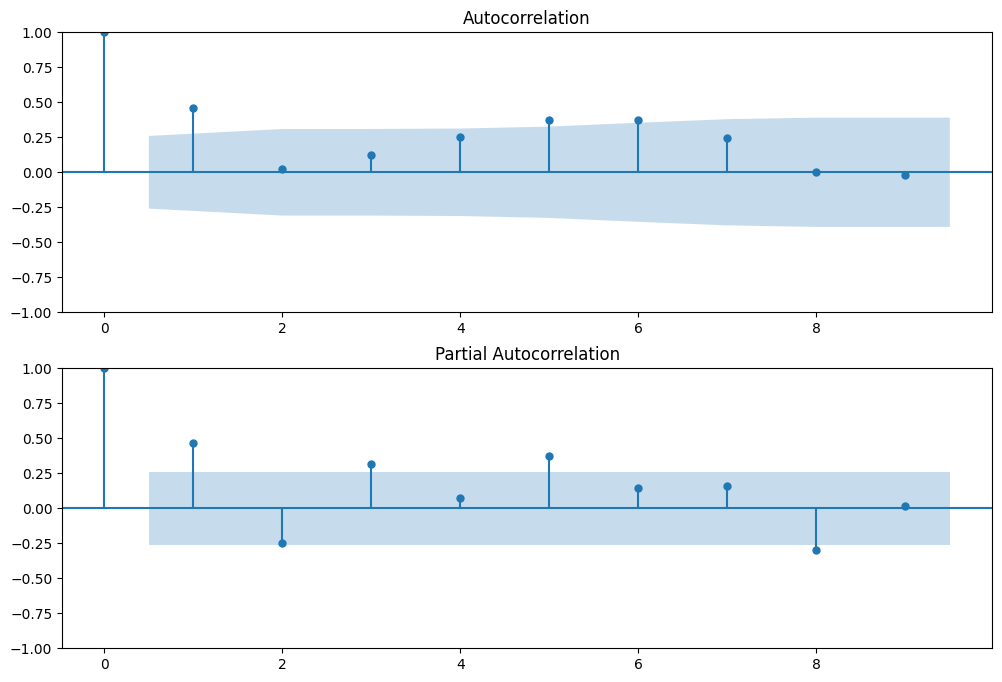

In [309]:
otg_2_diff_filled = train_df_filled.diff(periods=2).dropna()
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(otg_2_diff_filled.values.squeeze(), lags=9, ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(otg_2_diff_filled, lags=9, ax=ax2)

#исходя из графиков оптимально использовать значение q=1 (по графику автокорреляции) и значение p=5 (по графику частичной автокорреляции)

In [310]:
arima_model_filled = ARIMA(train_df_filled.dropna(), order=(5, 2, 1))
arima_model_fiiled_fit = arima_model.fit()
arima_model_fiiled_fit.summary()

#Критерий Акаике (AIC) - 2677.512

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting au

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:      GDP (current US$)   No. Observations:                   59
Model:                 ARIMA(5, 2, 1)   Log Likelihood               -1331.756
Date:                Mon, 25 Sep 2023   AIC                           2677.512
Time:                        14:24:53   BIC                           2691.813
Sample:                    01-01-1960   HQIC                          2683.070
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7719      0.374     -2.066      0.039      -1.504      -0.040
ar.L2         -0.7874      0.359     -2.192      0.028      -1.492      -0.083
ar.L3         -0.6264      0.387     -1.617      0.106      -1.385       0.133
ar.L4         -0.7573      0.314     -2.415      0.016      -1.372      -0.143
ar.L5         -0.3846      0.356     -1.079      0.281      -1.083       0.314
ma.L1         -0.3606      0.386     -0.934      0.351      -1.118       0.396
sigma2      1.285e+19   1.26e-20   1.02e+39      0.000    1.28e+19    1.28e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.16   Jarque-Bera (JB):               203.11
Prob(Q):                              0.69   Prob(JB):                         0.00
Heteroskedasticity (H):             175.02   Skew:                             1.89
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.44
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.15e+54. Standard errors may be unstable.
"""

6. Изменился ли AIC критерий построенной модели по сравнению с моделью на неинтерполированных данных? Сделайте вывод.

## Вывод:
Показатель критерия Акаики в построенной модели не изменился по сравнению с моделью неинтерполированных данных. Это связано с тем, что количество пропусков данных было не большим (всего за 1 год) и сами пропуски были в начале временного ряда (за 1961 год). Информация об указанных пропусках в блоке кода ниже.

In [311]:
nadata = data.isna()
nadata[nadata['GDP (current US$)']==True]

,GDP (current US$)
year,
1961-01-01,True


## Модели прогнозирования гетероскедастичности. Валидация временных рядов.

1. Посчитайте волатильность для вашего временного ряда.

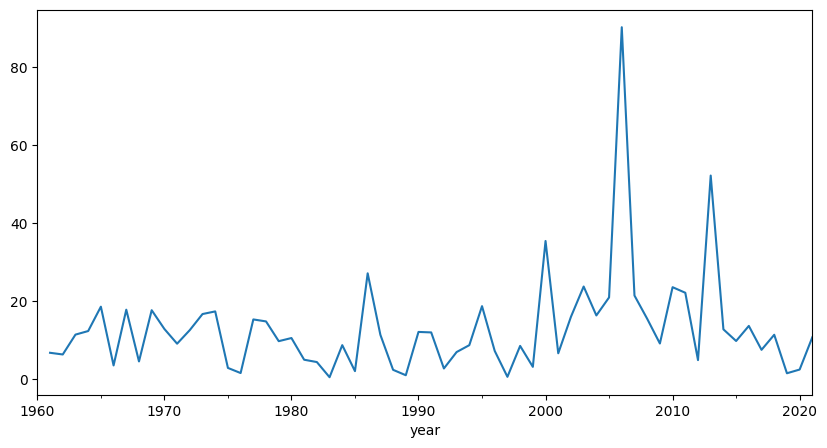

In [312]:
filled_data = pd.DataFrame(filled_data)

filled_data['vol'] = filled_data['GDP (current US$)'].pct_change(1).mul(100).abs()

plt.rcParams["figure.figsize"] = 10, 5
filled_data['vol'].plot()
plt.show()

2. Используйте GARCH-модель для предсказания волатильности.

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


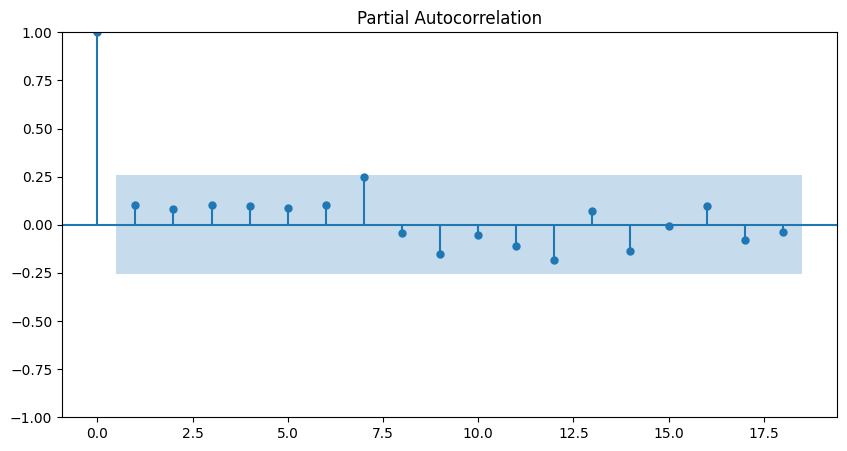

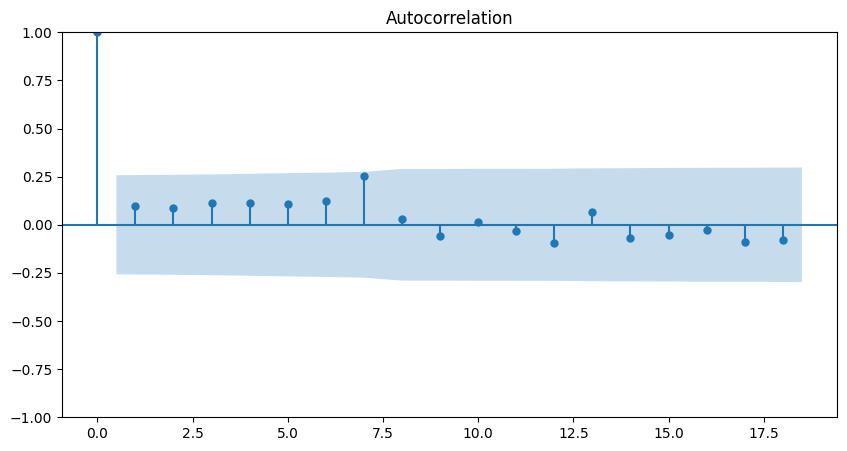

adf:  -6.725311059553778
p-value:  3.4014596148856493e-09
Critical values:  {'1%': -3.5506699942762414, '5%': -2.913766394626147, '10%': -2.5946240473991997}
единичных корней нет, ряд стационарен


In [313]:
# откладываем train и test
train_df = filled_data.iloc[:-3]
test_df = filled_data.iloc[-3:]


#смотрим PACF для волатильности
plt.rcParams["figure.figsize"] = 10, 5
plot_pacf(train_df['vol'].iloc[1:])
plt.show()
# максимальное значение - при p=7

#смотрим ACF для волатильности
plt.rcParams["figure.figsize"] = 10, 5
plot_acf(train_df['vol'].iloc[1:])
plt.show()
# максимальное значение - при q=0

#проверяем на стационарность
stat_test(train_df['vol'].iloc[1:])
#adf:  -6.725311059553778
#p-value:  3.4014596148856493e-09
#Critical values:  {'1%': -3.5506699942762414, '5%': -2.913766394626147, '10%': -2.5946240473991997}
#единичных корней нет, ряд стационарен

In [314]:
#нам важно сохранить объем датасета, поэтому берем за исходные данные весь датасет с индексами, который содержит
# и train и test часть
garch_df = pd.DataFrame(filled_data["vol"].loc[data.index])

# далее необходимо использовать актуальные обучающие данные, которые находятся в выборке train_df.
garch_df.loc[train_df.index, "vol"] = train_df["vol"].dropna()


from arch import arch_model

model = arch_model(garch_df["vol"].dropna(), vol='GARCH', p=7)

# в параметре last_obs указываем последний объект, до которого будем совершать обучение.
# в нашем случае это до первого объекта из test выборки

model_results = model.fit(last_obs=test_df.index[0])

Iteration:      1,   Func. Count:     12,   Neg. LLF: 227.07016993680574
Iteration:      2,   Func. Count:     23,   Neg. LLF: 225.47858193206244
Iteration:      3,   Func. Count:     37,   Neg. LLF: 307.3133574822944
Iteration:      4,   Func. Count:     52,   Neg. LLF: 233.80983133527477
Iteration:      5,   Func. Count:     64,   Neg. LLF: 227.55844185756527
Iteration:      6,   Func. Count:     76,   Neg. LLF: 257.0118372023218
Iteration:      7,   Func. Count:     88,   Neg. LLF: 216.12714141436794
Iteration:      8,   Func. Count:     99,   Neg. LLF: 214.63075633812784
Iteration:      9,   Func. Count:    110,   Neg. LLF: 216.0147873641528
Iteration:     10,   Func. Count:    122,   Neg. LLF: 214.28338052102296
Iteration:     11,   Func. Count:    133,   Neg. LLF: 213.9279616256299
Iteration:     12,   Func. Count:    144,   Neg. LLF: 213.7989161763082
Iteration:     13,   Func. Count:    155,   Neg. LLF: 213.66121533736973
Iteration:     14,   Func. Count:    166,   Neg. LLF: 21

In [315]:
model_results.summary()

#Критерий Акаике (AIC) - 447.101

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                    vol   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -213.551
Distribution:                  Normal   AIC:                           447.101
Method:            Maximum Likelihood   BIC:                           467.706
                                        No. Observations:                   58
Date:                Mon, Sep 25 2023   Df Residuals:                       57
Time:                        14:24:55   Df Model:                            1
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu            11.0952      0.833     13.322  1.730e-40 [  9.463, 12.728]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega         24.5309     15.324      1.601      0.109      [ -5.504, 54.566]
alpha[1]   1.1357e-09  4.702e-03  2.415e-07      1.000 [-9.216e-03,9.216e-03]
alpha[2]   1.7557e-10  1.594e-02  1.102e-08      1.000 [-3.123e-02,3.123e-02]
alpha[3]       0.3634      0.315      1.155      0.248      [ -0.253,  0.980]
alpha[4]   3.8344e-04      0.121  3.174e-03      0.997      [ -0.236,  0.237]
alpha[5]   1.2546e-11  7.455e-03  1.683e-09      1.000 [-1.461e-02,1.461e-02]
alpha[6]       0.5534      0.387      1.430      0.153      [ -0.205,  1.312]
alpha[7]       0.0829      0.229      0.362      0.717      [ -0.366,  0.531]
beta[1]    1.0826e-10      0.338  3.200e-10      1.000      [ -0.663,  0.663]
=============================================================================

Covariance estimator: robust
"""

In [316]:
predictions_df = test_df.copy()
predictions_df["Predictions"] = model_results.forecast().residual_variance.loc[
    test_df.index
]

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


3. Используйте линейную регрессию для получения прогноза.

In [317]:
from sklearn.linear_model import LinearRegression

X_train = pd.DataFrame(range(filled_data["vol"].shape[0]))[
    : train_df.shape[0]
].fillna(0)
X_test = pd.DataFrame(range(filled_data["vol"].shape[0]))[
    train_df.shape[0] :
].fillna(0)
y_train = train_df["vol"].fillna(0)
y_test = test_df["vol"].fillna(0)


lr = LinearRegression()
lr.fit(X_train, y_train)
lr_predict = lr.predict(X_test)

4. Визуализируйте полученное предсказание вместе с фактическим значением.

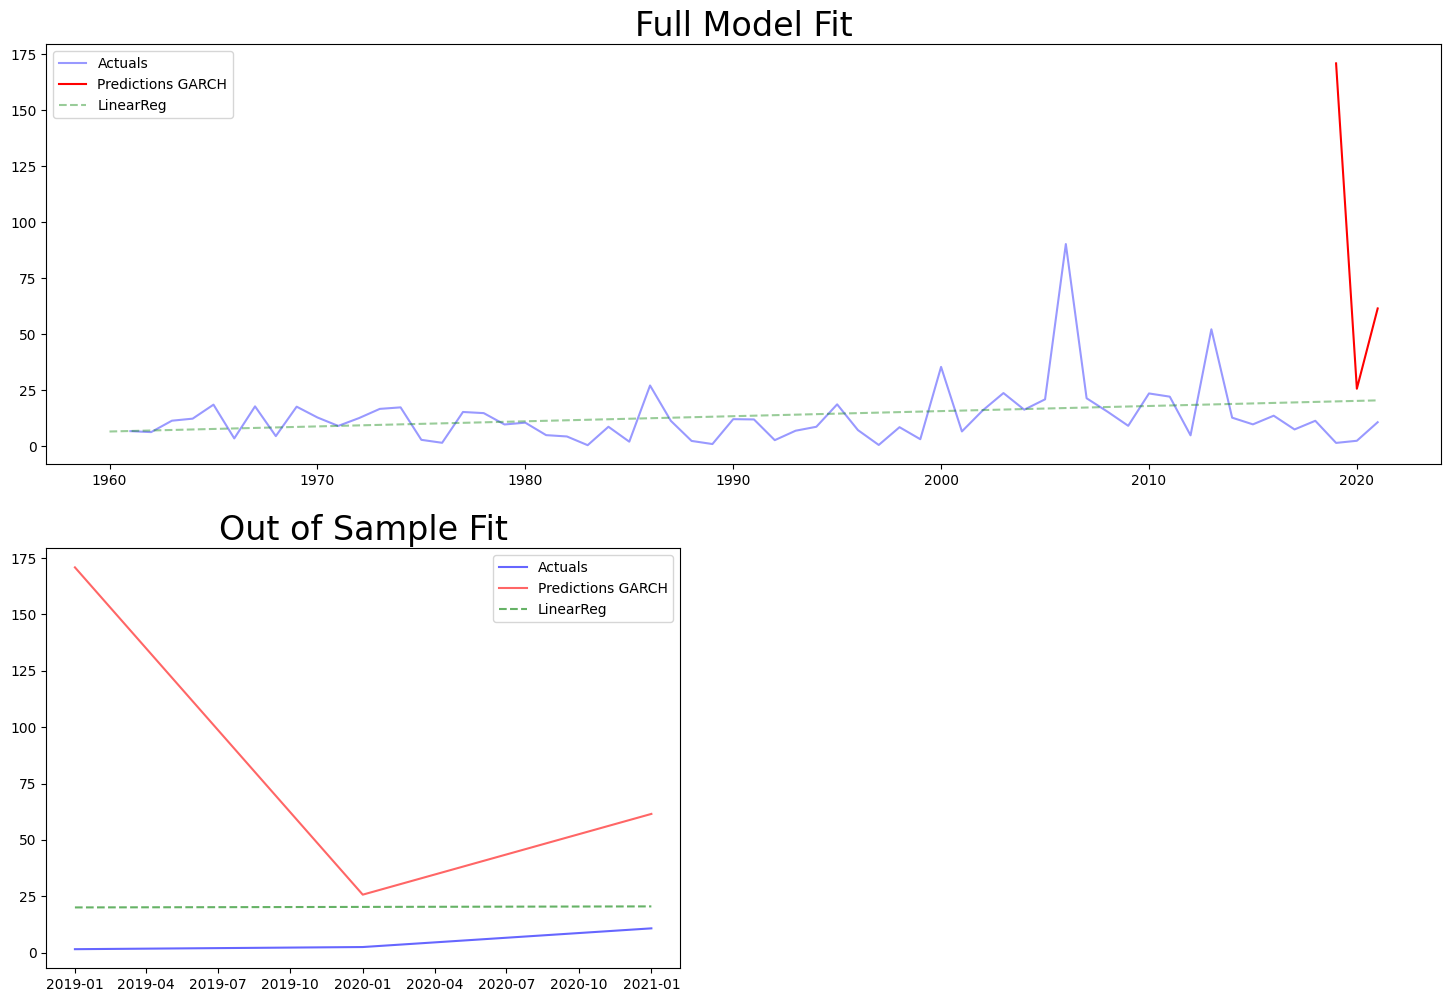

In [318]:
plt.rcParams["figure.figsize"] = 18, 12

plt.subplot(2, 1, 1)
plt.plot(filled_data["vol"], color="blue", label="Actuals", alpha=0.4)

plt.plot(
    predictions_df["Predictions"],
    color="red",
    linestyle="-",
    label="Predictions GARCH",
)

plt.plot(
    pd.Series(lr.predict(pd.DataFrame(range(filled_data["vol"].shape[0]))), index=filled_data.index),
    color="green",
    linestyle="--",
    label="LinearReg",
    alpha=0.4,
)

plt.title("Full Model Fit", size=24)
plt.legend()

plt.subplot(2, 2, 3)

plt.plot(
    filled_data.loc[test_df.index]["vol"], color="blue", label="Actuals", alpha=0.6
)

plt.plot(
    predictions_df.loc[test_df.index]["Predictions"],
    color="red",
    linestyle="-",
    label="Predictions GARCH",
    alpha=0.6,
)

plt.plot(
    pd.Series(lr_predict, index=y_test.index),
    color="green",
    linestyle="--",
    label="LinearReg",
    alpha=0.6,
)

plt.title("Out of Sample Fit", size=24)
plt.legend()

plt.show()

5. Сравните результаты и сделайте выводы.

## Выводы:
Модель GARCH хуже показала себя по сравнению с линейной регрессией, т.к. пиков изменения волатильности было мало (в середине 1980-х, в 2000, в середине 2000-х и в начале 2010-х). Таким образом гетероскедатичность была, но только в некоторые короткие периоды.

В остальные периоды волатильность изменялась в пределах определённого диапазона и линейная регрессия предсказала её намного лучше.

6. Почему результат модели GARCH получился именно таким?

Судя по полученному графику, модель не уловила дисперсию, так как такое поведение было для неё новым и подобные случаи были в небольшом количестве в обучающей выборке. 

В примере из скринкаста был противоположный результат, так как имелось больше данных и в обучающей выборке были случаи и возрастания, и убывания дисперсии, что удалось уловить модели.

Также в данных примера из скринкаста присутствовала циклическая компонента, что помогло модели учесть периоды изменения дисперсии. В данных для самостоятельной работы такого не было.

## Валидация данных

Следующее задание необходимо выполнить самостоятельно в Jupyter Notebook. Для этого вы можете использовать временной ряд из вашего проекта.

1. Разбейте временной ряд на три набора (3 train + 3 test). Для этого воспользуйтесь классом `TimeSeriesSplit` из `sklearn.model_selection` с параметрами `n_splits=3` и `test_size=7` (или `max_train_size=df.sales.count()-7`). Наборы данных можно получить, вызвав метод `split` (временной ряд) у инициализированного `TimeSeriesSplit`.

In [319]:
from sklearn.model_selection import TimeSeriesSplit 

tscv = TimeSeriesSplit(n_splits=3, test_size=7)

2. Выведите размеры полученных подвыборок:

In [320]:
train_test_groups = tscv.split(filled_data["vol"]) 
for train_index, test_index in train_test_groups:
    print("TRAIN size:", len(train_index), "TEST size:", len(test_index))
    
#TRAIN size: 41 TEST size: 7
#TRAIN size: 48 TEST size: 7
#TRAIN size: 55 TEST size: 7

TRAIN size: 41 TEST size: 7
TRAIN size: 48 TEST size: 7
TRAIN size: 55 TEST size: 7


Обратите внимание на отличие в размерах выборок на рисунке с walk forward validation и множественным разбиением. В задании вы вывели размеры полученных выборок. Какой случай вы получили?

**Множественное разбиение**

In [321]:
#Выполним валидацию моделей волатильности

#посчитаем для каждого сплита временного ряда, а затем усредним
#пишем функцию для валидации данных методом многожественного разбиения

#модели     
model1 = ARIMA(train_df['GDP (current US$)'].dropna(), order=(5, 2, 1))    
model2 = arch_model(garch_df["vol"].dropna(), vol='GARCH', p=7)
model3 =  LinearRegression()

def timeseries_validate(df, model, n_splits=5, test_size=3):
    
    #разбиваем
    tscv = TimeSeriesSplit(n_splits=n_splits, test_size=test_size)
    train_test_groups = tscv.split(df)
    
    #делаем лист для заполнения
    metrics_train_list = []
    metrics_test_list = []
     
   #прописываем свой порядок для каждой модели
    if model==model1:
        for train, test in train_test_groups:
            model_fit = model.fit()
            pred_df_test = model_fit.predict(start=df.iloc[test].index[0], end=df.iloc[test].index[-1])
            pred_df_train = model_fit.predict(start=df.iloc[train].index[0], end=df.iloc[train].index[-1])
            #добавляем метрики
            metrics_test_list.append((mean_absolute_percentage_error(list(df.iloc[test]), list(pred_df_test))*100).round(2))
            metrics_train_list.append((mean_absolute_percentage_error(list(df.iloc[train].fillna(0)), list(pred_df_train))*100).round(2))
            
    if model==model3:  
        for train, test in train_test_groups:  
            X_train = pd.DataFrame(range(df.shape[0]))[: test[0]]
            X_test = pd.DataFrame(range(df.shape[0]))[test[0] : test[-1]+1]
            y_train = df.iloc[train].fillna(0)
            y_test = df.iloc[test].fillna(0)
            model.fit(X_train, y_train)
            pred_df_test = model.predict(X_test)
            pred_df_train = model.predict(X_train)
            metrics_test_list.append((mean_absolute_percentage_error(list(df.iloc[test]), list(pred_df_test))*100).round(2))
            metrics_train_list.append((mean_absolute_percentage_error(list(df.iloc[train].fillna(0)), list(pred_df_train))*100).round(2))
        
    else:
        for train, test in train_test_groups:  
            model_garch = model.fit(last_obs=filled_data.index[test[0]])
            pred_df_test = model_garch.forecast().residual_variance.loc[filled_data.index[test]]
            pred_df_train = model_garch.forecast().residual_variance.loc[filled_data.index[train[1:]]]
            metrics_test_list.append((mean_absolute_percentage_error(list(df.iloc[test]), list(pred_df_test['h.1']))*100).round(2))
            metrics_train_list.append((mean_absolute_percentage_error(list(df.iloc[train[1:]].fillna(0)), list(pred_df_train['h.1'].fillna(0)))*100).round(2))
        
        
        #cчитаем и выводим результат
    return (np.array(metrics_train_list).mean().round(2), np.array(metrics_test_list).mean().round(2))
        

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


In [322]:
#Валидация для первой модели

model1_metrics = pd.DataFrame(columns=['train', 'test'], index=list(range(2,21)))
for i in list(range(2,21)):
    model1_metrics['train'][i] = timeseries_validate(df=filled_data["GDP (current US$)"], n_splits=i, model=model1)[0]
    model1_metrics['test'][i] = timeseries_validate(df=filled_data["GDP (current US$)"], n_splits=i, model=model1)[1]

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-

<AxesSubplot: title={'center': 'MAPE, %'}, xlabel='Number of splits'>

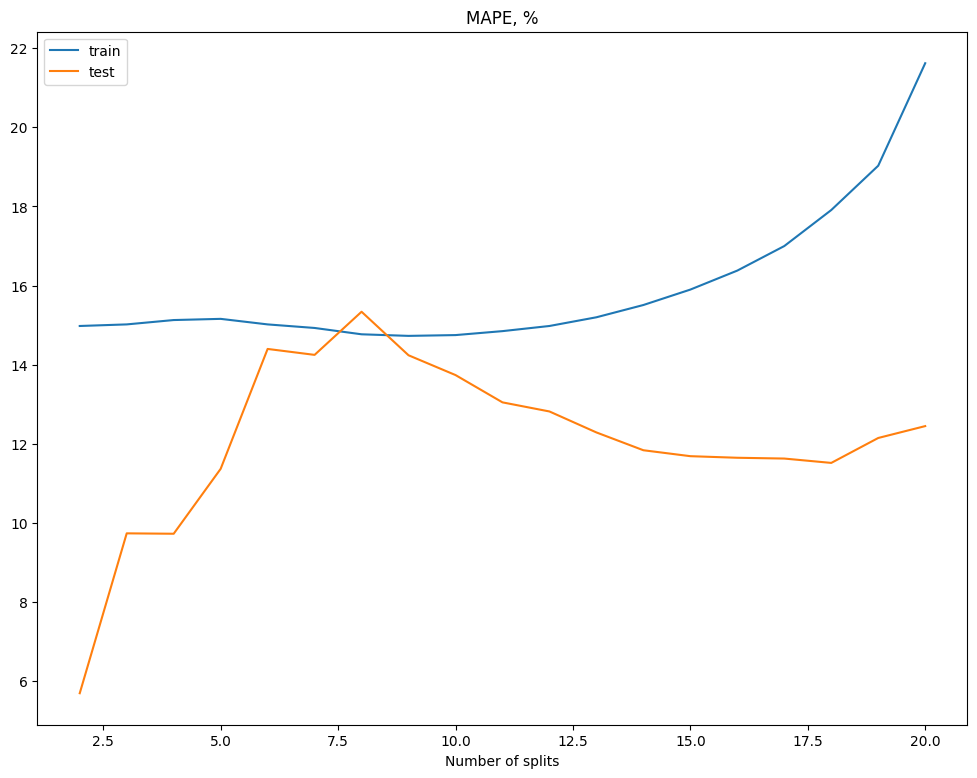

In [323]:
#визуализируем
model1_metrics.plot(figsize=(12,9), title="MAPE, %", xlabel='Number of splits')

### Вывод:
В зависимости от количества сплитов значение MAPE при прогнозированиии ВВП Ганы на тестовых данных будет находиться в пределах от 5 до 16%, т.е. модель в среднем ошибается на указанное значение процентов от истинного значения.

In [324]:
# Валидация второй модели (GARCH)

model2_metrics = pd.DataFrame(columns=['train', 'test'], index=list(range(5,21)))
for i in list(range(5,21)):
    model2_metrics['train'][i] = timeseries_validate(df=filled_data["vol"], n_splits=i, model=model2)[0]
    model2_metrics['test'][i] = timeseries_validate(df=filled_data["vol"], n_splits=i, model=model2)[1]


Iteration:      1,   Func. Count:     12,   Neg. LLF: 175.86592601973803
Iteration:      2,   Func. Count:     23,   Neg. LLF: 167.60533921376938
Iteration:      3,   Func. Count:     34,   Neg. LLF: 171.20378794797156
Iteration:      4,   Func. Count:     46,   Neg. LLF: 166.31722124056367
Iteration:      5,   Func. Count:     57,   Neg. LLF: 166.18129294952962
Iteration:      6,   Func. Count:     68,   Neg. LLF: 166.16321318079795
Iteration:      7,   Func. Count:     79,   Neg. LLF: 166.12825083119012
Iteration:      8,   Func. Count:     90,   Neg. LLF: 166.11308585095878
Iteration:      9,   Func. Count:    101,   Neg. LLF: 166.09237917600277
Iteration:     10,   Func. Count:    112,   Neg. LLF: 166.0599822658906
Iteration:     11,   Func. Count:    123,   Neg. LLF: 166.0079180373166
Iteration:     12,   Func. Count:    134,   Neg. LLF: 165.95750032422933
Iteration:     13,   Func. Count:    145,   Neg. LLF: 165.93334240479246
Iteration:     14,   Func. Count:    156,   Neg. LLF:

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex

Iteration:      1,   Func. Count:     12,   Neg. LLF: 200.05530918969163
Iteration:      2,   Func. Count:     23,   Neg. LLF: 205.5623249129804
Iteration:      3,   Func. Count:     35,   Neg. LLF: 199.02536842674502
Iteration:      4,   Func. Count:     47,   Neg. LLF: 212.40465658416701
Iteration:      5,   Func. Count:     60,   Neg. LLF: 193.6752429087788
Iteration:      6,   Func. Count:     71,   Neg. LLF: 193.66364607991855
Iteration:      7,   Func. Count:     82,   Neg. LLF: 193.62240634730904
Iteration:      8,   Func. Count:     93,   Neg. LLF: 193.51064457367886
Iteration:      9,   Func. Count:    104,   Neg. LLF: 193.10209926475852
Iteration:     10,   Func. Count:    115,   Neg. LLF: 192.5829126570431
Iteration:     11,   Func. Count:    126,   Neg. LLF: 192.38801702383884
Iteration:     12,   Func. Count:    137,   Neg. LLF: 192.18540749789867
Iteration:     13,   Func. Count:    148,   Neg. LLF: 192.14297304784898
Iteration:     14,   Func. Count:    159,   Neg. LLF: 

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


Iteration:      2,   Func. Count:     24,   Neg. LLF: 220.1699075227627
Iteration:      3,   Func. Count:     38,   Neg. LLF: 239.43853168545326
Iteration:      4,   Func. Count:     50,   Neg. LLF: 218.55044806443607
Iteration:      5,   Func. Count:     62,   Neg. LLF: 206.50291819898393
Iteration:      6,   Func. Count:     73,   Neg. LLF: 206.26165277075185
Iteration:      7,   Func. Count:     84,   Neg. LLF: 205.89038476362737
Iteration:      8,   Func. Count:     95,   Neg. LLF: 210.70840533711814
Iteration:      9,   Func. Count:    107,   Neg. LLF: 209.93741051153046
Iteration:     10,   Func. Count:    119,   Neg. LLF: 214.05342141232458
Iteration:     11,   Func. Count:    131,   Neg. LLF: 209.08844050295522
Iteration:     12,   Func. Count:    143,   Neg. LLF: 215.78940978124876
Iteration:     13,   Func. Count:    155,   Neg. LLF: 208.30024187832424
Iteration:     14,   Func. Count:    167,   Neg. LLF: 204.61389649185494
Iteration:     15,   Func. Count:    178,   Neg. LLF

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


Iteration:     20,   Func. Count:    232,   Neg. LLF: 213.5726263463793
Iteration:     21,   Func. Count:    243,   Neg. LLF: 213.56567063770052
Iteration:     22,   Func. Count:    254,   Neg. LLF: 213.5571168067668
Iteration:     23,   Func. Count:    265,   Neg. LLF: 213.55199225488852
Iteration:     24,   Func. Count:    276,   Neg. LLF: 213.5508440733273
Iteration:     25,   Func. Count:    287,   Neg. LLF: 213.55075109473492
Iteration:     26,   Func. Count:    298,   Neg. LLF: 213.5507470737459
Iteration:     27,   Func. Count:    308,   Neg. LLF: 213.55074708140077
Optimization terminated successfully    (Exit mode 0)
            Current function value: 213.5507470737459
            Iterations: 27
            Function evaluations: 308
            Gradient evaluations: 27
Iteration:      1,   Func. Count:     12,   Neg. LLF: 175.86592601973803
Iteration:      2,   Func. Count:     23,   Neg. LLF: 167.60533921376938
Iteration:      3,   Func. Count:     34,   Neg. LLF: 171.203787

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex

Iteration:      1,   Func. Count:     12,   Neg. LLF: 186.14448024445036
Iteration:      2,   Func. Count:     23,   Neg. LLF: 187.7017305408097
Iteration:      3,   Func. Count:     35,   Neg. LLF: 180.94269355602526
Iteration:      4,   Func. Count:     46,   Neg. LLF: 180.9248345112086
Iteration:      5,   Func. Count:     57,   Neg. LLF: 180.8840712134031
Iteration:      6,   Func. Count:     68,   Neg. LLF: 180.8307531383702
Iteration:      7,   Func. Count:     79,   Neg. LLF: 180.661928468141
Iteration:      8,   Func. Count:     90,   Neg. LLF: 180.33840124726413
Iteration:      9,   Func. Count:    101,   Neg. LLF: 181.04036644028204
Iteration:     10,   Func. Count:    113,   Neg. LLF: 179.305334911086
Iteration:     11,   Func. Count:    124,   Neg. LLF: 179.27091508552502
Iteration:     12,   Func. Count:    136,   Neg. LLF: 179.1971095561042
Iteration:     13,   Func. Count:    147,   Neg. LLF: 179.1497844558088
Iteration:     14,   Func. Count:    158,   Neg. LLF: 179.125

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex

Iteration:      5,   Func. Count:     60,   Neg. LLF: 193.6752429087788
Iteration:      6,   Func. Count:     71,   Neg. LLF: 193.66364607991855
Iteration:      7,   Func. Count:     82,   Neg. LLF: 193.62240634730904
Iteration:      8,   Func. Count:     93,   Neg. LLF: 193.51064457367886
Iteration:      9,   Func. Count:    104,   Neg. LLF: 193.10209926475852
Iteration:     10,   Func. Count:    115,   Neg. LLF: 192.5829126570431
Iteration:     11,   Func. Count:    126,   Neg. LLF: 192.38801702383884
Iteration:     12,   Func. Count:    137,   Neg. LLF: 192.18540749789867
Iteration:     13,   Func. Count:    148,   Neg. LLF: 192.14297304784898
Iteration:     14,   Func. Count:    159,   Neg. LLF: 192.12174924802028
Iteration:     15,   Func. Count:    170,   Neg. LLF: 192.11375229617605
Iteration:     16,   Func. Count:    181,   Neg. LLF: 192.10865344114333
Iteration:     17,   Func. Count:    192,   Neg. LLF: 192.10780620434997
Iteration:     18,   Func. Count:    203,   Neg. LLF:

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


Iteration:      4,   Func. Count:     52,   Neg. LLF: 233.80983133527477
Iteration:      5,   Func. Count:     64,   Neg. LLF: 227.55844185756527
Iteration:      6,   Func. Count:     76,   Neg. LLF: 257.0118372023218
Iteration:      7,   Func. Count:     88,   Neg. LLF: 216.12714141436794
Iteration:      8,   Func. Count:     99,   Neg. LLF: 214.63075633812784
Iteration:      9,   Func. Count:    110,   Neg. LLF: 216.0147873641528
Iteration:     10,   Func. Count:    122,   Neg. LLF: 214.28338052102296
Iteration:     11,   Func. Count:    133,   Neg. LLF: 213.9279616256299
Iteration:     12,   Func. Count:    144,   Neg. LLF: 213.7989161763082
Iteration:     13,   Func. Count:    155,   Neg. LLF: 213.66121533736973
Iteration:     14,   Func. Count:    166,   Neg. LLF: 213.59608227617736
Iteration:     15,   Func. Count:    177,   Neg. LLF: 213.57945016052307
Iteration:     16,   Func. Count:    188,   Neg. LLF: 213.57903443481493
Iteration:     17,   Func. Count:    199,   Neg. LLF: 2

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex

Iteration:     12,   Func. Count:    139,   Neg. LLF: 145.75699482471703
Iteration:     13,   Func. Count:    150,   Neg. LLF: 145.75462280377295
Iteration:     14,   Func. Count:    161,   Neg. LLF: 145.75452846251503
Iteration:     15,   Func. Count:    172,   Neg. LLF: 145.75452418644608
Iteration:     16,   Func. Count:    182,   Neg. LLF: 145.75452437171614
Optimization terminated successfully    (Exit mode 0)
            Current function value: 145.75452418644608
            Iterations: 16
            Function evaluations: 182
            Gradient evaluations: 16
Iteration:      1,   Func. Count:     12,   Neg. LLF: 175.86592601973803
Iteration:      2,   Func. Count:     23,   Neg. LLF: 167.60533921376938
Iteration:      3,   Func. Count:     34,   Neg. LLF: 171.20378794797156
Iteration:      4,   Func. Count:     46,   Neg. LLF: 166.31722124056367
Iteration:      5,   Func. Count:     57,   Neg. LLF: 166.18129294952962
Iteration:      6,   Func. Count:     68,   Neg. LLF: 166.1

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex

Iteration:      1,   Func. Count:     12,   Neg. LLF: 200.05530918969163
Iteration:      2,   Func. Count:     23,   Neg. LLF: 205.5623249129804
Iteration:      3,   Func. Count:     35,   Neg. LLF: 199.02536842674502
Iteration:      4,   Func. Count:     47,   Neg. LLF: 212.40465658416701
Iteration:      5,   Func. Count:     60,   Neg. LLF: 193.6752429087788
Iteration:      6,   Func. Count:     71,   Neg. LLF: 193.66364607991855
Iteration:      7,   Func. Count:     82,   Neg. LLF: 193.62240634730904
Iteration:      8,   Func. Count:     93,   Neg. LLF: 193.51064457367886
Iteration:      9,   Func. Count:    104,   Neg. LLF: 193.10209926475852
Iteration:     10,   Func. Count:    115,   Neg. LLF: 192.5829126570431
Iteration:     11,   Func. Count:    126,   Neg. LLF: 192.38801702383884
Iteration:     12,   Func. Count:    137,   Neg. LLF: 192.18540749789867
Iteration:     13,   Func. Count:    148,   Neg. LLF: 192.14297304784898
Iteration:     14,   Func. Count:    159,   Neg. LLF: 

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


Iteration:      2,   Func. Count:     24,   Neg. LLF: 220.1699075227627
Iteration:      3,   Func. Count:     38,   Neg. LLF: 239.43853168545326
Iteration:      4,   Func. Count:     50,   Neg. LLF: 218.55044806443607
Iteration:      5,   Func. Count:     62,   Neg. LLF: 206.50291819898393
Iteration:      6,   Func. Count:     73,   Neg. LLF: 206.26165277075185
Iteration:      7,   Func. Count:     84,   Neg. LLF: 205.89038476362737
Iteration:      8,   Func. Count:     95,   Neg. LLF: 210.70840533711814
Iteration:      9,   Func. Count:    107,   Neg. LLF: 209.93741051153046
Iteration:     10,   Func. Count:    119,   Neg. LLF: 214.05342141232458
Iteration:     11,   Func. Count:    131,   Neg. LLF: 209.08844050295522
Iteration:     12,   Func. Count:    143,   Neg. LLF: 215.78940978124876
Iteration:     13,   Func. Count:    155,   Neg. LLF: 208.30024187832424
Iteration:     14,   Func. Count:    167,   Neg. LLF: 204.61389649185494
Iteration:     15,   Func. Count:    178,   Neg. LLF

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


Iteration:     21,   Func. Count:    243,   Neg. LLF: 213.56567063770052
Iteration:     22,   Func. Count:    254,   Neg. LLF: 213.5571168067668
Iteration:     23,   Func. Count:    265,   Neg. LLF: 213.55199225488852
Iteration:     24,   Func. Count:    276,   Neg. LLF: 213.5508440733273
Iteration:     25,   Func. Count:    287,   Neg. LLF: 213.55075109473492
Iteration:     26,   Func. Count:    298,   Neg. LLF: 213.5507470737459
Iteration:     27,   Func. Count:    308,   Neg. LLF: 213.55074708140077
Optimization terminated successfully    (Exit mode 0)
            Current function value: 213.5507470737459
            Iterations: 27
            Function evaluations: 308
            Gradient evaluations: 27
Iteration:      1,   Func. Count:     12,   Neg. LLF: 159.21320575053696
Iteration:      2,   Func. Count:     25,   Neg. LLF: 154.0418064855276
Iteration:      3,   Func. Count:     37,   Neg. LLF: 147.1796564001792
Iteration:      4,   Func. Count:     49,   Neg. LLF: 146.4594982

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex

Iteration:      2,   Func. Count:     23,   Neg. LLF: 167.60533921376938
Iteration:      3,   Func. Count:     34,   Neg. LLF: 171.20378794797156
Iteration:      4,   Func. Count:     46,   Neg. LLF: 166.31722124056367
Iteration:      5,   Func. Count:     57,   Neg. LLF: 166.18129294952962
Iteration:      6,   Func. Count:     68,   Neg. LLF: 166.16321318079795
Iteration:      7,   Func. Count:     79,   Neg. LLF: 166.12825083119012
Iteration:      8,   Func. Count:     90,   Neg. LLF: 166.11308585095878
Iteration:      9,   Func. Count:    101,   Neg. LLF: 166.09237917600277
Iteration:     10,   Func. Count:    112,   Neg. LLF: 166.0599822658906
Iteration:     11,   Func. Count:    123,   Neg. LLF: 166.0079180373166
Iteration:     12,   Func. Count:    134,   Neg. LLF: 165.95750032422933
Iteration:     13,   Func. Count:    145,   Neg. LLF: 165.93334240479246
Iteration:     14,   Func. Count:    156,   Neg. LLF: 165.929212184165
Iteration:     15,   Func. Count:    167,   Neg. LLF: 1

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex

Iteration:      8,   Func. Count:     90,   Neg. LLF: 180.33840124726413
Iteration:      9,   Func. Count:    101,   Neg. LLF: 181.04036644028204
Iteration:     10,   Func. Count:    113,   Neg. LLF: 179.305334911086
Iteration:     11,   Func. Count:    124,   Neg. LLF: 179.27091508552502
Iteration:     12,   Func. Count:    136,   Neg. LLF: 179.1971095561042
Iteration:     13,   Func. Count:    147,   Neg. LLF: 179.1497844558088
Iteration:     14,   Func. Count:    158,   Neg. LLF: 179.12589615758378
Iteration:     15,   Func. Count:    169,   Neg. LLF: 179.09961664886967
Iteration:     16,   Func. Count:    180,   Neg. LLF: 179.0966789063358
Iteration:     17,   Func. Count:    191,   Neg. LLF: 179.09654230491125
Iteration:     18,   Func. Count:    202,   Neg. LLF: 179.09654016747348
Iteration:     19,   Func. Count:    212,   Neg. LLF: 179.09654022446017
Optimization terminated successfully    (Exit mode 0)
            Current function value: 179.09654016747348
            Iteratio

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


Iteration:     17,   Func. Count:    201,   Neg. LLF: 204.161870145236
Iteration:     18,   Func. Count:    214,   Neg. LLF: 204.48611290225082
Iteration:     19,   Func. Count:    226,   Neg. LLF: 203.34295870565745
Iteration:     20,   Func. Count:    237,   Neg. LLF: 203.34544868782518
Iteration:     21,   Func. Count:    249,   Neg. LLF: 203.32935888784152
Iteration:     22,   Func. Count:    260,   Neg. LLF: 203.32477209754407
Iteration:     23,   Func. Count:    271,   Neg. LLF: 203.31663977720618
Iteration:     24,   Func. Count:    282,   Neg. LLF: 203.2894596371502
Iteration:     25,   Func. Count:    293,   Neg. LLF: 203.23939814237718
Iteration:     26,   Func. Count:    304,   Neg. LLF: 203.1538742187265
Iteration:     27,   Func. Count:    315,   Neg. LLF: 203.10187342235082
Iteration:     28,   Func. Count:    326,   Neg. LLF: 203.08202038707165
Iteration:     29,   Func. Count:    337,   Neg. LLF: 203.0805555403916
Iteration:     30,   Func. Count:    348,   Neg. LLF: 20

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


Iteration:      7,   Func. Count:     88,   Neg. LLF: 216.12714141436794
Iteration:      8,   Func. Count:     99,   Neg. LLF: 214.63075633812784
Iteration:      9,   Func. Count:    110,   Neg. LLF: 216.0147873641528
Iteration:     10,   Func. Count:    122,   Neg. LLF: 214.28338052102296
Iteration:     11,   Func. Count:    133,   Neg. LLF: 213.9279616256299
Iteration:     12,   Func. Count:    144,   Neg. LLF: 213.7989161763082
Iteration:     13,   Func. Count:    155,   Neg. LLF: 213.66121533736973
Iteration:     14,   Func. Count:    166,   Neg. LLF: 213.59608227617736
Iteration:     15,   Func. Count:    177,   Neg. LLF: 213.57945016052307
Iteration:     16,   Func. Count:    188,   Neg. LLF: 213.57903443481493
Iteration:     17,   Func. Count:    199,   Neg. LLF: 213.57870150455287
Iteration:     18,   Func. Count:    210,   Neg. LLF: 213.57799741801827
Iteration:     19,   Func. Count:    221,   Neg. LLF: 213.5763664544557
Iteration:     20,   Func. Count:    232,   Neg. LLF: 2

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex

Iteration:      1,   Func. Count:     12,   Neg. LLF: 142.41851818051012
Iteration:      2,   Func. Count:     24,   Neg. LLF: 135.6047088270515
Iteration:      3,   Func. Count:     35,   Neg. LLF: 135.38437569769582
Iteration:      4,   Func. Count:     46,   Neg. LLF: 149.09008497334696
Iteration:      5,   Func. Count:     58,   Neg. LLF: 135.46119855011705
Iteration:      6,   Func. Count:     70,   Neg. LLF: 135.02706771250297
Iteration:      7,   Func. Count:     81,   Neg. LLF: 134.9984047739495
Iteration:      8,   Func. Count:     92,   Neg. LLF: 134.9839645497106
Iteration:      9,   Func. Count:    103,   Neg. LLF: 134.98220371975697
Iteration:     10,   Func. Count:    114,   Neg. LLF: 134.98210328949412
Iteration:     11,   Func. Count:    125,   Neg. LLF: 134.98209886061395
Iteration:     12,   Func. Count:    135,   Neg. LLF: 134.9820990473936
Optimization terminated successfully    (Exit mode 0)
            Current function value: 134.98209886061395
            Iterati

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


Iteration:     17,   Func. Count:    189,   Neg. LLF: 165.9288449355424
Iteration:     18,   Func. Count:    199,   Neg. LLF: 165.92884503704016
Optimization terminated successfully    (Exit mode 0)
            Current function value: 165.9288449355424
            Iterations: 18
            Function evaluations: 199
            Gradient evaluations: 18
Iteration:      1,   Func. Count:     12,   Neg. LLF: 186.14448024445036
Iteration:      2,   Func. Count:     23,   Neg. LLF: 187.7017305408097
Iteration:      3,   Func. Count:     35,   Neg. LLF: 180.94269355602526
Iteration:      4,   Func. Count:     46,   Neg. LLF: 180.9248345112086
Iteration:      5,   Func. Count:     57,   Neg. LLF: 180.8840712134031
Iteration:      6,   Func. Count:     68,   Neg. LLF: 180.8307531383702
Iteration:      7,   Func. Count:     79,   Neg. LLF: 180.661928468141
Iteration:      8,   Func. Count:     90,   Neg. LLF: 180.33840124726413
Iteration:      9,   Func. Count:    101,   Neg. LLF: 181.040366440

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex

Iteration:      3,   Func. Count:     35,   Neg. LLF: 199.02536842674502
Iteration:      4,   Func. Count:     47,   Neg. LLF: 212.40465658416701
Iteration:      5,   Func. Count:     60,   Neg. LLF: 193.6752429087788
Iteration:      6,   Func. Count:     71,   Neg. LLF: 193.66364607991855
Iteration:      7,   Func. Count:     82,   Neg. LLF: 193.62240634730904
Iteration:      8,   Func. Count:     93,   Neg. LLF: 193.51064457367886
Iteration:      9,   Func. Count:    104,   Neg. LLF: 193.10209926475852
Iteration:     10,   Func. Count:    115,   Neg. LLF: 192.5829126570431
Iteration:     11,   Func. Count:    126,   Neg. LLF: 192.38801702383884
Iteration:     12,   Func. Count:    137,   Neg. LLF: 192.18540749789867
Iteration:     13,   Func. Count:    148,   Neg. LLF: 192.14297304784898
Iteration:     14,   Func. Count:    159,   Neg. LLF: 192.12174924802028
Iteration:     15,   Func. Count:    170,   Neg. LLF: 192.11375229617605
Iteration:     16,   Func. Count:    181,   Neg. LLF:

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


Iteration:      7,   Func. Count:     84,   Neg. LLF: 205.89038476362737
Iteration:      8,   Func. Count:     95,   Neg. LLF: 210.70840533711814
Iteration:      9,   Func. Count:    107,   Neg. LLF: 209.93741051153046
Iteration:     10,   Func. Count:    119,   Neg. LLF: 214.05342141232458
Iteration:     11,   Func. Count:    131,   Neg. LLF: 209.08844050295522
Iteration:     12,   Func. Count:    143,   Neg. LLF: 215.78940978124876
Iteration:     13,   Func. Count:    155,   Neg. LLF: 208.30024187832424
Iteration:     14,   Func. Count:    167,   Neg. LLF: 204.61389649185494
Iteration:     15,   Func. Count:    178,   Neg. LLF: 204.4871582950875
Iteration:     16,   Func. Count:    190,   Neg. LLF: 203.64711229080487
Iteration:     17,   Func. Count:    201,   Neg. LLF: 204.161870145236
Iteration:     18,   Func. Count:    214,   Neg. LLF: 204.48611290225082
Iteration:     19,   Func. Count:    226,   Neg. LLF: 203.34295870565745
Iteration:     20,   Func. Count:    237,   Neg. LLF: 

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


Iteration:      1,   Func. Count:     12,   Neg. LLF: 227.07016993680574
Iteration:      2,   Func. Count:     23,   Neg. LLF: 225.47858193206244
Iteration:      3,   Func. Count:     37,   Neg. LLF: 307.3133574822944
Iteration:      4,   Func. Count:     52,   Neg. LLF: 233.80983133527477
Iteration:      5,   Func. Count:     64,   Neg. LLF: 227.55844185756527
Iteration:      6,   Func. Count:     76,   Neg. LLF: 257.0118372023218
Iteration:      7,   Func. Count:     88,   Neg. LLF: 216.12714141436794
Iteration:      8,   Func. Count:     99,   Neg. LLF: 214.63075633812784
Iteration:      9,   Func. Count:    110,   Neg. LLF: 216.0147873641528
Iteration:     10,   Func. Count:    122,   Neg. LLF: 214.28338052102296
Iteration:     11,   Func. Count:    133,   Neg. LLF: 213.9279616256299
Iteration:     12,   Func. Count:    144,   Neg. LLF: 213.7989161763082
Iteration:     13,   Func. Count:    155,   Neg. LLF: 213.66121533736973
Iteration:     14,   Func. Count:    166,   Neg. LLF: 21

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex

Iteration:      8,   Func. Count:     95,   Neg. LLF: 146.35675978128612
Iteration:      9,   Func. Count:    106,   Neg. LLF: 146.05131644636464
Iteration:     10,   Func. Count:    117,   Neg. LLF: 145.84482628761597
Iteration:     11,   Func. Count:    128,   Neg. LLF: 145.80951813974096
Iteration:     12,   Func. Count:    139,   Neg. LLF: 145.75699482471703
Iteration:     13,   Func. Count:    150,   Neg. LLF: 145.75462280377295
Iteration:     14,   Func. Count:    161,   Neg. LLF: 145.75452846251503
Iteration:     15,   Func. Count:    172,   Neg. LLF: 145.75452418644608
Iteration:     16,   Func. Count:    182,   Neg. LLF: 145.75452437171614
Optimization terminated successfully    (Exit mode 0)
            Current function value: 145.75452418644608
            Iterations: 16
            Function evaluations: 182
            Gradient evaluations: 16
Iteration:      1,   Func. Count:     12,   Neg. LLF: 175.86592601973803
Iteration:      2,   Func. Count:     23,   Neg. LLF: 167.6

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex

Iteration:      1,   Func. Count:     12,   Neg. LLF: 186.14448024445036
Iteration:      2,   Func. Count:     23,   Neg. LLF: 187.7017305408097
Iteration:      3,   Func. Count:     35,   Neg. LLF: 180.94269355602526
Iteration:      4,   Func. Count:     46,   Neg. LLF: 180.9248345112086
Iteration:      5,   Func. Count:     57,   Neg. LLF: 180.8840712134031
Iteration:      6,   Func. Count:     68,   Neg. LLF: 180.8307531383702
Iteration:      7,   Func. Count:     79,   Neg. LLF: 180.661928468141
Iteration:      8,   Func. Count:     90,   Neg. LLF: 180.33840124726413
Iteration:      9,   Func. Count:    101,   Neg. LLF: 181.04036644028204
Iteration:     10,   Func. Count:    113,   Neg. LLF: 179.305334911086
Iteration:     11,   Func. Count:    124,   Neg. LLF: 179.27091508552502
Iteration:     12,   Func. Count:    136,   Neg. LLF: 179.1971095561042
Iteration:     13,   Func. Count:    147,   Neg. LLF: 179.1497844558088
Iteration:     14,   Func. Count:    158,   Neg. LLF: 179.125

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex

Iteration:      5,   Func. Count:     60,   Neg. LLF: 193.6752429087788
Iteration:      6,   Func. Count:     71,   Neg. LLF: 193.66364607991855
Iteration:      7,   Func. Count:     82,   Neg. LLF: 193.62240634730904
Iteration:      8,   Func. Count:     93,   Neg. LLF: 193.51064457367886
Iteration:      9,   Func. Count:    104,   Neg. LLF: 193.10209926475852
Iteration:     10,   Func. Count:    115,   Neg. LLF: 192.5829126570431
Iteration:     11,   Func. Count:    126,   Neg. LLF: 192.38801702383884
Iteration:     12,   Func. Count:    137,   Neg. LLF: 192.18540749789867
Iteration:     13,   Func. Count:    148,   Neg. LLF: 192.14297304784898
Iteration:     14,   Func. Count:    159,   Neg. LLF: 192.12174924802028
Iteration:     15,   Func. Count:    170,   Neg. LLF: 192.11375229617605
Iteration:     16,   Func. Count:    181,   Neg. LLF: 192.10865344114333
Iteration:     17,   Func. Count:    192,   Neg. LLF: 192.10780620434997
Iteration:     18,   Func. Count:    203,   Neg. LLF:

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


Iteration:     10,   Func. Count:    119,   Neg. LLF: 214.05342141232458
Iteration:     11,   Func. Count:    131,   Neg. LLF: 209.08844050295522
Iteration:     12,   Func. Count:    143,   Neg. LLF: 215.78940978124876
Iteration:     13,   Func. Count:    155,   Neg. LLF: 208.30024187832424
Iteration:     14,   Func. Count:    167,   Neg. LLF: 204.61389649185494
Iteration:     15,   Func. Count:    178,   Neg. LLF: 204.4871582950875
Iteration:     16,   Func. Count:    190,   Neg. LLF: 203.64711229080487
Iteration:     17,   Func. Count:    201,   Neg. LLF: 204.161870145236
Iteration:     18,   Func. Count:    214,   Neg. LLF: 204.48611290225082
Iteration:     19,   Func. Count:    226,   Neg. LLF: 203.34295870565745
Iteration:     20,   Func. Count:    237,   Neg. LLF: 203.34544868782518
Iteration:     21,   Func. Count:    249,   Neg. LLF: 203.32935888784152
Iteration:     22,   Func. Count:    260,   Neg. LLF: 203.32477209754407
Iteration:     23,   Func. Count:    271,   Neg. LLF: 

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


Iteration:      2,   Func. Count:     23,   Neg. LLF: 225.47858193206244
Iteration:      3,   Func. Count:     37,   Neg. LLF: 307.3133574822944
Iteration:      4,   Func. Count:     52,   Neg. LLF: 233.80983133527477
Iteration:      5,   Func. Count:     64,   Neg. LLF: 227.55844185756527
Iteration:      6,   Func. Count:     76,   Neg. LLF: 257.0118372023218
Iteration:      7,   Func. Count:     88,   Neg. LLF: 216.12714141436794
Iteration:      8,   Func. Count:     99,   Neg. LLF: 214.63075633812784
Iteration:      9,   Func. Count:    110,   Neg. LLF: 216.0147873641528
Iteration:     10,   Func. Count:    122,   Neg. LLF: 214.28338052102296
Iteration:     11,   Func. Count:    133,   Neg. LLF: 213.9279616256299
Iteration:     12,   Func. Count:    144,   Neg. LLF: 213.7989161763082
Iteration:     13,   Func. Count:    155,   Neg. LLF: 213.66121533736973
Iteration:     14,   Func. Count:    166,   Neg. LLF: 213.59608227617736
Iteration:     15,   Func. Count:    177,   Neg. LLF: 21

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex

Iteration:      1,   Func. Count:     12,   Neg. LLF: 159.21320575053696
Iteration:      2,   Func. Count:     25,   Neg. LLF: 154.0418064855276
Iteration:      3,   Func. Count:     37,   Neg. LLF: 147.1796564001792
Iteration:      4,   Func. Count:     49,   Neg. LLF: 146.45949825662922
Iteration:      5,   Func. Count:     60,   Neg. LLF: 147.0328967330223
Iteration:      6,   Func. Count:     72,   Neg. LLF: 146.56107034647167
Iteration:      7,   Func. Count:     84,   Neg. LLF: 146.38844849631914
Iteration:      8,   Func. Count:     95,   Neg. LLF: 146.35675978128612
Iteration:      9,   Func. Count:    106,   Neg. LLF: 146.05131644636464
Iteration:     10,   Func. Count:    117,   Neg. LLF: 145.84482628761597
Iteration:     11,   Func. Count:    128,   Neg. LLF: 145.80951813974096
Iteration:     12,   Func. Count:    139,   Neg. LLF: 145.75699482471703
Iteration:     13,   Func. Count:    150,   Neg. LLF: 145.75462280377295
Iteration:     14,   Func. Count:    161,   Neg. LLF: 

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex

Iteration:     14,   Func. Count:    158,   Neg. LLF: 179.12589615758378
Iteration:     15,   Func. Count:    169,   Neg. LLF: 179.09961664886967
Iteration:     16,   Func. Count:    180,   Neg. LLF: 179.0966789063358
Iteration:     17,   Func. Count:    191,   Neg. LLF: 179.09654230491125
Iteration:     18,   Func. Count:    202,   Neg. LLF: 179.09654016747348
Iteration:     19,   Func. Count:    212,   Neg. LLF: 179.09654022446017
Optimization terminated successfully    (Exit mode 0)
            Current function value: 179.09654016747348
            Iterations: 19
            Function evaluations: 212
            Gradient evaluations: 19
Iteration:      1,   Func. Count:     12,   Neg. LLF: 200.05530918969163
Iteration:      2,   Func. Count:     23,   Neg. LLF: 205.5623249129804
Iteration:      3,   Func. Count:     35,   Neg. LLF: 199.02536842674502
Iteration:      4,   Func. Count:     47,   Neg. LLF: 212.40465658416701
Iteration:      5,   Func. Count:     60,   Neg. LLF: 193.675

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


Iteration:     20,   Func. Count:    237,   Neg. LLF: 203.34544868782518
Iteration:     21,   Func. Count:    249,   Neg. LLF: 203.32935888784152
Iteration:     22,   Func. Count:    260,   Neg. LLF: 203.32477209754407
Iteration:     23,   Func. Count:    271,   Neg. LLF: 203.31663977720618
Iteration:     24,   Func. Count:    282,   Neg. LLF: 203.2894596371502
Iteration:     25,   Func. Count:    293,   Neg. LLF: 203.23939814237718
Iteration:     26,   Func. Count:    304,   Neg. LLF: 203.1538742187265
Iteration:     27,   Func. Count:    315,   Neg. LLF: 203.10187342235082
Iteration:     28,   Func. Count:    326,   Neg. LLF: 203.08202038707165
Iteration:     29,   Func. Count:    337,   Neg. LLF: 203.0805555403916
Iteration:     30,   Func. Count:    348,   Neg. LLF: 203.0805525345098
Iteration:     31,   Func. Count:    358,   Neg. LLF: 203.08055253238712
Optimization terminated successfully    (Exit mode 0)
            Current function value: 203.0805525345098
            Iteratio

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


Iteration:     12,   Func. Count:    144,   Neg. LLF: 213.7989161763082
Iteration:     13,   Func. Count:    155,   Neg. LLF: 213.66121533736973
Iteration:     14,   Func. Count:    166,   Neg. LLF: 213.59608227617736
Iteration:     15,   Func. Count:    177,   Neg. LLF: 213.57945016052307
Iteration:     16,   Func. Count:    188,   Neg. LLF: 213.57903443481493
Iteration:     17,   Func. Count:    199,   Neg. LLF: 213.57870150455287
Iteration:     18,   Func. Count:    210,   Neg. LLF: 213.57799741801827
Iteration:     19,   Func. Count:    221,   Neg. LLF: 213.5763664544557
Iteration:     20,   Func. Count:    232,   Neg. LLF: 213.5726263463793
Iteration:     21,   Func. Count:    243,   Neg. LLF: 213.56567063770052
Iteration:     22,   Func. Count:    254,   Neg. LLF: 213.5571168067668
Iteration:     23,   Func. Count:    265,   Neg. LLF: 213.55199225488852
Iteration:     24,   Func. Count:    276,   Neg. LLF: 213.5508440733273
Iteration:     25,   Func. Count:    287,   Neg. LLF: 21

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex

Iteration:      8,   Func. Count:     90,   Neg. LLF: 120.34949330331426
Optimization terminated successfully    (Exit mode 0)
            Current function value: 120.3494933022794
            Iterations: 8
            Function evaluations: 90
            Gradient evaluations: 8
Iteration:      1,   Func. Count:     12,   Neg. LLF: 142.41851818051012
Iteration:      2,   Func. Count:     24,   Neg. LLF: 135.6047088270515
Iteration:      3,   Func. Count:     35,   Neg. LLF: 135.38437569769582
Iteration:      4,   Func. Count:     46,   Neg. LLF: 149.09008497334696
Iteration:      5,   Func. Count:     58,   Neg. LLF: 135.46119855011705
Iteration:      6,   Func. Count:     70,   Neg. LLF: 135.02706771250297
Iteration:      7,   Func. Count:     81,   Neg. LLF: 134.9984047739495
Iteration:      8,   Func. Count:     92,   Neg. LLF: 134.9839645497106
Iteration:      9,   Func. Count:    103,   Neg. LLF: 134.98220371975697
Iteration:     10,   Func. Count:    114,   Neg. LLF: 134.98210328

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex

Iteration:      4,   Func. Count:     49,   Neg. LLF: 146.45949825662922
Iteration:      5,   Func. Count:     60,   Neg. LLF: 147.0328967330223
Iteration:      6,   Func. Count:     72,   Neg. LLF: 146.56107034647167
Iteration:      7,   Func. Count:     84,   Neg. LLF: 146.38844849631914
Iteration:      8,   Func. Count:     95,   Neg. LLF: 146.35675978128612
Iteration:      9,   Func. Count:    106,   Neg. LLF: 146.05131644636464
Iteration:     10,   Func. Count:    117,   Neg. LLF: 145.84482628761597
Iteration:     11,   Func. Count:    128,   Neg. LLF: 145.80951813974096
Iteration:     12,   Func. Count:    139,   Neg. LLF: 145.75699482471703
Iteration:     13,   Func. Count:    150,   Neg. LLF: 145.75462280377295
Iteration:     14,   Func. Count:    161,   Neg. LLF: 145.75452846251503
Iteration:     15,   Func. Count:    172,   Neg. LLF: 145.75452418644608
Iteration:     16,   Func. Count:    182,   Neg. LLF: 145.75452437171614
Optimization terminated successfully    (Exit mode 0

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex

Iteration:      1,   Func. Count:     12,   Neg. LLF: 200.05530918969163
Iteration:      2,   Func. Count:     23,   Neg. LLF: 205.5623249129804
Iteration:      3,   Func. Count:     35,   Neg. LLF: 199.02536842674502
Iteration:      4,   Func. Count:     47,   Neg. LLF: 212.40465658416701
Iteration:      5,   Func. Count:     60,   Neg. LLF: 193.6752429087788
Iteration:      6,   Func. Count:     71,   Neg. LLF: 193.66364607991855
Iteration:      7,   Func. Count:     82,   Neg. LLF: 193.62240634730904
Iteration:      8,   Func. Count:     93,   Neg. LLF: 193.51064457367886
Iteration:      9,   Func. Count:    104,   Neg. LLF: 193.10209926475852
Iteration:     10,   Func. Count:    115,   Neg. LLF: 192.5829126570431
Iteration:     11,   Func. Count:    126,   Neg. LLF: 192.38801702383884
Iteration:     12,   Func. Count:    137,   Neg. LLF: 192.18540749789867
Iteration:     13,   Func. Count:    148,   Neg. LLF: 192.14297304784898
Iteration:     14,   Func. Count:    159,   Neg. LLF: 

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


Iteration:      3,   Func. Count:     38,   Neg. LLF: 239.43853168545326
Iteration:      4,   Func. Count:     50,   Neg. LLF: 218.55044806443607
Iteration:      5,   Func. Count:     62,   Neg. LLF: 206.50291819898393
Iteration:      6,   Func. Count:     73,   Neg. LLF: 206.26165277075185
Iteration:      7,   Func. Count:     84,   Neg. LLF: 205.89038476362737
Iteration:      8,   Func. Count:     95,   Neg. LLF: 210.70840533711814
Iteration:      9,   Func. Count:    107,   Neg. LLF: 209.93741051153046
Iteration:     10,   Func. Count:    119,   Neg. LLF: 214.05342141232458
Iteration:     11,   Func. Count:    131,   Neg. LLF: 209.08844050295522
Iteration:     12,   Func. Count:    143,   Neg. LLF: 215.78940978124876
Iteration:     13,   Func. Count:    155,   Neg. LLF: 208.30024187832424
Iteration:     14,   Func. Count:    167,   Neg. LLF: 204.61389649185494
Iteration:     15,   Func. Count:    178,   Neg. LLF: 204.4871582950875
Iteration:     16,   Func. Count:    190,   Neg. LLF

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


Iteration:     20,   Func. Count:    232,   Neg. LLF: 213.5726263463793
Iteration:     21,   Func. Count:    243,   Neg. LLF: 213.56567063770052
Iteration:     22,   Func. Count:    254,   Neg. LLF: 213.5571168067668
Iteration:     23,   Func. Count:    265,   Neg. LLF: 213.55199225488852
Iteration:     24,   Func. Count:    276,   Neg. LLF: 213.5508440733273
Iteration:     25,   Func. Count:    287,   Neg. LLF: 213.55075109473492
Iteration:     26,   Func. Count:    298,   Neg. LLF: 213.5507470737459
Iteration:     27,   Func. Count:    308,   Neg. LLF: 213.55074708140077
Optimization terminated successfully    (Exit mode 0)
            Current function value: 213.5507470737459
            Iterations: 27
            Function evaluations: 308
            Gradient evaluations: 27
Iteration:      1,   Func. Count:     12,   Neg. LLF: 124.75636677014232
Iteration:      2,   Func. Count:     25,   Neg. LLF: 110.07575343359358
Iteration:      3,   Func. Count:     36,   Neg. LLF: 110.075663

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex

Iteration:     15,   Func. Count:    169,   Neg. LLF: 109.9920971814512
Iteration:     16,   Func. Count:    180,   Neg. LLF: 109.98902524093367
Iteration:     17,   Func. Count:    191,   Neg. LLF: 109.98793992675041
Iteration:     18,   Func. Count:    202,   Neg. LLF: 109.98763661880204
Iteration:     19,   Func. Count:    213,   Neg. LLF: 109.98761480084838
Iteration:     20,   Func. Count:    223,   Neg. LLF: 109.98761480095867
Optimization terminated successfully    (Exit mode 0)
            Current function value: 109.98761480084838
            Iterations: 20
            Function evaluations: 223
            Gradient evaluations: 20
Iteration:      1,   Func. Count:     12,   Neg. LLF: 127.09429571286805
Iteration:      2,   Func. Count:     24,   Neg. LLF: 120.397300000725
Iteration:      3,   Func. Count:     35,   Neg. LLF: 120.39449981209565
Iteration:      4,   Func. Count:     46,   Neg. LLF: 120.38039639543445
Iteration:      5,   Func. Count:     57,   Neg. LLF: 120.3578

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex

Iteration:      9,   Func. Count:    103,   Neg. LLF: 134.98220371975697
Iteration:     10,   Func. Count:    114,   Neg. LLF: 134.98210328949412
Iteration:     11,   Func. Count:    125,   Neg. LLF: 134.98209886061395
Iteration:     12,   Func. Count:    135,   Neg. LLF: 134.9820990473936
Optimization terminated successfully    (Exit mode 0)
            Current function value: 134.98209886061395
            Iterations: 12
            Function evaluations: 135
            Gradient evaluations: 12
Iteration:      1,   Func. Count:     12,   Neg. LLF: 159.21320575053696
Iteration:      2,   Func. Count:     25,   Neg. LLF: 154.0418064855276
Iteration:      3,   Func. Count:     37,   Neg. LLF: 147.1796564001792
Iteration:      4,   Func. Count:     49,   Neg. LLF: 146.45949825662922
Iteration:      5,   Func. Count:     60,   Neg. LLF: 147.0328967330223
Iteration:      6,   Func. Count:     72,   Neg. LLF: 146.56107034647167
Iteration:      7,   Func. Count:     84,   Neg. LLF: 146.38844

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex

Iteration:      1,   Func. Count:     12,   Neg. LLF: 175.86592601973803
Iteration:      2,   Func. Count:     23,   Neg. LLF: 167.60533921376938
Iteration:      3,   Func. Count:     34,   Neg. LLF: 171.20378794797156
Iteration:      4,   Func. Count:     46,   Neg. LLF: 166.31722124056367
Iteration:      5,   Func. Count:     57,   Neg. LLF: 166.18129294952962
Iteration:      6,   Func. Count:     68,   Neg. LLF: 166.16321318079795
Iteration:      7,   Func. Count:     79,   Neg. LLF: 166.12825083119012
Iteration:      8,   Func. Count:     90,   Neg. LLF: 166.11308585095878
Iteration:      9,   Func. Count:    101,   Neg. LLF: 166.09237917600277
Iteration:     10,   Func. Count:    112,   Neg. LLF: 166.0599822658906
Iteration:     11,   Func. Count:    123,   Neg. LLF: 166.0079180373166
Iteration:     12,   Func. Count:    134,   Neg. LLF: 165.95750032422933
Iteration:     13,   Func. Count:    145,   Neg. LLF: 165.93334240479246
Iteration:     14,   Func. Count:    156,   Neg. LLF:

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex

Iteration:      9,   Func. Count:    104,   Neg. LLF: 193.10209926475852
Iteration:     10,   Func. Count:    115,   Neg. LLF: 192.5829126570431
Iteration:     11,   Func. Count:    126,   Neg. LLF: 192.38801702383884
Iteration:     12,   Func. Count:    137,   Neg. LLF: 192.18540749789867
Iteration:     13,   Func. Count:    148,   Neg. LLF: 192.14297304784898
Iteration:     14,   Func. Count:    159,   Neg. LLF: 192.12174924802028
Iteration:     15,   Func. Count:    170,   Neg. LLF: 192.11375229617605
Iteration:     16,   Func. Count:    181,   Neg. LLF: 192.10865344114333
Iteration:     17,   Func. Count:    192,   Neg. LLF: 192.10780620434997
Iteration:     18,   Func. Count:    203,   Neg. LLF: 192.1075492469632
Iteration:     19,   Func. Count:    214,   Neg. LLF: 192.1075466134694
Iteration:     20,   Func. Count:    224,   Neg. LLF: 192.10754666061945
Optimization terminated successfully    (Exit mode 0)
            Current function value: 192.1075466134694
            Iterati

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


Iteration:      5,   Func. Count:     64,   Neg. LLF: 227.55844185756527
Iteration:      6,   Func. Count:     76,   Neg. LLF: 257.0118372023218
Iteration:      7,   Func. Count:     88,   Neg. LLF: 216.12714141436794
Iteration:      8,   Func. Count:     99,   Neg. LLF: 214.63075633812784
Iteration:      9,   Func. Count:    110,   Neg. LLF: 216.0147873641528
Iteration:     10,   Func. Count:    122,   Neg. LLF: 214.28338052102296
Iteration:     11,   Func. Count:    133,   Neg. LLF: 213.9279616256299
Iteration:     12,   Func. Count:    144,   Neg. LLF: 213.7989161763082
Iteration:     13,   Func. Count:    155,   Neg. LLF: 213.66121533736973
Iteration:     14,   Func. Count:    166,   Neg. LLF: 213.59608227617736
Iteration:     15,   Func. Count:    177,   Neg. LLF: 213.57945016052307
Iteration:     16,   Func. Count:    188,   Neg. LLF: 213.57903443481493
Iteration:     17,   Func. Count:    199,   Neg. LLF: 213.57870150455287
Iteration:     18,   Func. Count:    210,   Neg. LLF: 2

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex

Iteration:      1,   Func. Count:     12,   Neg. LLF: 124.75636677014232
Iteration:      2,   Func. Count:     25,   Neg. LLF: 110.07575343359358
Iteration:      3,   Func. Count:     36,   Neg. LLF: 110.07566340988275
Iteration:      4,   Func. Count:     47,   Neg. LLF: 110.07557339090611
Iteration:      5,   Func. Count:     58,   Neg. LLF: 110.07506709736397
Iteration:      6,   Func. Count:     69,   Neg. LLF: 110.07382247476274
Iteration:      7,   Func. Count:     80,   Neg. LLF: 110.07352355468716
Iteration:      8,   Func. Count:     91,   Neg. LLF: 110.07279303072592
Iteration:      9,   Func. Count:    102,   Neg. LLF: 110.07158337583613
Iteration:     10,   Func. Count:    113,   Neg. LLF: 110.06784570971415
Iteration:     11,   Func. Count:    124,   Neg. LLF: 110.0603823626669
Iteration:     12,   Func. Count:    135,   Neg. LLF: 110.04819572199462
Iteration:     13,   Func. Count:    146,   Neg. LLF: 110.03725583555226
Iteration:     14,   Func. Count:    157,   Neg. LLF

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


Iteration:      8,   Func. Count:     92,   Neg. LLF: 134.9839645497106
Iteration:      9,   Func. Count:    103,   Neg. LLF: 134.98220371975697
Iteration:     10,   Func. Count:    114,   Neg. LLF: 134.98210328949412
Iteration:     11,   Func. Count:    125,   Neg. LLF: 134.98209886061395
Iteration:     12,   Func. Count:    135,   Neg. LLF: 134.9820990473936
Optimization terminated successfully    (Exit mode 0)
            Current function value: 134.98209886061395
            Iterations: 12
            Function evaluations: 135
            Gradient evaluations: 12
Iteration:      1,   Func. Count:     12,   Neg. LLF: 159.21320575053696
Iteration:      2,   Func. Count:     25,   Neg. LLF: 154.0418064855276
Iteration:      3,   Func. Count:     37,   Neg. LLF: 147.1796564001792
Iteration:      4,   Func. Count:     49,   Neg. LLF: 146.45949825662922
Iteration:      5,   Func. Count:     60,   Neg. LLF: 147.0328967330223
Iteration:      6,   Func. Count:     72,   Neg. LLF: 146.561070

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex

Iteration:     13,   Func. Count:    150,   Neg. LLF: 145.75462280377295
Iteration:     14,   Func. Count:    161,   Neg. LLF: 145.75452846251503
Iteration:     15,   Func. Count:    172,   Neg. LLF: 145.75452418644608
Iteration:     16,   Func. Count:    182,   Neg. LLF: 145.75452437171614
Optimization terminated successfully    (Exit mode 0)
            Current function value: 145.75452418644608
            Iterations: 16
            Function evaluations: 182
            Gradient evaluations: 16
Iteration:      1,   Func. Count:     12,   Neg. LLF: 175.86592601973803
Iteration:      2,   Func. Count:     23,   Neg. LLF: 167.60533921376938
Iteration:      3,   Func. Count:     34,   Neg. LLF: 171.20378794797156
Iteration:      4,   Func. Count:     46,   Neg. LLF: 166.31722124056367
Iteration:      5,   Func. Count:     57,   Neg. LLF: 166.18129294952962
Iteration:      6,   Func. Count:     68,   Neg. LLF: 166.16321318079795
Iteration:      7,   Func. Count:     79,   Neg. LLF: 166.1

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex

Iteration:      1,   Func. Count:     12,   Neg. LLF: 186.14448024445036
Iteration:      2,   Func. Count:     23,   Neg. LLF: 187.7017305408097
Iteration:      3,   Func. Count:     35,   Neg. LLF: 180.94269355602526
Iteration:      4,   Func. Count:     46,   Neg. LLF: 180.9248345112086
Iteration:      5,   Func. Count:     57,   Neg. LLF: 180.8840712134031
Iteration:      6,   Func. Count:     68,   Neg. LLF: 180.8307531383702
Iteration:      7,   Func. Count:     79,   Neg. LLF: 180.661928468141
Iteration:      8,   Func. Count:     90,   Neg. LLF: 180.33840124726413
Iteration:      9,   Func. Count:    101,   Neg. LLF: 181.04036644028204
Iteration:     10,   Func. Count:    113,   Neg. LLF: 179.305334911086
Iteration:     11,   Func. Count:    124,   Neg. LLF: 179.27091508552502
Iteration:     12,   Func. Count:    136,   Neg. LLF: 179.1971095561042
Iteration:     13,   Func. Count:    147,   Neg. LLF: 179.1497844558088
Iteration:     14,   Func. Count:    158,   Neg. LLF: 179.125

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


Iteration:      6,   Func. Count:     73,   Neg. LLF: 206.26165277075185
Iteration:      7,   Func. Count:     84,   Neg. LLF: 205.89038476362737
Iteration:      8,   Func. Count:     95,   Neg. LLF: 210.70840533711814
Iteration:      9,   Func. Count:    107,   Neg. LLF: 209.93741051153046
Iteration:     10,   Func. Count:    119,   Neg. LLF: 214.05342141232458
Iteration:     11,   Func. Count:    131,   Neg. LLF: 209.08844050295522
Iteration:     12,   Func. Count:    143,   Neg. LLF: 215.78940978124876
Iteration:     13,   Func. Count:    155,   Neg. LLF: 208.30024187832424
Iteration:     14,   Func. Count:    167,   Neg. LLF: 204.61389649185494
Iteration:     15,   Func. Count:    178,   Neg. LLF: 204.4871582950875
Iteration:     16,   Func. Count:    190,   Neg. LLF: 203.64711229080487
Iteration:     17,   Func. Count:    201,   Neg. LLF: 204.161870145236
Iteration:     18,   Func. Count:    214,   Neg. LLF: 204.48611290225082
Iteration:     19,   Func. Count:    226,   Neg. LLF: 

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


Iteration:      1,   Func. Count:     12,   Neg. LLF: 227.07016993680574
Iteration:      2,   Func. Count:     23,   Neg. LLF: 225.47858193206244
Iteration:      3,   Func. Count:     37,   Neg. LLF: 307.3133574822944
Iteration:      4,   Func. Count:     52,   Neg. LLF: 233.80983133527477
Iteration:      5,   Func. Count:     64,   Neg. LLF: 227.55844185756527
Iteration:      6,   Func. Count:     76,   Neg. LLF: 257.0118372023218
Iteration:      7,   Func. Count:     88,   Neg. LLF: 216.12714141436794
Iteration:      8,   Func. Count:     99,   Neg. LLF: 214.63075633812784
Iteration:      9,   Func. Count:    110,   Neg. LLF: 216.0147873641528
Iteration:     10,   Func. Count:    122,   Neg. LLF: 214.28338052102296
Iteration:     11,   Func. Count:    133,   Neg. LLF: 213.9279616256299
Iteration:     12,   Func. Count:    144,   Neg. LLF: 213.7989161763082
Iteration:     13,   Func. Count:    155,   Neg. LLF: 213.66121533736973
Iteration:     14,   Func. Count:    166,   Neg. LLF: 21

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex

Iteration:      8,   Func. Count:     91,   Neg. LLF: 110.07279303072592
Iteration:      9,   Func. Count:    102,   Neg. LLF: 110.07158337583613
Iteration:     10,   Func. Count:    113,   Neg. LLF: 110.06784570971415
Iteration:     11,   Func. Count:    124,   Neg. LLF: 110.0603823626669
Iteration:     12,   Func. Count:    135,   Neg. LLF: 110.04819572199462
Iteration:     13,   Func. Count:    146,   Neg. LLF: 110.03725583555226
Iteration:     14,   Func. Count:    157,   Neg. LLF: 110.04185418890631
Iteration:     15,   Func. Count:    169,   Neg. LLF: 109.9920971814512
Iteration:     16,   Func. Count:    180,   Neg. LLF: 109.98902524093367
Iteration:     17,   Func. Count:    191,   Neg. LLF: 109.98793992675041
Iteration:     18,   Func. Count:    202,   Neg. LLF: 109.98763661880204
Iteration:     19,   Func. Count:    213,   Neg. LLF: 109.98761480084838
Iteration:     20,   Func. Count:    223,   Neg. LLF: 109.98761480095867
Optimization terminated successfully    (Exit mode 0)

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex

Iteration:      1,   Func. Count:     12,   Neg. LLF: 142.41851818051012
Iteration:      2,   Func. Count:     24,   Neg. LLF: 135.6047088270515
Iteration:      3,   Func. Count:     35,   Neg. LLF: 135.38437569769582
Iteration:      4,   Func. Count:     46,   Neg. LLF: 149.09008497334696
Iteration:      5,   Func. Count:     58,   Neg. LLF: 135.46119855011705
Iteration:      6,   Func. Count:     70,   Neg. LLF: 135.02706771250297
Iteration:      7,   Func. Count:     81,   Neg. LLF: 134.9984047739495
Iteration:      8,   Func. Count:     92,   Neg. LLF: 134.9839645497106
Iteration:      9,   Func. Count:    103,   Neg. LLF: 134.98220371975697
Iteration:     10,   Func. Count:    114,   Neg. LLF: 134.98210328949412
Iteration:     11,   Func. Count:    125,   Neg. LLF: 134.98209886061395
Iteration:     12,   Func. Count:    135,   Neg. LLF: 134.9820990473936
Optimization terminated successfully    (Exit mode 0)
            Current function value: 134.98209886061395
            Iterati

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex

Iteration:     10,   Func. Count:    117,   Neg. LLF: 145.84482628761597
Iteration:     11,   Func. Count:    128,   Neg. LLF: 145.80951813974096
Iteration:     12,   Func. Count:    139,   Neg. LLF: 145.75699482471703
Iteration:     13,   Func. Count:    150,   Neg. LLF: 145.75462280377295
Iteration:     14,   Func. Count:    161,   Neg. LLF: 145.75452846251503
Iteration:     15,   Func. Count:    172,   Neg. LLF: 145.75452418644608
Iteration:     16,   Func. Count:    182,   Neg. LLF: 145.75452437171614
Optimization terminated successfully    (Exit mode 0)
            Current function value: 145.75452418644608
            Iterations: 16
            Function evaluations: 182
            Gradient evaluations: 16
Iteration:      1,   Func. Count:     12,   Neg. LLF: 175.86592601973803
Iteration:      2,   Func. Count:     23,   Neg. LLF: 167.60533921376938
Iteration:      3,   Func. Count:     34,   Neg. LLF: 171.20378794797156
Iteration:      4,   Func. Count:     46,   Neg. LLF: 166.3

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex

Iteration:      1,   Func. Count:     12,   Neg. LLF: 200.05530918969163
Iteration:      2,   Func. Count:     23,   Neg. LLF: 205.5623249129804
Iteration:      3,   Func. Count:     35,   Neg. LLF: 199.02536842674502
Iteration:      4,   Func. Count:     47,   Neg. LLF: 212.40465658416701
Iteration:      5,   Func. Count:     60,   Neg. LLF: 193.6752429087788
Iteration:      6,   Func. Count:     71,   Neg. LLF: 193.66364607991855
Iteration:      7,   Func. Count:     82,   Neg. LLF: 193.62240634730904
Iteration:      8,   Func. Count:     93,   Neg. LLF: 193.51064457367886
Iteration:      9,   Func. Count:    104,   Neg. LLF: 193.10209926475852
Iteration:     10,   Func. Count:    115,   Neg. LLF: 192.5829126570431
Iteration:     11,   Func. Count:    126,   Neg. LLF: 192.38801702383884
Iteration:     12,   Func. Count:    137,   Neg. LLF: 192.18540749789867
Iteration:     13,   Func. Count:    148,   Neg. LLF: 192.14297304784898
Iteration:     14,   Func. Count:    159,   Neg. LLF: 

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


Iteration:      5,   Func. Count:     62,   Neg. LLF: 206.50291819898393
Iteration:      6,   Func. Count:     73,   Neg. LLF: 206.26165277075185
Iteration:      7,   Func. Count:     84,   Neg. LLF: 205.89038476362737
Iteration:      8,   Func. Count:     95,   Neg. LLF: 210.70840533711814
Iteration:      9,   Func. Count:    107,   Neg. LLF: 209.93741051153046
Iteration:     10,   Func. Count:    119,   Neg. LLF: 214.05342141232458
Iteration:     11,   Func. Count:    131,   Neg. LLF: 209.08844050295522
Iteration:     12,   Func. Count:    143,   Neg. LLF: 215.78940978124876
Iteration:     13,   Func. Count:    155,   Neg. LLF: 208.30024187832424
Iteration:     14,   Func. Count:    167,   Neg. LLF: 204.61389649185494
Iteration:     15,   Func. Count:    178,   Neg. LLF: 204.4871582950875
Iteration:     16,   Func. Count:    190,   Neg. LLF: 203.64711229080487
Iteration:     17,   Func. Count:    201,   Neg. LLF: 204.161870145236
Iteration:     18,   Func. Count:    214,   Neg. LLF: 

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


Iteration:      1,   Func. Count:     12,   Neg. LLF: 227.07016993680574
Iteration:      2,   Func. Count:     23,   Neg. LLF: 225.47858193206244
Iteration:      3,   Func. Count:     37,   Neg. LLF: 307.3133574822944
Iteration:      4,   Func. Count:     52,   Neg. LLF: 233.80983133527477
Iteration:      5,   Func. Count:     64,   Neg. LLF: 227.55844185756527
Iteration:      6,   Func. Count:     76,   Neg. LLF: 257.0118372023218
Iteration:      7,   Func. Count:     88,   Neg. LLF: 216.12714141436794
Iteration:      8,   Func. Count:     99,   Neg. LLF: 214.63075633812784
Iteration:      9,   Func. Count:    110,   Neg. LLF: 216.0147873641528
Iteration:     10,   Func. Count:    122,   Neg. LLF: 214.28338052102296
Iteration:     11,   Func. Count:    133,   Neg. LLF: 213.9279616256299
Iteration:     12,   Func. Count:    144,   Neg. LLF: 213.7989161763082
Iteration:     13,   Func. Count:    155,   Neg. LLF: 213.66121533736973
Iteration:     14,   Func. Count:    166,   Neg. LLF: 21

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex

Iteration:      1,   Func. Count:     12,   Neg. LLF: 100.94064660091763
Iteration:      2,   Func. Count:     24,   Neg. LLF: 121.20705081711698
Iteration:      3,   Func. Count:     37,   Neg. LLF: 100.77195805527657
Iteration:      4,   Func. Count:     48,   Neg. LLF: 100.7578081949308
Iteration:      5,   Func. Count:     59,   Neg. LLF: 100.7465530340067
Iteration:      6,   Func. Count:     70,   Neg. LLF: 100.6616178902564
Iteration:      7,   Func. Count:     81,   Neg. LLF: 100.64783945886357
Iteration:      8,   Func. Count:     92,   Neg. LLF: 100.64517746386231
Iteration:      9,   Func. Count:    103,   Neg. LLF: 100.64481913039526
Iteration:     10,   Func. Count:    114,   Neg. LLF: 100.64480964963309
Iteration:     11,   Func. Count:    125,   Neg. LLF: 100.64480884636636
Optimization terminated successfully    (Exit mode 0)
            Current function value: 100.64480884636636
            Iterations: 11
            Function evaluations: 125
            Gradient evalu

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex

Iteration:      3,   Func. Count:     35,   Neg. LLF: 135.38437569769582
Iteration:      4,   Func. Count:     46,   Neg. LLF: 149.09008497334696
Iteration:      5,   Func. Count:     58,   Neg. LLF: 135.46119855011705
Iteration:      6,   Func. Count:     70,   Neg. LLF: 135.02706771250297
Iteration:      7,   Func. Count:     81,   Neg. LLF: 134.9984047739495
Iteration:      8,   Func. Count:     92,   Neg. LLF: 134.9839645497106
Iteration:      9,   Func. Count:    103,   Neg. LLF: 134.98220371975697
Iteration:     10,   Func. Count:    114,   Neg. LLF: 134.98210328949412
Iteration:     11,   Func. Count:    125,   Neg. LLF: 134.98209886061395
Iteration:     12,   Func. Count:    135,   Neg. LLF: 134.9820990473936
Optimization terminated successfully    (Exit mode 0)
            Current function value: 134.98209886061395
            Iterations: 12
            Function evaluations: 135
            Gradient evaluations: 12
Iteration:      1,   Func. Count:     12,   Neg. LLF: 159.2132

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex

Iteration:     14,   Func. Count:    161,   Neg. LLF: 145.75452846251503
Iteration:     15,   Func. Count:    172,   Neg. LLF: 145.75452418644608
Iteration:     16,   Func. Count:    182,   Neg. LLF: 145.75452437171614
Optimization terminated successfully    (Exit mode 0)
            Current function value: 145.75452418644608
            Iterations: 16
            Function evaluations: 182
            Gradient evaluations: 16
Iteration:      1,   Func. Count:     12,   Neg. LLF: 175.86592601973803
Iteration:      2,   Func. Count:     23,   Neg. LLF: 167.60533921376938
Iteration:      3,   Func. Count:     34,   Neg. LLF: 171.20378794797156
Iteration:      4,   Func. Count:     46,   Neg. LLF: 166.31722124056367
Iteration:      5,   Func. Count:     57,   Neg. LLF: 166.18129294952962
Iteration:      6,   Func. Count:     68,   Neg. LLF: 166.16321318079795
Iteration:      7,   Func. Count:     79,   Neg. LLF: 166.12825083119012
Iteration:      8,   Func. Count:     90,   Neg. LLF: 166.1

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex

Iteration:      1,   Func. Count:     12,   Neg. LLF: 186.14448024445036
Iteration:      2,   Func. Count:     23,   Neg. LLF: 187.7017305408097
Iteration:      3,   Func. Count:     35,   Neg. LLF: 180.94269355602526
Iteration:      4,   Func. Count:     46,   Neg. LLF: 180.9248345112086
Iteration:      5,   Func. Count:     57,   Neg. LLF: 180.8840712134031
Iteration:      6,   Func. Count:     68,   Neg. LLF: 180.8307531383702
Iteration:      7,   Func. Count:     79,   Neg. LLF: 180.661928468141
Iteration:      8,   Func. Count:     90,   Neg. LLF: 180.33840124726413
Iteration:      9,   Func. Count:    101,   Neg. LLF: 181.04036644028204
Iteration:     10,   Func. Count:    113,   Neg. LLF: 179.305334911086
Iteration:     11,   Func. Count:    124,   Neg. LLF: 179.27091508552502
Iteration:     12,   Func. Count:    136,   Neg. LLF: 179.1971095561042
Iteration:     13,   Func. Count:    147,   Neg. LLF: 179.1497844558088
Iteration:     14,   Func. Count:    158,   Neg. LLF: 179.125

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


Iteration:      7,   Func. Count:     84,   Neg. LLF: 205.89038476362737
Iteration:      8,   Func. Count:     95,   Neg. LLF: 210.70840533711814
Iteration:      9,   Func. Count:    107,   Neg. LLF: 209.93741051153046
Iteration:     10,   Func. Count:    119,   Neg. LLF: 214.05342141232458
Iteration:     11,   Func. Count:    131,   Neg. LLF: 209.08844050295522
Iteration:     12,   Func. Count:    143,   Neg. LLF: 215.78940978124876
Iteration:     13,   Func. Count:    155,   Neg. LLF: 208.30024187832424
Iteration:     14,   Func. Count:    167,   Neg. LLF: 204.61389649185494
Iteration:     15,   Func. Count:    178,   Neg. LLF: 204.4871582950875
Iteration:     16,   Func. Count:    190,   Neg. LLF: 203.64711229080487
Iteration:     17,   Func. Count:    201,   Neg. LLF: 204.161870145236
Iteration:     18,   Func. Count:    214,   Neg. LLF: 204.48611290225082
Iteration:     19,   Func. Count:    226,   Neg. LLF: 203.34295870565745
Iteration:     20,   Func. Count:    237,   Neg. LLF: 

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


Iteration:      1,   Func. Count:     12,   Neg. LLF: 227.07016993680574
Iteration:      2,   Func. Count:     23,   Neg. LLF: 225.47858193206244
Iteration:      3,   Func. Count:     37,   Neg. LLF: 307.3133574822944
Iteration:      4,   Func. Count:     52,   Neg. LLF: 233.80983133527477
Iteration:      5,   Func. Count:     64,   Neg. LLF: 227.55844185756527
Iteration:      6,   Func. Count:     76,   Neg. LLF: 257.0118372023218
Iteration:      7,   Func. Count:     88,   Neg. LLF: 216.12714141436794
Iteration:      8,   Func. Count:     99,   Neg. LLF: 214.63075633812784
Iteration:      9,   Func. Count:    110,   Neg. LLF: 216.0147873641528
Iteration:     10,   Func. Count:    122,   Neg. LLF: 214.28338052102296
Iteration:     11,   Func. Count:    133,   Neg. LLF: 213.9279616256299
Iteration:     12,   Func. Count:    144,   Neg. LLF: 213.7989161763082
Iteration:     13,   Func. Count:    155,   Neg. LLF: 213.66121533736973
Iteration:     14,   Func. Count:    166,   Neg. LLF: 21

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex

Iteration:      8,   Func. Count:     92,   Neg. LLF: 100.64517746386231
Iteration:      9,   Func. Count:    103,   Neg. LLF: 100.64481913039526
Iteration:     10,   Func. Count:    114,   Neg. LLF: 100.64480964963309
Iteration:     11,   Func. Count:    125,   Neg. LLF: 100.64480884636636
Optimization terminated successfully    (Exit mode 0)
            Current function value: 100.64480884636636
            Iterations: 11
            Function evaluations: 125
            Gradient evaluations: 11
Iteration:      1,   Func. Count:     12,   Neg. LLF: 124.75636677014232
Iteration:      2,   Func. Count:     25,   Neg. LLF: 110.07575343359358
Iteration:      3,   Func. Count:     36,   Neg. LLF: 110.07566340988275
Iteration:      4,   Func. Count:     47,   Neg. LLF: 110.07557339090611
Iteration:      5,   Func. Count:     58,   Neg. LLF: 110.07506709736397
Iteration:      6,   Func. Count:     69,   Neg. LLF: 110.07382247476274
Iteration:      7,   Func. Count:     80,   Neg. LLF: 110.0

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex

Iteration:     20,   Func. Count:    223,   Neg. LLF: 109.98761480095867
Optimization terminated successfully    (Exit mode 0)
            Current function value: 109.98761480084838
            Iterations: 20
            Function evaluations: 223
            Gradient evaluations: 20
Iteration:      1,   Func. Count:     12,   Neg. LLF: 127.09429571286805
Iteration:      2,   Func. Count:     24,   Neg. LLF: 120.397300000725
Iteration:      3,   Func. Count:     35,   Neg. LLF: 120.39449981209565
Iteration:      4,   Func. Count:     46,   Neg. LLF: 120.38039639543445
Iteration:      5,   Func. Count:     57,   Neg. LLF: 120.35786337124031
Iteration:      6,   Func. Count:     68,   Neg. LLF: 120.37151025482427
Iteration:      7,   Func. Count:     80,   Neg. LLF: 120.3494933022794
Iteration:      8,   Func. Count:     90,   Neg. LLF: 120.34949330331426
Optimization terminated successfully    (Exit mode 0)
            Current function value: 120.3494933022794
            Iterations: 8
 

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex

Iteration:     11,   Func. Count:    125,   Neg. LLF: 134.98209886061395
Iteration:     12,   Func. Count:    135,   Neg. LLF: 134.9820990473936
Optimization terminated successfully    (Exit mode 0)
            Current function value: 134.98209886061395
            Iterations: 12
            Function evaluations: 135
            Gradient evaluations: 12
Iteration:      1,   Func. Count:     12,   Neg. LLF: 159.21320575053696
Iteration:      2,   Func. Count:     25,   Neg. LLF: 154.0418064855276
Iteration:      3,   Func. Count:     37,   Neg. LLF: 147.1796564001792
Iteration:      4,   Func. Count:     49,   Neg. LLF: 146.45949825662922
Iteration:      5,   Func. Count:     60,   Neg. LLF: 147.0328967330223
Iteration:      6,   Func. Count:     72,   Neg. LLF: 146.56107034647167
Iteration:      7,   Func. Count:     84,   Neg. LLF: 146.38844849631914
Iteration:      8,   Func. Count:     95,   Neg. LLF: 146.35675978128612
Iteration:      9,   Func. Count:    106,   Neg. LLF: 146.05131

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex

Iteration:      1,   Func. Count:     12,   Neg. LLF: 175.86592601973803
Iteration:      2,   Func. Count:     23,   Neg. LLF: 167.60533921376938
Iteration:      3,   Func. Count:     34,   Neg. LLF: 171.20378794797156
Iteration:      4,   Func. Count:     46,   Neg. LLF: 166.31722124056367
Iteration:      5,   Func. Count:     57,   Neg. LLF: 166.18129294952962
Iteration:      6,   Func. Count:     68,   Neg. LLF: 166.16321318079795
Iteration:      7,   Func. Count:     79,   Neg. LLF: 166.12825083119012
Iteration:      8,   Func. Count:     90,   Neg. LLF: 166.11308585095878
Iteration:      9,   Func. Count:    101,   Neg. LLF: 166.09237917600277
Iteration:     10,   Func. Count:    112,   Neg. LLF: 166.0599822658906
Iteration:     11,   Func. Count:    123,   Neg. LLF: 166.0079180373166
Iteration:     12,   Func. Count:    134,   Neg. LLF: 165.95750032422933
Iteration:     13,   Func. Count:    145,   Neg. LLF: 165.93334240479246
Iteration:     14,   Func. Count:    156,   Neg. LLF:

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex

Iteration:      4,   Func. Count:     47,   Neg. LLF: 212.40465658416701
Iteration:      5,   Func. Count:     60,   Neg. LLF: 193.6752429087788
Iteration:      6,   Func. Count:     71,   Neg. LLF: 193.66364607991855
Iteration:      7,   Func. Count:     82,   Neg. LLF: 193.62240634730904
Iteration:      8,   Func. Count:     93,   Neg. LLF: 193.51064457367886
Iteration:      9,   Func. Count:    104,   Neg. LLF: 193.10209926475852
Iteration:     10,   Func. Count:    115,   Neg. LLF: 192.5829126570431
Iteration:     11,   Func. Count:    126,   Neg. LLF: 192.38801702383884
Iteration:     12,   Func. Count:    137,   Neg. LLF: 192.18540749789867
Iteration:     13,   Func. Count:    148,   Neg. LLF: 192.14297304784898
Iteration:     14,   Func. Count:    159,   Neg. LLF: 192.12174924802028
Iteration:     15,   Func. Count:    170,   Neg. LLF: 192.11375229617605
Iteration:     16,   Func. Count:    181,   Neg. LLF: 192.10865344114333
Iteration:     17,   Func. Count:    192,   Neg. LLF:

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


Iteration:      3,   Func. Count:     37,   Neg. LLF: 307.3133574822944
Iteration:      4,   Func. Count:     52,   Neg. LLF: 233.80983133527477
Iteration:      5,   Func. Count:     64,   Neg. LLF: 227.55844185756527
Iteration:      6,   Func. Count:     76,   Neg. LLF: 257.0118372023218
Iteration:      7,   Func. Count:     88,   Neg. LLF: 216.12714141436794
Iteration:      8,   Func. Count:     99,   Neg. LLF: 214.63075633812784
Iteration:      9,   Func. Count:    110,   Neg. LLF: 216.0147873641528
Iteration:     10,   Func. Count:    122,   Neg. LLF: 214.28338052102296
Iteration:     11,   Func. Count:    133,   Neg. LLF: 213.9279616256299
Iteration:     12,   Func. Count:    144,   Neg. LLF: 213.7989161763082
Iteration:     13,   Func. Count:    155,   Neg. LLF: 213.66121533736973
Iteration:     14,   Func. Count:    166,   Neg. LLF: 213.59608227617736
Iteration:     15,   Func. Count:    177,   Neg. LLF: 213.57945016052307
Iteration:     16,   Func. Count:    188,   Neg. LLF: 21

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex

Iteration:      1,   Func. Count:     12,   Neg. LLF: 91.25937136115124
Iteration:      2,   Func. Count:     23,   Neg. LLF: 108.14331298078515
Iteration:      3,   Func. Count:     36,   Neg. LLF: 91.14436909278558
Iteration:      4,   Func. Count:     47,   Neg. LLF: 91.61512714377763
Iteration:      5,   Func. Count:     60,   Neg. LLF: 91.1272319255016
Iteration:      6,   Func. Count:     71,   Neg. LLF: 91.08340184988897
Iteration:      7,   Func. Count:     82,   Neg. LLF: 91.05402021797212
Iteration:      8,   Func. Count:     93,   Neg. LLF: 91.04521431541343
Iteration:      9,   Func. Count:    104,   Neg. LLF: 91.04345560996967
Iteration:     10,   Func. Count:    115,   Neg. LLF: 91.04344136592769
Iteration:     11,   Func. Count:    125,   Neg. LLF: 91.04344132860021
Optimization terminated successfully    (Exit mode 0)
            Current function value: 91.04344136592769
            Iterations: 11
            Function evaluations: 125
            Gradient evaluations: 1

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


Iteration:      1,   Func. Count:     12,   Neg. LLF: 124.75636677014232
Iteration:      2,   Func. Count:     25,   Neg. LLF: 110.07575343359358
Iteration:      3,   Func. Count:     36,   Neg. LLF: 110.07566340988275
Iteration:      4,   Func. Count:     47,   Neg. LLF: 110.07557339090611
Iteration:      5,   Func. Count:     58,   Neg. LLF: 110.07506709736397
Iteration:      6,   Func. Count:     69,   Neg. LLF: 110.07382247476274
Iteration:      7,   Func. Count:     80,   Neg. LLF: 110.07352355468716
Iteration:      8,   Func. Count:     91,   Neg. LLF: 110.07279303072592
Iteration:      9,   Func. Count:    102,   Neg. LLF: 110.07158337583613
Iteration:     10,   Func. Count:    113,   Neg. LLF: 110.06784570971415
Iteration:     11,   Func. Count:    124,   Neg. LLF: 110.0603823626669
Iteration:     12,   Func. Count:    135,   Neg. LLF: 110.04819572199462
Iteration:     13,   Func. Count:    146,   Neg. LLF: 110.03725583555226
Iteration:     14,   Func. Count:    157,   Neg. LLF

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex

Iteration:      1,   Func. Count:     12,   Neg. LLF: 127.09429571286805
Iteration:      2,   Func. Count:     24,   Neg. LLF: 120.397300000725
Iteration:      3,   Func. Count:     35,   Neg. LLF: 120.39449981209565
Iteration:      4,   Func. Count:     46,   Neg. LLF: 120.38039639543445
Iteration:      5,   Func. Count:     57,   Neg. LLF: 120.35786337124031
Iteration:      6,   Func. Count:     68,   Neg. LLF: 120.37151025482427
Iteration:      7,   Func. Count:     80,   Neg. LLF: 120.3494933022794
Iteration:      8,   Func. Count:     90,   Neg. LLF: 120.34949330331426
Optimization terminated successfully    (Exit mode 0)
            Current function value: 120.3494933022794
            Iterations: 8
            Function evaluations: 90
            Gradient evaluations: 8
Iteration:      1,   Func. Count:     12,   Neg. LLF: 142.41851818051012
Iteration:      2,   Func. Count:     24,   Neg. LLF: 135.6047088270515
Iteration:      3,   Func. Count:     35,   Neg. LLF: 135.384375697

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex

Iteration:      8,   Func. Count:     95,   Neg. LLF: 146.35675978128612
Iteration:      9,   Func. Count:    106,   Neg. LLF: 146.05131644636464
Iteration:     10,   Func. Count:    117,   Neg. LLF: 145.84482628761597
Iteration:     11,   Func. Count:    128,   Neg. LLF: 145.80951813974096
Iteration:     12,   Func. Count:    139,   Neg. LLF: 145.75699482471703
Iteration:     13,   Func. Count:    150,   Neg. LLF: 145.75462280377295
Iteration:     14,   Func. Count:    161,   Neg. LLF: 145.75452846251503
Iteration:     15,   Func. Count:    172,   Neg. LLF: 145.75452418644608
Iteration:     16,   Func. Count:    182,   Neg. LLF: 145.75452437171614
Optimization terminated successfully    (Exit mode 0)
            Current function value: 145.75452418644608
            Iterations: 16
            Function evaluations: 182
            Gradient evaluations: 16
Iteration:      1,   Func. Count:     12,   Neg. LLF: 175.86592601973803
Iteration:      2,   Func. Count:     23,   Neg. LLF: 167.6

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex

Iteration:     17,   Func. Count:    191,   Neg. LLF: 179.09654230491125
Iteration:     18,   Func. Count:    202,   Neg. LLF: 179.09654016747348
Iteration:     19,   Func. Count:    212,   Neg. LLF: 179.09654022446017
Optimization terminated successfully    (Exit mode 0)
            Current function value: 179.09654016747348
            Iterations: 19
            Function evaluations: 212
            Gradient evaluations: 19
Iteration:      1,   Func. Count:     12,   Neg. LLF: 200.05530918969163
Iteration:      2,   Func. Count:     23,   Neg. LLF: 205.5623249129804
Iteration:      3,   Func. Count:     35,   Neg. LLF: 199.02536842674502
Iteration:      4,   Func. Count:     47,   Neg. LLF: 212.40465658416701
Iteration:      5,   Func. Count:     60,   Neg. LLF: 193.6752429087788
Iteration:      6,   Func. Count:     71,   Neg. LLF: 193.66364607991855
Iteration:      7,   Func. Count:     82,   Neg. LLF: 193.62240634730904
Iteration:      8,   Func. Count:     93,   Neg. LLF: 193.510

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


Iteration:      1,   Func. Count:     12,   Neg. LLF: 216.8139782878229
Iteration:      2,   Func. Count:     24,   Neg. LLF: 220.1699075227627
Iteration:      3,   Func. Count:     38,   Neg. LLF: 239.43853168545326
Iteration:      4,   Func. Count:     50,   Neg. LLF: 218.55044806443607
Iteration:      5,   Func. Count:     62,   Neg. LLF: 206.50291819898393
Iteration:      6,   Func. Count:     73,   Neg. LLF: 206.26165277075185
Iteration:      7,   Func. Count:     84,   Neg. LLF: 205.89038476362737
Iteration:      8,   Func. Count:     95,   Neg. LLF: 210.70840533711814
Iteration:      9,   Func. Count:    107,   Neg. LLF: 209.93741051153046
Iteration:     10,   Func. Count:    119,   Neg. LLF: 214.05342141232458
Iteration:     11,   Func. Count:    131,   Neg. LLF: 209.08844050295522
Iteration:     12,   Func. Count:    143,   Neg. LLF: 215.78940978124876
Iteration:     13,   Func. Count:    155,   Neg. LLF: 208.30024187832424
Iteration:     14,   Func. Count:    167,   Neg. LLF:

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


Iteration:     17,   Func. Count:    199,   Neg. LLF: 213.57870150455287
Iteration:     18,   Func. Count:    210,   Neg. LLF: 213.57799741801827
Iteration:     19,   Func. Count:    221,   Neg. LLF: 213.5763664544557
Iteration:     20,   Func. Count:    232,   Neg. LLF: 213.5726263463793
Iteration:     21,   Func. Count:    243,   Neg. LLF: 213.56567063770052
Iteration:     22,   Func. Count:    254,   Neg. LLF: 213.5571168067668
Iteration:     23,   Func. Count:    265,   Neg. LLF: 213.55199225488852
Iteration:     24,   Func. Count:    276,   Neg. LLF: 213.5508440733273
Iteration:     25,   Func. Count:    287,   Neg. LLF: 213.55075109473492
Iteration:     26,   Func. Count:    298,   Neg. LLF: 213.5507470737459
Iteration:     27,   Func. Count:    308,   Neg. LLF: 213.55074708140077
Optimization terminated successfully    (Exit mode 0)
            Current function value: 213.5507470737459
            Iterations: 27
            Function evaluations: 308
            Gradient evaluati

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex

Iteration:     11,   Func. Count:    124,   Neg. LLF: 76.87168260877193
Iteration:     12,   Func. Count:    135,   Neg. LLF: 76.72990260290514
Iteration:     13,   Func. Count:    146,   Neg. LLF: 76.7284925499471
Iteration:     14,   Func. Count:    157,   Neg. LLF: 76.72840946505909
Iteration:     15,   Func. Count:    168,   Neg. LLF: 76.72840579610157
Iteration:     16,   Func. Count:    178,   Neg. LLF: 76.72840580830002
Optimization terminated successfully    (Exit mode 0)
            Current function value: 76.72840579610157
            Iterations: 16
            Function evaluations: 178
            Gradient evaluations: 16
Iteration:      1,   Func. Count:     12,   Neg. LLF: 91.25937136115124
Iteration:      2,   Func. Count:     23,   Neg. LLF: 108.14331298078515
Iteration:      3,   Func. Count:     36,   Neg. LLF: 91.14436909278558
Iteration:      4,   Func. Count:     47,   Neg. LLF: 91.61512714377763
Iteration:      5,   Func. Count:     60,   Neg. LLF: 91.1272319255016

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex

Iteration:      1,   Func. Count:     12,   Neg. LLF: 100.94064660091763
Iteration:      2,   Func. Count:     24,   Neg. LLF: 121.20705081711698
Iteration:      3,   Func. Count:     37,   Neg. LLF: 100.77195805527657
Iteration:      4,   Func. Count:     48,   Neg. LLF: 100.7578081949308
Iteration:      5,   Func. Count:     59,   Neg. LLF: 100.7465530340067
Iteration:      6,   Func. Count:     70,   Neg. LLF: 100.6616178902564
Iteration:      7,   Func. Count:     81,   Neg. LLF: 100.64783945886357
Iteration:      8,   Func. Count:     92,   Neg. LLF: 100.64517746386231
Iteration:      9,   Func. Count:    103,   Neg. LLF: 100.64481913039526
Iteration:     10,   Func. Count:    114,   Neg. LLF: 100.64480964963309
Iteration:     11,   Func. Count:    125,   Neg. LLF: 100.64480884636636
Optimization terminated successfully    (Exit mode 0)
            Current function value: 100.64480884636636
            Iterations: 11
            Function evaluations: 125
            Gradient evalu

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex

Iteration:      4,   Func. Count:     46,   Neg. LLF: 149.09008497334696
Iteration:      5,   Func. Count:     58,   Neg. LLF: 135.46119855011705
Iteration:      6,   Func. Count:     70,   Neg. LLF: 135.02706771250297
Iteration:      7,   Func. Count:     81,   Neg. LLF: 134.9984047739495
Iteration:      8,   Func. Count:     92,   Neg. LLF: 134.9839645497106
Iteration:      9,   Func. Count:    103,   Neg. LLF: 134.98220371975697
Iteration:     10,   Func. Count:    114,   Neg. LLF: 134.98210328949412
Iteration:     11,   Func. Count:    125,   Neg. LLF: 134.98209886061395
Iteration:     12,   Func. Count:    135,   Neg. LLF: 134.9820990473936
Optimization terminated successfully    (Exit mode 0)
            Current function value: 134.98209886061395
            Iterations: 12
            Function evaluations: 135
            Gradient evaluations: 12
Iteration:      1,   Func. Count:     12,   Neg. LLF: 159.21320575053696
Iteration:      2,   Func. Count:     25,   Neg. LLF: 154.0418

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex

Iteration:     14,   Func. Count:    161,   Neg. LLF: 145.75452846251503
Iteration:     15,   Func. Count:    172,   Neg. LLF: 145.75452418644608
Iteration:     16,   Func. Count:    182,   Neg. LLF: 145.75452437171614
Optimization terminated successfully    (Exit mode 0)
            Current function value: 145.75452418644608
            Iterations: 16
            Function evaluations: 182
            Gradient evaluations: 16
Iteration:      1,   Func. Count:     12,   Neg. LLF: 175.86592601973803
Iteration:      2,   Func. Count:     23,   Neg. LLF: 167.60533921376938
Iteration:      3,   Func. Count:     34,   Neg. LLF: 171.20378794797156
Iteration:      4,   Func. Count:     46,   Neg. LLF: 166.31722124056367
Iteration:      5,   Func. Count:     57,   Neg. LLF: 166.18129294952962
Iteration:      6,   Func. Count:     68,   Neg. LLF: 166.16321318079795
Iteration:      7,   Func. Count:     79,   Neg. LLF: 166.12825083119012
Iteration:      8,   Func. Count:     90,   Neg. LLF: 166.1

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex

Iteration:      5,   Func. Count:     57,   Neg. LLF: 180.8840712134031
Iteration:      6,   Func. Count:     68,   Neg. LLF: 180.8307531383702
Iteration:      7,   Func. Count:     79,   Neg. LLF: 180.661928468141
Iteration:      8,   Func. Count:     90,   Neg. LLF: 180.33840124726413
Iteration:      9,   Func. Count:    101,   Neg. LLF: 181.04036644028204
Iteration:     10,   Func. Count:    113,   Neg. LLF: 179.305334911086
Iteration:     11,   Func. Count:    124,   Neg. LLF: 179.27091508552502
Iteration:     12,   Func. Count:    136,   Neg. LLF: 179.1971095561042
Iteration:     13,   Func. Count:    147,   Neg. LLF: 179.1497844558088
Iteration:     14,   Func. Count:    158,   Neg. LLF: 179.12589615758378
Iteration:     15,   Func. Count:    169,   Neg. LLF: 179.09961664886967
Iteration:     16,   Func. Count:    180,   Neg. LLF: 179.0966789063358
Iteration:     17,   Func. Count:    191,   Neg. LLF: 179.09654230491125
Iteration:     18,   Func. Count:    202,   Neg. LLF: 179.09

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


Iteration:     14,   Func. Count:    167,   Neg. LLF: 204.61389649185494
Iteration:     15,   Func. Count:    178,   Neg. LLF: 204.4871582950875
Iteration:     16,   Func. Count:    190,   Neg. LLF: 203.64711229080487
Iteration:     17,   Func. Count:    201,   Neg. LLF: 204.161870145236
Iteration:     18,   Func. Count:    214,   Neg. LLF: 204.48611290225082
Iteration:     19,   Func. Count:    226,   Neg. LLF: 203.34295870565745
Iteration:     20,   Func. Count:    237,   Neg. LLF: 203.34544868782518
Iteration:     21,   Func. Count:    249,   Neg. LLF: 203.32935888784152
Iteration:     22,   Func. Count:    260,   Neg. LLF: 203.32477209754407
Iteration:     23,   Func. Count:    271,   Neg. LLF: 203.31663977720618
Iteration:     24,   Func. Count:    282,   Neg. LLF: 203.2894596371502
Iteration:     25,   Func. Count:    293,   Neg. LLF: 203.23939814237718
Iteration:     26,   Func. Count:    304,   Neg. LLF: 203.1538742187265
Iteration:     27,   Func. Count:    315,   Neg. LLF: 20

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


Iteration:      7,   Func. Count:     88,   Neg. LLF: 216.12714141436794
Iteration:      8,   Func. Count:     99,   Neg. LLF: 214.63075633812784
Iteration:      9,   Func. Count:    110,   Neg. LLF: 216.0147873641528
Iteration:     10,   Func. Count:    122,   Neg. LLF: 214.28338052102296
Iteration:     11,   Func. Count:    133,   Neg. LLF: 213.9279616256299
Iteration:     12,   Func. Count:    144,   Neg. LLF: 213.7989161763082
Iteration:     13,   Func. Count:    155,   Neg. LLF: 213.66121533736973
Iteration:     14,   Func. Count:    166,   Neg. LLF: 213.59608227617736
Iteration:     15,   Func. Count:    177,   Neg. LLF: 213.57945016052307
Iteration:     16,   Func. Count:    188,   Neg. LLF: 213.57903443481493
Iteration:     17,   Func. Count:    199,   Neg. LLF: 213.57870150455287
Iteration:     18,   Func. Count:    210,   Neg. LLF: 213.57799741801827
Iteration:     19,   Func. Count:    221,   Neg. LLF: 213.5763664544557
Iteration:     20,   Func. Count:    232,   Neg. LLF: 2

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex

Iteration:      4,   Func. Count:     47,   Neg. LLF: 77.51859514196491
Iteration:      5,   Func. Count:     58,   Neg. LLF: 77.49469705356366
Iteration:      6,   Func. Count:     69,   Neg. LLF: 77.46292119720346
Iteration:      7,   Func. Count:     80,   Neg. LLF: 77.45614547367705
Iteration:      8,   Func. Count:     91,   Neg. LLF: 77.42708976383813
Iteration:      9,   Func. Count:    102,   Neg. LLF: 77.36409989796567
Iteration:     10,   Func. Count:    113,   Neg. LLF: 77.23171139643732
Iteration:     11,   Func. Count:    124,   Neg. LLF: 76.87168260877193
Iteration:     12,   Func. Count:    135,   Neg. LLF: 76.72990260290514
Iteration:     13,   Func. Count:    146,   Neg. LLF: 76.7284925499471
Iteration:     14,   Func. Count:    157,   Neg. LLF: 76.72840946505909
Iteration:     15,   Func. Count:    168,   Neg. LLF: 76.72840579610157
Iteration:     16,   Func. Count:    178,   Neg. LLF: 76.72840580830002
Optimization terminated successfully    (Exit mode 0)
           

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex

Iteration:     10,   Func. Count:    113,   Neg. LLF: 110.06784570971415
Iteration:     11,   Func. Count:    124,   Neg. LLF: 110.0603823626669
Iteration:     12,   Func. Count:    135,   Neg. LLF: 110.04819572199462
Iteration:     13,   Func. Count:    146,   Neg. LLF: 110.03725583555226
Iteration:     14,   Func. Count:    157,   Neg. LLF: 110.04185418890631
Iteration:     15,   Func. Count:    169,   Neg. LLF: 109.9920971814512
Iteration:     16,   Func. Count:    180,   Neg. LLF: 109.98902524093367
Iteration:     17,   Func. Count:    191,   Neg. LLF: 109.98793992675041
Iteration:     18,   Func. Count:    202,   Neg. LLF: 109.98763661880204
Iteration:     19,   Func. Count:    213,   Neg. LLF: 109.98761480084838
Iteration:     20,   Func. Count:    223,   Neg. LLF: 109.98761480095867
Optimization terminated successfully    (Exit mode 0)
            Current function value: 109.98761480084838
            Iterations: 20
            Function evaluations: 223
            Gradient eval

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex

Iteration:      2,   Func. Count:     24,   Neg. LLF: 135.6047088270515
Iteration:      3,   Func. Count:     35,   Neg. LLF: 135.38437569769582
Iteration:      4,   Func. Count:     46,   Neg. LLF: 149.09008497334696
Iteration:      5,   Func. Count:     58,   Neg. LLF: 135.46119855011705
Iteration:      6,   Func. Count:     70,   Neg. LLF: 135.02706771250297
Iteration:      7,   Func. Count:     81,   Neg. LLF: 134.9984047739495
Iteration:      8,   Func. Count:     92,   Neg. LLF: 134.9839645497106
Iteration:      9,   Func. Count:    103,   Neg. LLF: 134.98220371975697
Iteration:     10,   Func. Count:    114,   Neg. LLF: 134.98210328949412
Iteration:     11,   Func. Count:    125,   Neg. LLF: 134.98209886061395
Iteration:     12,   Func. Count:    135,   Neg. LLF: 134.9820990473936
Optimization terminated successfully    (Exit mode 0)
            Current function value: 134.98209886061395
            Iterations: 12
            Function evaluations: 135
            Gradient evalua

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex

Iteration:     18,   Func. Count:    199,   Neg. LLF: 165.92884503704016
Optimization terminated successfully    (Exit mode 0)
            Current function value: 165.9288449355424
            Iterations: 18
            Function evaluations: 199
            Gradient evaluations: 18
Iteration:      1,   Func. Count:     12,   Neg. LLF: 186.14448024445036
Iteration:      2,   Func. Count:     23,   Neg. LLF: 187.7017305408097
Iteration:      3,   Func. Count:     35,   Neg. LLF: 180.94269355602526
Iteration:      4,   Func. Count:     46,   Neg. LLF: 180.9248345112086
Iteration:      5,   Func. Count:     57,   Neg. LLF: 180.8840712134031
Iteration:      6,   Func. Count:     68,   Neg. LLF: 180.8307531383702
Iteration:      7,   Func. Count:     79,   Neg. LLF: 180.661928468141
Iteration:      8,   Func. Count:     90,   Neg. LLF: 180.33840124726413
Iteration:      9,   Func. Count:    101,   Neg. LLF: 181.04036644028204
Iteration:     10,   Func. Count:    113,   Neg. LLF: 179.30533491

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex

Iteration:      1,   Func. Count:     12,   Neg. LLF: 200.05530918969163
Iteration:      2,   Func. Count:     23,   Neg. LLF: 205.5623249129804
Iteration:      3,   Func. Count:     35,   Neg. LLF: 199.02536842674502
Iteration:      4,   Func. Count:     47,   Neg. LLF: 212.40465658416701
Iteration:      5,   Func. Count:     60,   Neg. LLF: 193.6752429087788
Iteration:      6,   Func. Count:     71,   Neg. LLF: 193.66364607991855
Iteration:      7,   Func. Count:     82,   Neg. LLF: 193.62240634730904
Iteration:      8,   Func. Count:     93,   Neg. LLF: 193.51064457367886
Iteration:      9,   Func. Count:    104,   Neg. LLF: 193.10209926475852
Iteration:     10,   Func. Count:    115,   Neg. LLF: 192.5829126570431
Iteration:     11,   Func. Count:    126,   Neg. LLF: 192.38801702383884
Iteration:     12,   Func. Count:    137,   Neg. LLF: 192.18540749789867
Iteration:     13,   Func. Count:    148,   Neg. LLF: 192.14297304784898
Iteration:     14,   Func. Count:    159,   Neg. LLF: 

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


Iteration:     27,   Func. Count:    308,   Neg. LLF: 213.55074708140077
Optimization terminated successfully    (Exit mode 0)
            Current function value: 213.5507470737459
            Iterations: 27
            Function evaluations: 308
            Gradient evaluations: 27
Iteration:      1,   Func. Count:     12,   Neg. LLF: 67.58805411610639
Iteration:      2,   Func. Count:     23,   Neg. LLF: 66.92069854520713
Iteration:      3,   Func. Count:     34,   Neg. LLF: 70.18349346836058
Iteration:      4,   Func. Count:     46,   Neg. LLF: 66.72484330034064
Iteration:      5,   Func. Count:     57,   Neg. LLF: 66.62281142906724
Iteration:      6,   Func. Count:     68,   Neg. LLF: 66.59752826422094
Iteration:      7,   Func. Count:     79,   Neg. LLF: 66.58015622991888
Iteration:      8,   Func. Count:     90,   Neg. LLF: 66.56647686945341
Iteration:      9,   Func. Count:    101,   Neg. LLF: 66.47864002471272
Iteration:     10,   Func. Count:    112,   Neg. LLF: 66.175068056349

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex

Iteration:      4,   Func. Count:     47,   Neg. LLF: 77.51859514196491
Iteration:      5,   Func. Count:     58,   Neg. LLF: 77.49469705356366
Iteration:      6,   Func. Count:     69,   Neg. LLF: 77.46292119720346
Iteration:      7,   Func. Count:     80,   Neg. LLF: 77.45614547367705
Iteration:      8,   Func. Count:     91,   Neg. LLF: 77.42708976383813
Iteration:      9,   Func. Count:    102,   Neg. LLF: 77.36409989796567
Iteration:     10,   Func. Count:    113,   Neg. LLF: 77.23171139643732
Iteration:     11,   Func. Count:    124,   Neg. LLF: 76.87168260877193
Iteration:     12,   Func. Count:    135,   Neg. LLF: 76.72990260290514
Iteration:     13,   Func. Count:    146,   Neg. LLF: 76.7284925499471
Iteration:     14,   Func. Count:    157,   Neg. LLF: 76.72840946505909
Iteration:     15,   Func. Count:    168,   Neg. LLF: 76.72840579610157
Iteration:     16,   Func. Count:    178,   Neg. LLF: 76.72840580830002
Optimization terminated successfully    (Exit mode 0)
           

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex

Iteration:     10,   Func. Count:    115,   Neg. LLF: 91.04344136592769
Iteration:     11,   Func. Count:    125,   Neg. LLF: 91.04344132860021
Optimization terminated successfully    (Exit mode 0)
            Current function value: 91.04344136592769
            Iterations: 11
            Function evaluations: 125
            Gradient evaluations: 11
Iteration:      1,   Func. Count:     12,   Neg. LLF: 100.94064660091763
Iteration:      2,   Func. Count:     24,   Neg. LLF: 121.20705081711698
Iteration:      3,   Func. Count:     37,   Neg. LLF: 100.77195805527657
Iteration:      4,   Func. Count:     48,   Neg. LLF: 100.7578081949308
Iteration:      5,   Func. Count:     59,   Neg. LLF: 100.7465530340067
Iteration:      6,   Func. Count:     70,   Neg. LLF: 100.6616178902564
Iteration:      7,   Func. Count:     81,   Neg. LLF: 100.64783945886357
Iteration:      8,   Func. Count:     92,   Neg. LLF: 100.64517746386231
Iteration:      9,   Func. Count:    103,   Neg. LLF: 100.6448191

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex

Iteration:      8,   Func. Count:     91,   Neg. LLF: 110.07279303072592
Iteration:      9,   Func. Count:    102,   Neg. LLF: 110.07158337583613
Iteration:     10,   Func. Count:    113,   Neg. LLF: 110.06784570971415
Iteration:     11,   Func. Count:    124,   Neg. LLF: 110.0603823626669
Iteration:     12,   Func. Count:    135,   Neg. LLF: 110.04819572199462
Iteration:     13,   Func. Count:    146,   Neg. LLF: 110.03725583555226
Iteration:     14,   Func. Count:    157,   Neg. LLF: 110.04185418890631
Iteration:     15,   Func. Count:    169,   Neg. LLF: 109.9920971814512
Iteration:     16,   Func. Count:    180,   Neg. LLF: 109.98902524093367
Iteration:     17,   Func. Count:    191,   Neg. LLF: 109.98793992675041
Iteration:     18,   Func. Count:    202,   Neg. LLF: 109.98763661880204
Iteration:     19,   Func. Count:    213,   Neg. LLF: 109.98761480084838
Iteration:     20,   Func. Count:    223,   Neg. LLF: 109.98761480095867
Optimization terminated successfully    (Exit mode 0)

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex

Iteration:      1,   Func. Count:     12,   Neg. LLF: 142.41851818051012
Iteration:      2,   Func. Count:     24,   Neg. LLF: 135.6047088270515
Iteration:      3,   Func. Count:     35,   Neg. LLF: 135.38437569769582
Iteration:      4,   Func. Count:     46,   Neg. LLF: 149.09008497334696
Iteration:      5,   Func. Count:     58,   Neg. LLF: 135.46119855011705
Iteration:      6,   Func. Count:     70,   Neg. LLF: 135.02706771250297
Iteration:      7,   Func. Count:     81,   Neg. LLF: 134.9984047739495
Iteration:      8,   Func. Count:     92,   Neg. LLF: 134.9839645497106
Iteration:      9,   Func. Count:    103,   Neg. LLF: 134.98220371975697
Iteration:     10,   Func. Count:    114,   Neg. LLF: 134.98210328949412
Iteration:     11,   Func. Count:    125,   Neg. LLF: 134.98209886061395
Iteration:     12,   Func. Count:    135,   Neg. LLF: 134.9820990473936
Optimization terminated successfully    (Exit mode 0)
            Current function value: 134.98209886061395
            Iterati

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex

Iteration:      6,   Func. Count:     68,   Neg. LLF: 180.8307531383702
Iteration:      7,   Func. Count:     79,   Neg. LLF: 180.661928468141
Iteration:      8,   Func. Count:     90,   Neg. LLF: 180.33840124726413
Iteration:      9,   Func. Count:    101,   Neg. LLF: 181.04036644028204
Iteration:     10,   Func. Count:    113,   Neg. LLF: 179.305334911086
Iteration:     11,   Func. Count:    124,   Neg. LLF: 179.27091508552502
Iteration:     12,   Func. Count:    136,   Neg. LLF: 179.1971095561042
Iteration:     13,   Func. Count:    147,   Neg. LLF: 179.1497844558088
Iteration:     14,   Func. Count:    158,   Neg. LLF: 179.12589615758378
Iteration:     15,   Func. Count:    169,   Neg. LLF: 179.09961664886967
Iteration:     16,   Func. Count:    180,   Neg. LLF: 179.0966789063358
Iteration:     17,   Func. Count:    191,   Neg. LLF: 179.09654230491125
Iteration:     18,   Func. Count:    202,   Neg. LLF: 179.09654016747348
Iteration:     19,   Func. Count:    212,   Neg. LLF: 179.0

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


Iteration:      9,   Func. Count:    104,   Neg. LLF: 193.10209926475852
Iteration:     10,   Func. Count:    115,   Neg. LLF: 192.5829126570431
Iteration:     11,   Func. Count:    126,   Neg. LLF: 192.38801702383884
Iteration:     12,   Func. Count:    137,   Neg. LLF: 192.18540749789867
Iteration:     13,   Func. Count:    148,   Neg. LLF: 192.14297304784898
Iteration:     14,   Func. Count:    159,   Neg. LLF: 192.12174924802028
Iteration:     15,   Func. Count:    170,   Neg. LLF: 192.11375229617605
Iteration:     16,   Func. Count:    181,   Neg. LLF: 192.10865344114333
Iteration:     17,   Func. Count:    192,   Neg. LLF: 192.10780620434997
Iteration:     18,   Func. Count:    203,   Neg. LLF: 192.1075492469632
Iteration:     19,   Func. Count:    214,   Neg. LLF: 192.1075466134694
Iteration:     20,   Func. Count:    224,   Neg. LLF: 192.10754666061945
Optimization terminated successfully    (Exit mode 0)
            Current function value: 192.1075466134694
            Iterati

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


Iteration:      3,   Func. Count:     38,   Neg. LLF: 239.43853168545326
Iteration:      4,   Func. Count:     50,   Neg. LLF: 218.55044806443607
Iteration:      5,   Func. Count:     62,   Neg. LLF: 206.50291819898393
Iteration:      6,   Func. Count:     73,   Neg. LLF: 206.26165277075185
Iteration:      7,   Func. Count:     84,   Neg. LLF: 205.89038476362737
Iteration:      8,   Func. Count:     95,   Neg. LLF: 210.70840533711814
Iteration:      9,   Func. Count:    107,   Neg. LLF: 209.93741051153046
Iteration:     10,   Func. Count:    119,   Neg. LLF: 214.05342141232458
Iteration:     11,   Func. Count:    131,   Neg. LLF: 209.08844050295522
Iteration:     12,   Func. Count:    143,   Neg. LLF: 215.78940978124876
Iteration:     13,   Func. Count:    155,   Neg. LLF: 208.30024187832424
Iteration:     14,   Func. Count:    167,   Neg. LLF: 204.61389649185494
Iteration:     15,   Func. Count:    178,   Neg. LLF: 204.4871582950875
Iteration:     16,   Func. Count:    190,   Neg. LLF

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


Iteration:     11,   Func. Count:    133,   Neg. LLF: 213.9279616256299
Iteration:     12,   Func. Count:    144,   Neg. LLF: 213.7989161763082
Iteration:     13,   Func. Count:    155,   Neg. LLF: 213.66121533736973
Iteration:     14,   Func. Count:    166,   Neg. LLF: 213.59608227617736
Iteration:     15,   Func. Count:    177,   Neg. LLF: 213.57945016052307
Iteration:     16,   Func. Count:    188,   Neg. LLF: 213.57903443481493
Iteration:     17,   Func. Count:    199,   Neg. LLF: 213.57870150455287
Iteration:     18,   Func. Count:    210,   Neg. LLF: 213.57799741801827
Iteration:     19,   Func. Count:    221,   Neg. LLF: 213.5763664544557
Iteration:     20,   Func. Count:    232,   Neg. LLF: 213.5726263463793
Iteration:     21,   Func. Count:    243,   Neg. LLF: 213.56567063770052
Iteration:     22,   Func. Count:    254,   Neg. LLF: 213.5571168067668
Iteration:     23,   Func. Count:    265,   Neg. LLF: 213.55199225488852
Iteration:     24,   Func. Count:    276,   Neg. LLF: 21

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex

Iteration:      7,   Func. Count:     79,   Neg. LLF: 66.58015622991888
Iteration:      8,   Func. Count:     90,   Neg. LLF: 66.56647686945341
Iteration:      9,   Func. Count:    101,   Neg. LLF: 66.47864002471272
Iteration:     10,   Func. Count:    112,   Neg. LLF: 66.17506805634983
Iteration:     11,   Func. Count:    123,   Neg. LLF: 66.05636230329937
Iteration:     12,   Func. Count:    134,   Neg. LLF: 66.0108898840857
Iteration:     13,   Func. Count:    145,   Neg. LLF: 66.01040469259019
Iteration:     14,   Func. Count:    157,   Neg. LLF: 65.99945615096249
Iteration:     15,   Func. Count:    168,   Neg. LLF: 65.9994111932931
Iteration:     16,   Func. Count:    178,   Neg. LLF: 65.99941119541884
Optimization terminated successfully    (Exit mode 0)
            Current function value: 65.9994111932931
            Iterations: 16
            Function evaluations: 178
            Gradient evaluations: 16
Iteration:      1,   Func. Count:     12,   Neg. LLF: 79.07808899950363
I

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex

Iteration:      6,   Func. Count:     70,   Neg. LLF: 100.6616178902564
Iteration:      7,   Func. Count:     81,   Neg. LLF: 100.64783945886357
Iteration:      8,   Func. Count:     92,   Neg. LLF: 100.64517746386231
Iteration:      9,   Func. Count:    103,   Neg. LLF: 100.64481913039526
Iteration:     10,   Func. Count:    114,   Neg. LLF: 100.64480964963309
Iteration:     11,   Func. Count:    125,   Neg. LLF: 100.64480884636636
Optimization terminated successfully    (Exit mode 0)
            Current function value: 100.64480884636636
            Iterations: 11
            Function evaluations: 125
            Gradient evaluations: 11
Iteration:      1,   Func. Count:     12,   Neg. LLF: 124.75636677014232
Iteration:      2,   Func. Count:     25,   Neg. LLF: 110.07575343359358
Iteration:      3,   Func. Count:     36,   Neg. LLF: 110.07566340988275
Iteration:      4,   Func. Count:     47,   Neg. LLF: 110.07557339090611
Iteration:      5,   Func. Count:     58,   Neg. LLF: 110.07

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex

Iteration:     20,   Func. Count:    223,   Neg. LLF: 109.98761480095867
Optimization terminated successfully    (Exit mode 0)
            Current function value: 109.98761480084838
            Iterations: 20
            Function evaluations: 223
            Gradient evaluations: 20
Iteration:      1,   Func. Count:     12,   Neg. LLF: 127.09429571286805
Iteration:      2,   Func. Count:     24,   Neg. LLF: 120.397300000725
Iteration:      3,   Func. Count:     35,   Neg. LLF: 120.39449981209565
Iteration:      4,   Func. Count:     46,   Neg. LLF: 120.38039639543445
Iteration:      5,   Func. Count:     57,   Neg. LLF: 120.35786337124031
Iteration:      6,   Func. Count:     68,   Neg. LLF: 120.37151025482427
Iteration:      7,   Func. Count:     80,   Neg. LLF: 120.3494933022794
Iteration:      8,   Func. Count:     90,   Neg. LLF: 120.34949330331426
Optimization terminated successfully    (Exit mode 0)
            Current function value: 120.3494933022794
            Iterations: 8
 

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex

Iteration:      1,   Func. Count:     12,   Neg. LLF: 159.21320575053696
Iteration:      2,   Func. Count:     25,   Neg. LLF: 154.0418064855276
Iteration:      3,   Func. Count:     37,   Neg. LLF: 147.1796564001792
Iteration:      4,   Func. Count:     49,   Neg. LLF: 146.45949825662922
Iteration:      5,   Func. Count:     60,   Neg. LLF: 147.0328967330223
Iteration:      6,   Func. Count:     72,   Neg. LLF: 146.56107034647167
Iteration:      7,   Func. Count:     84,   Neg. LLF: 146.38844849631914
Iteration:      8,   Func. Count:     95,   Neg. LLF: 146.35675978128612
Iteration:      9,   Func. Count:    106,   Neg. LLF: 146.05131644636464
Iteration:     10,   Func. Count:    117,   Neg. LLF: 145.84482628761597
Iteration:     11,   Func. Count:    128,   Neg. LLF: 145.80951813974096
Iteration:     12,   Func. Count:    139,   Neg. LLF: 145.75699482471703
Iteration:     13,   Func. Count:    150,   Neg. LLF: 145.75462280377295
Iteration:     14,   Func. Count:    161,   Neg. LLF: 

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex

Iteration:      7,   Func. Count:     79,   Neg. LLF: 166.12825083119012
Iteration:      8,   Func. Count:     90,   Neg. LLF: 166.11308585095878
Iteration:      9,   Func. Count:    101,   Neg. LLF: 166.09237917600277
Iteration:     10,   Func. Count:    112,   Neg. LLF: 166.0599822658906
Iteration:     11,   Func. Count:    123,   Neg. LLF: 166.0079180373166
Iteration:     12,   Func. Count:    134,   Neg. LLF: 165.95750032422933
Iteration:     13,   Func. Count:    145,   Neg. LLF: 165.93334240479246
Iteration:     14,   Func. Count:    156,   Neg. LLF: 165.929212184165
Iteration:     15,   Func. Count:    167,   Neg. LLF: 165.92887754252325
Iteration:     16,   Func. Count:    178,   Neg. LLF: 165.92884604253726
Iteration:     17,   Func. Count:    189,   Neg. LLF: 165.9288449355424
Iteration:     18,   Func. Count:    199,   Neg. LLF: 165.92884503704016
Optimization terminated successfully    (Exit mode 0)
            Current function value: 165.9288449355424
            Iteration

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex

Iteration:     18,   Func. Count:    203,   Neg. LLF: 192.1075492469632
Iteration:     19,   Func. Count:    214,   Neg. LLF: 192.1075466134694
Iteration:     20,   Func. Count:    224,   Neg. LLF: 192.10754666061945
Optimization terminated successfully    (Exit mode 0)
            Current function value: 192.1075466134694
            Iterations: 20
            Function evaluations: 224
            Gradient evaluations: 20
Iteration:      1,   Func. Count:     12,   Neg. LLF: 216.8139782878229
Iteration:      2,   Func. Count:     24,   Neg. LLF: 220.1699075227627
Iteration:      3,   Func. Count:     38,   Neg. LLF: 239.43853168545326
Iteration:      4,   Func. Count:     50,   Neg. LLF: 218.55044806443607
Iteration:      5,   Func. Count:     62,   Neg. LLF: 206.50291819898393
Iteration:      6,   Func. Count:     73,   Neg. LLF: 206.26165277075185
Iteration:      7,   Func. Count:     84,   Neg. LLF: 205.89038476362737
Iteration:      8,   Func. Count:     95,   Neg. LLF: 210.708405

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


Iteration:     13,   Func. Count:    155,   Neg. LLF: 213.66121533736973
Iteration:     14,   Func. Count:    166,   Neg. LLF: 213.59608227617736
Iteration:     15,   Func. Count:    177,   Neg. LLF: 213.57945016052307
Iteration:     16,   Func. Count:    188,   Neg. LLF: 213.57903443481493
Iteration:     17,   Func. Count:    199,   Neg. LLF: 213.57870150455287
Iteration:     18,   Func. Count:    210,   Neg. LLF: 213.57799741801827
Iteration:     19,   Func. Count:    221,   Neg. LLF: 213.5763664544557
Iteration:     20,   Func. Count:    232,   Neg. LLF: 213.5726263463793
Iteration:     21,   Func. Count:    243,   Neg. LLF: 213.56567063770052
Iteration:     22,   Func. Count:    254,   Neg. LLF: 213.5571168067668
Iteration:     23,   Func. Count:    265,   Neg. LLF: 213.55199225488852
Iteration:     24,   Func. Count:    276,   Neg. LLF: 213.5508440733273
Iteration:     25,   Func. Count:    287,   Neg. LLF: 213.55075109473492
Iteration:     26,   Func. Count:    298,   Neg. LLF: 2

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex

Iteration:      8,   Func. Count:     90,   Neg. LLF: 57.08287861518155
Iteration:      9,   Func. Count:    101,   Neg. LLF: 57.60154714219257
Iteration:     10,   Func. Count:    113,   Neg. LLF: 56.855797370896425
Iteration:     11,   Func. Count:    124,   Neg. LLF: 56.85500119728721
Iteration:     12,   Func. Count:    136,   Neg. LLF: 56.83891646349026
Iteration:     13,   Func. Count:    147,   Neg. LLF: 56.838603172888305
Iteration:     14,   Func. Count:    158,   Neg. LLF: 56.838600062362815
Iteration:     15,   Func. Count:    168,   Neg. LLF: 56.83860006295054
Optimization terminated successfully    (Exit mode 0)
            Current function value: 56.838600062362815
            Iterations: 15
            Function evaluations: 168
            Gradient evaluations: 15
Iteration:      1,   Func. Count:     12,   Neg. LLF: 67.58805411610639
Iteration:      2,   Func. Count:     23,   Neg. LLF: 66.92069854520713
Iteration:      3,   Func. Count:     34,   Neg. LLF: 70.183493468

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex

Iteration:      3,   Func. Count:     36,   Neg. LLF: 91.14436909278558
Iteration:      4,   Func. Count:     47,   Neg. LLF: 91.61512714377763
Iteration:      5,   Func. Count:     60,   Neg. LLF: 91.1272319255016
Iteration:      6,   Func. Count:     71,   Neg. LLF: 91.08340184988897
Iteration:      7,   Func. Count:     82,   Neg. LLF: 91.05402021797212
Iteration:      8,   Func. Count:     93,   Neg. LLF: 91.04521431541343
Iteration:      9,   Func. Count:    104,   Neg. LLF: 91.04345560996967
Iteration:     10,   Func. Count:    115,   Neg. LLF: 91.04344136592769
Iteration:     11,   Func. Count:    125,   Neg. LLF: 91.04344132860021
Optimization terminated successfully    (Exit mode 0)
            Current function value: 91.04344136592769
            Iterations: 11
            Function evaluations: 125
            Gradient evaluations: 11
Iteration:      1,   Func. Count:     12,   Neg. LLF: 100.94064660091763
Iteration:      2,   Func. Count:     24,   Neg. LLF: 121.207050817116

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex

Iteration:      2,   Func. Count:     25,   Neg. LLF: 110.07575343359358
Iteration:      3,   Func. Count:     36,   Neg. LLF: 110.07566340988275
Iteration:      4,   Func. Count:     47,   Neg. LLF: 110.07557339090611
Iteration:      5,   Func. Count:     58,   Neg. LLF: 110.07506709736397
Iteration:      6,   Func. Count:     69,   Neg. LLF: 110.07382247476274
Iteration:      7,   Func. Count:     80,   Neg. LLF: 110.07352355468716
Iteration:      8,   Func. Count:     91,   Neg. LLF: 110.07279303072592
Iteration:      9,   Func. Count:    102,   Neg. LLF: 110.07158337583613
Iteration:     10,   Func. Count:    113,   Neg. LLF: 110.06784570971415
Iteration:     11,   Func. Count:    124,   Neg. LLF: 110.0603823626669
Iteration:     12,   Func. Count:    135,   Neg. LLF: 110.04819572199462
Iteration:     13,   Func. Count:    146,   Neg. LLF: 110.03725583555226
Iteration:     14,   Func. Count:    157,   Neg. LLF: 110.04185418890631
Iteration:     15,   Func. Count:    169,   Neg. LLF

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex

Iteration:      6,   Func. Count:     68,   Neg. LLF: 120.37151025482427
Iteration:      7,   Func. Count:     80,   Neg. LLF: 120.3494933022794
Iteration:      8,   Func. Count:     90,   Neg. LLF: 120.34949330331426
Optimization terminated successfully    (Exit mode 0)
            Current function value: 120.3494933022794
            Iterations: 8
            Function evaluations: 90
            Gradient evaluations: 8
Iteration:      1,   Func. Count:     12,   Neg. LLF: 142.41851818051012
Iteration:      2,   Func. Count:     24,   Neg. LLF: 135.6047088270515
Iteration:      3,   Func. Count:     35,   Neg. LLF: 135.38437569769582
Iteration:      4,   Func. Count:     46,   Neg. LLF: 149.09008497334696
Iteration:      5,   Func. Count:     58,   Neg. LLF: 135.46119855011705
Iteration:      6,   Func. Count:     70,   Neg. LLF: 135.02706771250297
Iteration:      7,   Func. Count:     81,   Neg. LLF: 134.9984047739495
Iteration:      8,   Func. Count:     92,   Neg. LLF: 134.98396454

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex

Iteration:      4,   Func. Count:     49,   Neg. LLF: 146.45949825662922
Iteration:      5,   Func. Count:     60,   Neg. LLF: 147.0328967330223
Iteration:      6,   Func. Count:     72,   Neg. LLF: 146.56107034647167
Iteration:      7,   Func. Count:     84,   Neg. LLF: 146.38844849631914
Iteration:      8,   Func. Count:     95,   Neg. LLF: 146.35675978128612
Iteration:      9,   Func. Count:    106,   Neg. LLF: 146.05131644636464
Iteration:     10,   Func. Count:    117,   Neg. LLF: 145.84482628761597
Iteration:     11,   Func. Count:    128,   Neg. LLF: 145.80951813974096
Iteration:     12,   Func. Count:    139,   Neg. LLF: 145.75699482471703
Iteration:     13,   Func. Count:    150,   Neg. LLF: 145.75462280377295
Iteration:     14,   Func. Count:    161,   Neg. LLF: 145.75452846251503
Iteration:     15,   Func. Count:    172,   Neg. LLF: 145.75452418644608
Iteration:     16,   Func. Count:    182,   Neg. LLF: 145.75452437171614
Optimization terminated successfully    (Exit mode 0

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex

Iteration:     16,   Func. Count:    180,   Neg. LLF: 179.0966789063358
Iteration:     17,   Func. Count:    191,   Neg. LLF: 179.09654230491125
Iteration:     18,   Func. Count:    202,   Neg. LLF: 179.09654016747348
Iteration:     19,   Func. Count:    212,   Neg. LLF: 179.09654022446017
Optimization terminated successfully    (Exit mode 0)
            Current function value: 179.09654016747348
            Iterations: 19
            Function evaluations: 212
            Gradient evaluations: 19
Iteration:      1,   Func. Count:     12,   Neg. LLF: 200.05530918969163
Iteration:      2,   Func. Count:     23,   Neg. LLF: 205.5623249129804
Iteration:      3,   Func. Count:     35,   Neg. LLF: 199.02536842674502
Iteration:      4,   Func. Count:     47,   Neg. LLF: 212.40465658416701
Iteration:      5,   Func. Count:     60,   Neg. LLF: 193.6752429087788
Iteration:      6,   Func. Count:     71,   Neg. LLF: 193.66364607991855
Iteration:      7,   Func. Count:     82,   Neg. LLF: 193.6224

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


Iteration:      8,   Func. Count:     93,   Neg. LLF: 193.51064457367886
Iteration:      9,   Func. Count:    104,   Neg. LLF: 193.10209926475852
Iteration:     10,   Func. Count:    115,   Neg. LLF: 192.5829126570431
Iteration:     11,   Func. Count:    126,   Neg. LLF: 192.38801702383884
Iteration:     12,   Func. Count:    137,   Neg. LLF: 192.18540749789867
Iteration:     13,   Func. Count:    148,   Neg. LLF: 192.14297304784898
Iteration:     14,   Func. Count:    159,   Neg. LLF: 192.12174924802028
Iteration:     15,   Func. Count:    170,   Neg. LLF: 192.11375229617605
Iteration:     16,   Func. Count:    181,   Neg. LLF: 192.10865344114333
Iteration:     17,   Func. Count:    192,   Neg. LLF: 192.10780620434997
Iteration:     18,   Func. Count:    203,   Neg. LLF: 192.1075492469632
Iteration:     19,   Func. Count:    214,   Neg. LLF: 192.1075466134694
Iteration:     20,   Func. Count:    224,   Neg. LLF: 192.10754666061945
Optimization terminated successfully    (Exit mode 0)


c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


Iteration:      9,   Func. Count:    107,   Neg. LLF: 209.93741051153046
Iteration:     10,   Func. Count:    119,   Neg. LLF: 214.05342141232458
Iteration:     11,   Func. Count:    131,   Neg. LLF: 209.08844050295522
Iteration:     12,   Func. Count:    143,   Neg. LLF: 215.78940978124876
Iteration:     13,   Func. Count:    155,   Neg. LLF: 208.30024187832424
Iteration:     14,   Func. Count:    167,   Neg. LLF: 204.61389649185494
Iteration:     15,   Func. Count:    178,   Neg. LLF: 204.4871582950875
Iteration:     16,   Func. Count:    190,   Neg. LLF: 203.64711229080487
Iteration:     17,   Func. Count:    201,   Neg. LLF: 204.161870145236
Iteration:     18,   Func. Count:    214,   Neg. LLF: 204.48611290225082
Iteration:     19,   Func. Count:    226,   Neg. LLF: 203.34295870565745
Iteration:     20,   Func. Count:    237,   Neg. LLF: 203.34544868782518
Iteration:     21,   Func. Count:    249,   Neg. LLF: 203.32935888784152
Iteration:     22,   Func. Count:    260,   Neg. LLF: 

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


Iteration:      1,   Func. Count:     12,   Neg. LLF: 227.07016993680574
Iteration:      2,   Func. Count:     23,   Neg. LLF: 225.47858193206244
Iteration:      3,   Func. Count:     37,   Neg. LLF: 307.3133574822944
Iteration:      4,   Func. Count:     52,   Neg. LLF: 233.80983133527477
Iteration:      5,   Func. Count:     64,   Neg. LLF: 227.55844185756527
Iteration:      6,   Func. Count:     76,   Neg. LLF: 257.0118372023218
Iteration:      7,   Func. Count:     88,   Neg. LLF: 216.12714141436794
Iteration:      8,   Func. Count:     99,   Neg. LLF: 214.63075633812784
Iteration:      9,   Func. Count:    110,   Neg. LLF: 216.0147873641528
Iteration:     10,   Func. Count:    122,   Neg. LLF: 214.28338052102296
Iteration:     11,   Func. Count:    133,   Neg. LLF: 213.9279616256299
Iteration:     12,   Func. Count:    144,   Neg. LLF: 213.7989161763082
Iteration:     13,   Func. Count:    155,   Neg. LLF: 213.66121533736973
Iteration:     14,   Func. Count:    166,   Neg. LLF: 21

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex

Iteration:      4,   Func. Count:     46,   Neg. LLF: 66.72484330034064
Iteration:      5,   Func. Count:     57,   Neg. LLF: 66.62281142906724
Iteration:      6,   Func. Count:     68,   Neg. LLF: 66.59752826422094
Iteration:      7,   Func. Count:     79,   Neg. LLF: 66.58015622991888
Iteration:      8,   Func. Count:     90,   Neg. LLF: 66.56647686945341
Iteration:      9,   Func. Count:    101,   Neg. LLF: 66.47864002471272
Iteration:     10,   Func. Count:    112,   Neg. LLF: 66.17506805634983
Iteration:     11,   Func. Count:    123,   Neg. LLF: 66.05636230329937
Iteration:     12,   Func. Count:    134,   Neg. LLF: 66.0108898840857
Iteration:     13,   Func. Count:    145,   Neg. LLF: 66.01040469259019
Iteration:     14,   Func. Count:    157,   Neg. LLF: 65.99945615096249
Iteration:     15,   Func. Count:    168,   Neg. LLF: 65.9994111932931
Iteration:     16,   Func. Count:    178,   Neg. LLF: 65.99941119541884
Optimization terminated successfully    (Exit mode 0)
            

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex

Iteration:     14,   Func. Count:    157,   Neg. LLF: 76.72840946505909
Iteration:     15,   Func. Count:    168,   Neg. LLF: 76.72840579610157
Iteration:     16,   Func. Count:    178,   Neg. LLF: 76.72840580830002
Optimization terminated successfully    (Exit mode 0)
            Current function value: 76.72840579610157
            Iterations: 16
            Function evaluations: 178
            Gradient evaluations: 16
Iteration:      1,   Func. Count:     12,   Neg. LLF: 91.25937136115124
Iteration:      2,   Func. Count:     23,   Neg. LLF: 108.14331298078515
Iteration:      3,   Func. Count:     36,   Neg. LLF: 91.14436909278558
Iteration:      4,   Func. Count:     47,   Neg. LLF: 91.61512714377763
Iteration:      5,   Func. Count:     60,   Neg. LLF: 91.1272319255016
Iteration:      6,   Func. Count:     71,   Neg. LLF: 91.08340184988897
Iteration:      7,   Func. Count:     82,   Neg. LLF: 91.05402021797212
Iteration:      8,   Func. Count:     93,   Neg. LLF: 91.0452143154134

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex

Iteration:      4,   Func. Count:     48,   Neg. LLF: 100.7578081949308
Iteration:      5,   Func. Count:     59,   Neg. LLF: 100.7465530340067
Iteration:      6,   Func. Count:     70,   Neg. LLF: 100.6616178902564
Iteration:      7,   Func. Count:     81,   Neg. LLF: 100.64783945886357
Iteration:      8,   Func. Count:     92,   Neg. LLF: 100.64517746386231
Iteration:      9,   Func. Count:    103,   Neg. LLF: 100.64481913039526
Iteration:     10,   Func. Count:    114,   Neg. LLF: 100.64480964963309
Iteration:     11,   Func. Count:    125,   Neg. LLF: 100.64480884636636
Optimization terminated successfully    (Exit mode 0)
            Current function value: 100.64480884636636
            Iterations: 11
            Function evaluations: 125
            Gradient evaluations: 11
Iteration:      1,   Func. Count:     12,   Neg. LLF: 124.75636677014232
Iteration:      2,   Func. Count:     25,   Neg. LLF: 110.07575343359358
Iteration:      3,   Func. Count:     36,   Neg. LLF: 110.0756

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex

Iteration:      7,   Func. Count:     80,   Neg. LLF: 120.3494933022794
Iteration:      8,   Func. Count:     90,   Neg. LLF: 120.34949330331426
Optimization terminated successfully    (Exit mode 0)
            Current function value: 120.3494933022794
            Iterations: 8
            Function evaluations: 90
            Gradient evaluations: 8
Iteration:      1,   Func. Count:     12,   Neg. LLF: 142.41851818051012
Iteration:      2,   Func. Count:     24,   Neg. LLF: 135.6047088270515
Iteration:      3,   Func. Count:     35,   Neg. LLF: 135.38437569769582
Iteration:      4,   Func. Count:     46,   Neg. LLF: 149.09008497334696
Iteration:      5,   Func. Count:     58,   Neg. LLF: 135.46119855011705
Iteration:      6,   Func. Count:     70,   Neg. LLF: 135.02706771250297
Iteration:      7,   Func. Count:     81,   Neg. LLF: 134.9984047739495
Iteration:      8,   Func. Count:     92,   Neg. LLF: 134.9839645497106
Iteration:      9,   Func. Count:    103,   Neg. LLF: 134.982203719

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex

Iteration:      2,   Func. Count:     25,   Neg. LLF: 154.0418064855276
Iteration:      3,   Func. Count:     37,   Neg. LLF: 147.1796564001792
Iteration:      4,   Func. Count:     49,   Neg. LLF: 146.45949825662922
Iteration:      5,   Func. Count:     60,   Neg. LLF: 147.0328967330223
Iteration:      6,   Func. Count:     72,   Neg. LLF: 146.56107034647167
Iteration:      7,   Func. Count:     84,   Neg. LLF: 146.38844849631914
Iteration:      8,   Func. Count:     95,   Neg. LLF: 146.35675978128612
Iteration:      9,   Func. Count:    106,   Neg. LLF: 146.05131644636464
Iteration:     10,   Func. Count:    117,   Neg. LLF: 145.84482628761597
Iteration:     11,   Func. Count:    128,   Neg. LLF: 145.80951813974096
Iteration:     12,   Func. Count:    139,   Neg. LLF: 145.75699482471703
Iteration:     13,   Func. Count:    150,   Neg. LLF: 145.75462280377295
Iteration:     14,   Func. Count:    161,   Neg. LLF: 145.75452846251503
Iteration:     15,   Func. Count:    172,   Neg. LLF: 

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex

Iteration:     10,   Func. Count:    113,   Neg. LLF: 179.305334911086
Iteration:     11,   Func. Count:    124,   Neg. LLF: 179.27091508552502
Iteration:     12,   Func. Count:    136,   Neg. LLF: 179.1971095561042
Iteration:     13,   Func. Count:    147,   Neg. LLF: 179.1497844558088
Iteration:     14,   Func. Count:    158,   Neg. LLF: 179.12589615758378
Iteration:     15,   Func. Count:    169,   Neg. LLF: 179.09961664886967
Iteration:     16,   Func. Count:    180,   Neg. LLF: 179.0966789063358
Iteration:     17,   Func. Count:    191,   Neg. LLF: 179.09654230491125
Iteration:     18,   Func. Count:    202,   Neg. LLF: 179.09654016747348
Iteration:     19,   Func. Count:    212,   Neg. LLF: 179.09654022446017
Optimization terminated successfully    (Exit mode 0)
            Current function value: 179.09654016747348
            Iterations: 19
            Function evaluations: 212
            Gradient evaluations: 19
Iteration:      1,   Func. Count:     12,   Neg. LLF: 200.055309

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


Iteration:     21,   Func. Count:    249,   Neg. LLF: 203.32935888784152
Iteration:     22,   Func. Count:    260,   Neg. LLF: 203.32477209754407
Iteration:     23,   Func. Count:    271,   Neg. LLF: 203.31663977720618
Iteration:     24,   Func. Count:    282,   Neg. LLF: 203.2894596371502
Iteration:     25,   Func. Count:    293,   Neg. LLF: 203.23939814237718
Iteration:     26,   Func. Count:    304,   Neg. LLF: 203.1538742187265
Iteration:     27,   Func. Count:    315,   Neg. LLF: 203.10187342235082
Iteration:     28,   Func. Count:    326,   Neg. LLF: 203.08202038707165
Iteration:     29,   Func. Count:    337,   Neg. LLF: 203.0805555403916
Iteration:     30,   Func. Count:    348,   Neg. LLF: 203.0805525345098
Iteration:     31,   Func. Count:    358,   Neg. LLF: 203.08055253238712
Optimization terminated successfully    (Exit mode 0)
            Current function value: 203.0805525345098
            Iterations: 31
            Function evaluations: 358
            Gradient evaluat

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


Iteration:     15,   Func. Count:    177,   Neg. LLF: 213.57945016052307
Iteration:     16,   Func. Count:    188,   Neg. LLF: 213.57903443481493
Iteration:     17,   Func. Count:    199,   Neg. LLF: 213.57870150455287
Iteration:     18,   Func. Count:    210,   Neg. LLF: 213.57799741801827
Iteration:     19,   Func. Count:    221,   Neg. LLF: 213.5763664544557
Iteration:     20,   Func. Count:    232,   Neg. LLF: 213.5726263463793
Iteration:     21,   Func. Count:    243,   Neg. LLF: 213.56567063770052
Iteration:     22,   Func. Count:    254,   Neg. LLF: 213.5571168067668
Iteration:     23,   Func. Count:    265,   Neg. LLF: 213.55199225488852
Iteration:     24,   Func. Count:    276,   Neg. LLF: 213.5508440733273
Iteration:     25,   Func. Count:    287,   Neg. LLF: 213.55075109473492
Iteration:     26,   Func. Count:    298,   Neg. LLF: 213.5507470737459
Iteration:     27,   Func. Count:    308,   Neg. LLF: 213.55074708140077
Optimization terminated successfully    (Exit mode 0)
  

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex

Iteration:      8,   Func. Count:     90,   Neg. LLF: 49.34130405418121
Iteration:      9,   Func. Count:    101,   Neg. LLF: 49.331637956957344
Iteration:     10,   Func. Count:    112,   Neg. LLF: 49.31488296967922
Iteration:     11,   Func. Count:    123,   Neg. LLF: 49.290091557778325
Iteration:     12,   Func. Count:    134,   Neg. LLF: 49.27387811131537
Iteration:     13,   Func. Count:    145,   Neg. LLF: 49.269946375402924
Iteration:     14,   Func. Count:    156,   Neg. LLF: 49.269900451502956
Iteration:     15,   Func. Count:    167,   Neg. LLF: 49.26988939596617
Iteration:     16,   Func. Count:    177,   Neg. LLF: 49.26988939239379
Optimization terminated successfully    (Exit mode 0)
            Current function value: 49.26988939596617
            Iterations: 16
            Function evaluations: 177
            Gradient evaluations: 16
Iteration:      1,   Func. Count:     12,   Neg. LLF: 57.62761336405011
Iteration:      2,   Func. Count:     23,   Neg. LLF: 57.541807953

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex

Iteration:      1,   Func. Count:     12,   Neg. LLF: 79.07808899950363
Iteration:      2,   Func. Count:     24,   Neg. LLF: 78.08796063466846
Iteration:      3,   Func. Count:     35,   Neg. LLF: 122.70596111012883
Iteration:      4,   Func. Count:     47,   Neg. LLF: 77.51859514196491
Iteration:      5,   Func. Count:     58,   Neg. LLF: 77.49469705356366
Iteration:      6,   Func. Count:     69,   Neg. LLF: 77.46292119720346
Iteration:      7,   Func. Count:     80,   Neg. LLF: 77.45614547367705
Iteration:      8,   Func. Count:     91,   Neg. LLF: 77.42708976383813
Iteration:      9,   Func. Count:    102,   Neg. LLF: 77.36409989796567
Iteration:     10,   Func. Count:    113,   Neg. LLF: 77.23171139643732
Iteration:     11,   Func. Count:    124,   Neg. LLF: 76.87168260877193
Iteration:     12,   Func. Count:    135,   Neg. LLF: 76.72990260290514
Iteration:     13,   Func. Count:    146,   Neg. LLF: 76.7284925499471
Iteration:     14,   Func. Count:    157,   Neg. LLF: 76.7284094

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex

Iteration:      6,   Func. Count:     71,   Neg. LLF: 91.08340184988897
Iteration:      7,   Func. Count:     82,   Neg. LLF: 91.05402021797212
Iteration:      8,   Func. Count:     93,   Neg. LLF: 91.04521431541343
Iteration:      9,   Func. Count:    104,   Neg. LLF: 91.04345560996967
Iteration:     10,   Func. Count:    115,   Neg. LLF: 91.04344136592769
Iteration:     11,   Func. Count:    125,   Neg. LLF: 91.04344132860021
Optimization terminated successfully    (Exit mode 0)
            Current function value: 91.04344136592769
            Iterations: 11
            Function evaluations: 125
            Gradient evaluations: 11
Iteration:      1,   Func. Count:     12,   Neg. LLF: 100.94064660091763
Iteration:      2,   Func. Count:     24,   Neg. LLF: 121.20705081711698
Iteration:      3,   Func. Count:     37,   Neg. LLF: 100.77195805527657
Iteration:      4,   Func. Count:     48,   Neg. LLF: 100.7578081949308
Iteration:      5,   Func. Count:     59,   Neg. LLF: 100.746553034

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex

Iteration:      8,   Func. Count:     91,   Neg. LLF: 110.07279303072592
Iteration:      9,   Func. Count:    102,   Neg. LLF: 110.07158337583613
Iteration:     10,   Func. Count:    113,   Neg. LLF: 110.06784570971415
Iteration:     11,   Func. Count:    124,   Neg. LLF: 110.0603823626669
Iteration:     12,   Func. Count:    135,   Neg. LLF: 110.04819572199462
Iteration:     13,   Func. Count:    146,   Neg. LLF: 110.03725583555226
Iteration:     14,   Func. Count:    157,   Neg. LLF: 110.04185418890631
Iteration:     15,   Func. Count:    169,   Neg. LLF: 109.9920971814512
Iteration:     16,   Func. Count:    180,   Neg. LLF: 109.98902524093367
Iteration:     17,   Func. Count:    191,   Neg. LLF: 109.98793992675041
Iteration:     18,   Func. Count:    202,   Neg. LLF: 109.98763661880204
Iteration:     19,   Func. Count:    213,   Neg. LLF: 109.98761480084838
Iteration:     20,   Func. Count:    223,   Neg. LLF: 109.98761480095867
Optimization terminated successfully    (Exit mode 0)

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex

Iteration:     11,   Func. Count:    128,   Neg. LLF: 145.80951813974096
Iteration:     12,   Func. Count:    139,   Neg. LLF: 145.75699482471703
Iteration:     13,   Func. Count:    150,   Neg. LLF: 145.75462280377295
Iteration:     14,   Func. Count:    161,   Neg. LLF: 145.75452846251503
Iteration:     15,   Func. Count:    172,   Neg. LLF: 145.75452418644608
Iteration:     16,   Func. Count:    182,   Neg. LLF: 145.75452437171614
Optimization terminated successfully    (Exit mode 0)
            Current function value: 145.75452418644608
            Iterations: 16
            Function evaluations: 182
            Gradient evaluations: 16
Iteration:      1,   Func. Count:     12,   Neg. LLF: 175.86592601973803
Iteration:      2,   Func. Count:     23,   Neg. LLF: 167.60533921376938
Iteration:      3,   Func. Count:     34,   Neg. LLF: 171.20378794797156
Iteration:      4,   Func. Count:     46,   Neg. LLF: 166.31722124056367
Iteration:      5,   Func. Count:     57,   Neg. LLF: 166.1

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex

Iteration:     18,   Func. Count:    199,   Neg. LLF: 165.92884503704016
Optimization terminated successfully    (Exit mode 0)
            Current function value: 165.9288449355424
            Iterations: 18
            Function evaluations: 199
            Gradient evaluations: 18
Iteration:      1,   Func. Count:     12,   Neg. LLF: 186.14448024445036
Iteration:      2,   Func. Count:     23,   Neg. LLF: 187.7017305408097
Iteration:      3,   Func. Count:     35,   Neg. LLF: 180.94269355602526
Iteration:      4,   Func. Count:     46,   Neg. LLF: 180.9248345112086
Iteration:      5,   Func. Count:     57,   Neg. LLF: 180.8840712134031
Iteration:      6,   Func. Count:     68,   Neg. LLF: 180.8307531383702
Iteration:      7,   Func. Count:     79,   Neg. LLF: 180.661928468141
Iteration:      8,   Func. Count:     90,   Neg. LLF: 180.33840124726413
Iteration:      9,   Func. Count:    101,   Neg. LLF: 181.04036644028204
Iteration:     10,   Func. Count:    113,   Neg. LLF: 179.30533491

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


Iteration:      1,   Func. Count:     12,   Neg. LLF: 200.05530918969163
Iteration:      2,   Func. Count:     23,   Neg. LLF: 205.5623249129804
Iteration:      3,   Func. Count:     35,   Neg. LLF: 199.02536842674502
Iteration:      4,   Func. Count:     47,   Neg. LLF: 212.40465658416701
Iteration:      5,   Func. Count:     60,   Neg. LLF: 193.6752429087788
Iteration:      6,   Func. Count:     71,   Neg. LLF: 193.66364607991855
Iteration:      7,   Func. Count:     82,   Neg. LLF: 193.62240634730904
Iteration:      8,   Func. Count:     93,   Neg. LLF: 193.51064457367886
Iteration:      9,   Func. Count:    104,   Neg. LLF: 193.10209926475852
Iteration:     10,   Func. Count:    115,   Neg. LLF: 192.5829126570431
Iteration:     11,   Func. Count:    126,   Neg. LLF: 192.38801702383884
Iteration:     12,   Func. Count:    137,   Neg. LLF: 192.18540749789867
Iteration:     13,   Func. Count:    148,   Neg. LLF: 192.14297304784898
Iteration:     14,   Func. Count:    159,   Neg. LLF: 

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


Iteration:      1,   Func. Count:     12,   Neg. LLF: 216.8139782878229
Iteration:      2,   Func. Count:     24,   Neg. LLF: 220.1699075227627
Iteration:      3,   Func. Count:     38,   Neg. LLF: 239.43853168545326
Iteration:      4,   Func. Count:     50,   Neg. LLF: 218.55044806443607
Iteration:      5,   Func. Count:     62,   Neg. LLF: 206.50291819898393
Iteration:      6,   Func. Count:     73,   Neg. LLF: 206.26165277075185
Iteration:      7,   Func. Count:     84,   Neg. LLF: 205.89038476362737
Iteration:      8,   Func. Count:     95,   Neg. LLF: 210.70840533711814
Iteration:      9,   Func. Count:    107,   Neg. LLF: 209.93741051153046
Iteration:     10,   Func. Count:    119,   Neg. LLF: 214.05342141232458
Iteration:     11,   Func. Count:    131,   Neg. LLF: 209.08844050295522
Iteration:     12,   Func. Count:    143,   Neg. LLF: 215.78940978124876
Iteration:     13,   Func. Count:    155,   Neg. LLF: 208.30024187832424
Iteration:     14,   Func. Count:    167,   Neg. LLF:

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


Iteration:      1,   Func. Count:     12,   Neg. LLF: 227.07016993680574
Iteration:      2,   Func. Count:     23,   Neg. LLF: 225.47858193206244
Iteration:      3,   Func. Count:     37,   Neg. LLF: 307.3133574822944
Iteration:      4,   Func. Count:     52,   Neg. LLF: 233.80983133527477
Iteration:      5,   Func. Count:     64,   Neg. LLF: 227.55844185756527
Iteration:      6,   Func. Count:     76,   Neg. LLF: 257.0118372023218
Iteration:      7,   Func. Count:     88,   Neg. LLF: 216.12714141436794
Iteration:      8,   Func. Count:     99,   Neg. LLF: 214.63075633812784
Iteration:      9,   Func. Count:    110,   Neg. LLF: 216.0147873641528
Iteration:     10,   Func. Count:    122,   Neg. LLF: 214.28338052102296
Iteration:     11,   Func. Count:    133,   Neg. LLF: 213.9279616256299
Iteration:     12,   Func. Count:    144,   Neg. LLF: 213.7989161763082
Iteration:     13,   Func. Count:    155,   Neg. LLF: 213.66121533736973
Iteration:     14,   Func. Count:    166,   Neg. LLF: 21

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex

Iteration:      2,   Func. Count:     23,   Neg. LLF: 57.54180795363479
Iteration:      3,   Func. Count:     34,   Neg. LLF: 58.154387173663885
Iteration:      4,   Func. Count:     46,   Neg. LLF: 57.39164995956987
Iteration:      5,   Func. Count:     57,   Neg. LLF: 57.37401635142058
Iteration:      6,   Func. Count:     68,   Neg. LLF: 57.35968680893595
Iteration:      7,   Func. Count:     79,   Neg. LLF: 57.28280482709709
Iteration:      8,   Func. Count:     90,   Neg. LLF: 57.08287861518155
Iteration:      9,   Func. Count:    101,   Neg. LLF: 57.60154714219257
Iteration:     10,   Func. Count:    113,   Neg. LLF: 56.855797370896425
Iteration:     11,   Func. Count:    124,   Neg. LLF: 56.85500119728721
Iteration:     12,   Func. Count:    136,   Neg. LLF: 56.83891646349026
Iteration:     13,   Func. Count:    147,   Neg. LLF: 56.838603172888305
Iteration:     14,   Func. Count:    158,   Neg. LLF: 56.838600062362815
Iteration:     15,   Func. Count:    168,   Neg. LLF: 56.838

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex

Iteration:     12,   Func. Count:    134,   Neg. LLF: 66.0108898840857
Iteration:     13,   Func. Count:    145,   Neg. LLF: 66.01040469259019
Iteration:     14,   Func. Count:    157,   Neg. LLF: 65.99945615096249
Iteration:     15,   Func. Count:    168,   Neg. LLF: 65.9994111932931
Iteration:     16,   Func. Count:    178,   Neg. LLF: 65.99941119541884
Optimization terminated successfully    (Exit mode 0)
            Current function value: 65.9994111932931
            Iterations: 16
            Function evaluations: 178
            Gradient evaluations: 16
Iteration:      1,   Func. Count:     12,   Neg. LLF: 79.07808899950363
Iteration:      2,   Func. Count:     24,   Neg. LLF: 78.08796063466846
Iteration:      3,   Func. Count:     35,   Neg. LLF: 122.70596111012883
Iteration:      4,   Func. Count:     47,   Neg. LLF: 77.51859514196491
Iteration:      5,   Func. Count:     58,   Neg. LLF: 77.49469705356366
Iteration:      6,   Func. Count:     69,   Neg. LLF: 77.46292119720346


c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex

Iteration:      1,   Func. Count:     12,   Neg. LLF: 91.25937136115124
Iteration:      2,   Func. Count:     23,   Neg. LLF: 108.14331298078515
Iteration:      3,   Func. Count:     36,   Neg. LLF: 91.14436909278558
Iteration:      4,   Func. Count:     47,   Neg. LLF: 91.61512714377763
Iteration:      5,   Func. Count:     60,   Neg. LLF: 91.1272319255016
Iteration:      6,   Func. Count:     71,   Neg. LLF: 91.08340184988897
Iteration:      7,   Func. Count:     82,   Neg. LLF: 91.05402021797212
Iteration:      8,   Func. Count:     93,   Neg. LLF: 91.04521431541343
Iteration:      9,   Func. Count:    104,   Neg. LLF: 91.04345560996967
Iteration:     10,   Func. Count:    115,   Neg. LLF: 91.04344136592769
Iteration:     11,   Func. Count:    125,   Neg. LLF: 91.04344132860021
Optimization terminated successfully    (Exit mode 0)
            Current function value: 91.04344136592769
            Iterations: 11
            Function evaluations: 125
            Gradient evaluations: 1

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex

Iteration:      1,   Func. Count:     12,   Neg. LLF: 127.09429571286805
Iteration:      2,   Func. Count:     24,   Neg. LLF: 120.397300000725
Iteration:      3,   Func. Count:     35,   Neg. LLF: 120.39449981209565
Iteration:      4,   Func. Count:     46,   Neg. LLF: 120.38039639543445
Iteration:      5,   Func. Count:     57,   Neg. LLF: 120.35786337124031
Iteration:      6,   Func. Count:     68,   Neg. LLF: 120.37151025482427
Iteration:      7,   Func. Count:     80,   Neg. LLF: 120.3494933022794
Iteration:      8,   Func. Count:     90,   Neg. LLF: 120.34949330331426
Optimization terminated successfully    (Exit mode 0)
            Current function value: 120.3494933022794
            Iterations: 8
            Function evaluations: 90
            Gradient evaluations: 8
Iteration:      1,   Func. Count:     12,   Neg. LLF: 142.41851818051012
Iteration:      2,   Func. Count:     24,   Neg. LLF: 135.6047088270515
Iteration:      3,   Func. Count:     35,   Neg. LLF: 135.384375697

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex

Iteration:      1,   Func. Count:     12,   Neg. LLF: 159.21320575053696
Iteration:      2,   Func. Count:     25,   Neg. LLF: 154.0418064855276
Iteration:      3,   Func. Count:     37,   Neg. LLF: 147.1796564001792
Iteration:      4,   Func. Count:     49,   Neg. LLF: 146.45949825662922
Iteration:      5,   Func. Count:     60,   Neg. LLF: 147.0328967330223
Iteration:      6,   Func. Count:     72,   Neg. LLF: 146.56107034647167
Iteration:      7,   Func. Count:     84,   Neg. LLF: 146.38844849631914
Iteration:      8,   Func. Count:     95,   Neg. LLF: 146.35675978128612
Iteration:      9,   Func. Count:    106,   Neg. LLF: 146.05131644636464
Iteration:     10,   Func. Count:    117,   Neg. LLF: 145.84482628761597
Iteration:     11,   Func. Count:    128,   Neg. LLF: 145.80951813974096
Iteration:     12,   Func. Count:    139,   Neg. LLF: 145.75699482471703
Iteration:     13,   Func. Count:    150,   Neg. LLF: 145.75462280377295
Iteration:     14,   Func. Count:    161,   Neg. LLF: 

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex

Iteration:      6,   Func. Count:     68,   Neg. LLF: 166.16321318079795
Iteration:      7,   Func. Count:     79,   Neg. LLF: 166.12825083119012
Iteration:      8,   Func. Count:     90,   Neg. LLF: 166.11308585095878
Iteration:      9,   Func. Count:    101,   Neg. LLF: 166.09237917600277
Iteration:     10,   Func. Count:    112,   Neg. LLF: 166.0599822658906
Iteration:     11,   Func. Count:    123,   Neg. LLF: 166.0079180373166
Iteration:     12,   Func. Count:    134,   Neg. LLF: 165.95750032422933
Iteration:     13,   Func. Count:    145,   Neg. LLF: 165.93334240479246
Iteration:     14,   Func. Count:    156,   Neg. LLF: 165.929212184165
Iteration:     15,   Func. Count:    167,   Neg. LLF: 165.92887754252325
Iteration:     16,   Func. Count:    178,   Neg. LLF: 165.92884604253726
Iteration:     17,   Func. Count:    189,   Neg. LLF: 165.9288449355424
Iteration:     18,   Func. Count:    199,   Neg. LLF: 165.92884503704016
Optimization terminated successfully    (Exit mode 0)
  

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex

Iteration:     12,   Func. Count:    137,   Neg. LLF: 192.18540749789867
Iteration:     13,   Func. Count:    148,   Neg. LLF: 192.14297304784898
Iteration:     14,   Func. Count:    159,   Neg. LLF: 192.12174924802028
Iteration:     15,   Func. Count:    170,   Neg. LLF: 192.11375229617605
Iteration:     16,   Func. Count:    181,   Neg. LLF: 192.10865344114333
Iteration:     17,   Func. Count:    192,   Neg. LLF: 192.10780620434997
Iteration:     18,   Func. Count:    203,   Neg. LLF: 192.1075492469632
Iteration:     19,   Func. Count:    214,   Neg. LLF: 192.1075466134694
Iteration:     20,   Func. Count:    224,   Neg. LLF: 192.10754666061945
Optimization terminated successfully    (Exit mode 0)
            Current function value: 192.1075466134694
            Iterations: 20
            Function evaluations: 224
            Gradient evaluations: 20
Iteration:      1,   Func. Count:     12,   Neg. LLF: 216.8139782878229
Iteration:      2,   Func. Count:     24,   Neg. LLF: 220.16990

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


Iteration:     14,   Func. Count:    167,   Neg. LLF: 204.61389649185494
Iteration:     15,   Func. Count:    178,   Neg. LLF: 204.4871582950875
Iteration:     16,   Func. Count:    190,   Neg. LLF: 203.64711229080487
Iteration:     17,   Func. Count:    201,   Neg. LLF: 204.161870145236
Iteration:     18,   Func. Count:    214,   Neg. LLF: 204.48611290225082
Iteration:     19,   Func. Count:    226,   Neg. LLF: 203.34295870565745
Iteration:     20,   Func. Count:    237,   Neg. LLF: 203.34544868782518
Iteration:     21,   Func. Count:    249,   Neg. LLF: 203.32935888784152
Iteration:     22,   Func. Count:    260,   Neg. LLF: 203.32477209754407
Iteration:     23,   Func. Count:    271,   Neg. LLF: 203.31663977720618
Iteration:     24,   Func. Count:    282,   Neg. LLF: 203.2894596371502
Iteration:     25,   Func. Count:    293,   Neg. LLF: 203.23939814237718
Iteration:     26,   Func. Count:    304,   Neg. LLF: 203.1538742187265
Iteration:     27,   Func. Count:    315,   Neg. LLF: 20

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


Iteration:      3,   Func. Count:     37,   Neg. LLF: 307.3133574822944
Iteration:      4,   Func. Count:     52,   Neg. LLF: 233.80983133527477
Iteration:      5,   Func. Count:     64,   Neg. LLF: 227.55844185756527
Iteration:      6,   Func. Count:     76,   Neg. LLF: 257.0118372023218
Iteration:      7,   Func. Count:     88,   Neg. LLF: 216.12714141436794
Iteration:      8,   Func. Count:     99,   Neg. LLF: 214.63075633812784
Iteration:      9,   Func. Count:    110,   Neg. LLF: 216.0147873641528
Iteration:     10,   Func. Count:    122,   Neg. LLF: 214.28338052102296
Iteration:     11,   Func. Count:    133,   Neg. LLF: 213.9279616256299
Iteration:     12,   Func. Count:    144,   Neg. LLF: 213.7989161763082
Iteration:     13,   Func. Count:    155,   Neg. LLF: 213.66121533736973
Iteration:     14,   Func. Count:    166,   Neg. LLF: 213.59608227617736
Iteration:     15,   Func. Count:    177,   Neg. LLF: 213.57945016052307
Iteration:     16,   Func. Count:    188,   Neg. LLF: 21

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


Iteration:     23,   Func. Count:    259,   Neg. LLF: 38.194789234339574
Iteration:     24,   Func. Count:    270,   Neg. LLF: 38.182871405457874
Iteration:     25,   Func. Count:    281,   Neg. LLF: 38.178962866219116
Iteration:     26,   Func. Count:    292,   Neg. LLF: 38.17808660361738
Iteration:     27,   Func. Count:    303,   Neg. LLF: 38.177993588392425
Iteration:     28,   Func. Count:    314,   Neg. LLF: 38.17799093555875
Iteration:     29,   Func. Count:    324,   Neg. LLF: 38.17799108492436
Optimization terminated successfully    (Exit mode 0)
            Current function value: 38.17799093555875
            Iterations: 29
            Function evaluations: 324
            Gradient evaluations: 29
Iteration:      1,   Func. Count:     12,   Neg. LLF: 49.70386657706439
Iteration:      2,   Func. Count:     23,   Neg. LLF: 49.425345970190605
Iteration:      3,   Func. Count:     34,   Neg. LLF: 49.40660840107057
Iteration:      4,   Func. Count:     45,   Neg. LLF: 49.48965735

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex

Iteration:      1,   Func. Count:     12,   Neg. LLF: 57.62761336405011
Iteration:      2,   Func. Count:     23,   Neg. LLF: 57.54180795363479
Iteration:      3,   Func. Count:     34,   Neg. LLF: 58.154387173663885
Iteration:      4,   Func. Count:     46,   Neg. LLF: 57.39164995956987
Iteration:      5,   Func. Count:     57,   Neg. LLF: 57.37401635142058
Iteration:      6,   Func. Count:     68,   Neg. LLF: 57.35968680893595
Iteration:      7,   Func. Count:     79,   Neg. LLF: 57.28280482709709
Iteration:      8,   Func. Count:     90,   Neg. LLF: 57.08287861518155
Iteration:      9,   Func. Count:    101,   Neg. LLF: 57.60154714219257
Iteration:     10,   Func. Count:    113,   Neg. LLF: 56.855797370896425
Iteration:     11,   Func. Count:    124,   Neg. LLF: 56.85500119728721
Iteration:     12,   Func. Count:    136,   Neg. LLF: 56.83891646349026
Iteration:     13,   Func. Count:    147,   Neg. LLF: 56.838603172888305
Iteration:     14,   Func. Count:    158,   Neg. LLF: 56.8386

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex

Iteration:      7,   Func. Count:     79,   Neg. LLF: 66.58015622991888
Iteration:      8,   Func. Count:     90,   Neg. LLF: 66.56647686945341
Iteration:      9,   Func. Count:    101,   Neg. LLF: 66.47864002471272
Iteration:     10,   Func. Count:    112,   Neg. LLF: 66.17506805634983
Iteration:     11,   Func. Count:    123,   Neg. LLF: 66.05636230329937
Iteration:     12,   Func. Count:    134,   Neg. LLF: 66.0108898840857
Iteration:     13,   Func. Count:    145,   Neg. LLF: 66.01040469259019
Iteration:     14,   Func. Count:    157,   Neg. LLF: 65.99945615096249
Iteration:     15,   Func. Count:    168,   Neg. LLF: 65.9994111932931
Iteration:     16,   Func. Count:    178,   Neg. LLF: 65.99941119541884
Optimization terminated successfully    (Exit mode 0)
            Current function value: 65.9994111932931
            Iterations: 16
            Function evaluations: 178
            Gradient evaluations: 16
Iteration:      1,   Func. Count:     12,   Neg. LLF: 79.07808899950363
I

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex

Iteration:      5,   Func. Count:     59,   Neg. LLF: 100.7465530340067
Iteration:      6,   Func. Count:     70,   Neg. LLF: 100.6616178902564
Iteration:      7,   Func. Count:     81,   Neg. LLF: 100.64783945886357
Iteration:      8,   Func. Count:     92,   Neg. LLF: 100.64517746386231
Iteration:      9,   Func. Count:    103,   Neg. LLF: 100.64481913039526
Iteration:     10,   Func. Count:    114,   Neg. LLF: 100.64480964963309
Iteration:     11,   Func. Count:    125,   Neg. LLF: 100.64480884636636
Optimization terminated successfully    (Exit mode 0)
            Current function value: 100.64480884636636
            Iterations: 11
            Function evaluations: 125
            Gradient evaluations: 11
Iteration:      1,   Func. Count:     12,   Neg. LLF: 124.75636677014232
Iteration:      2,   Func. Count:     25,   Neg. LLF: 110.07575343359358
Iteration:      3,   Func. Count:     36,   Neg. LLF: 110.07566340988275
Iteration:      4,   Func. Count:     47,   Neg. LLF: 110.075

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex

Iteration:     16,   Func. Count:    180,   Neg. LLF: 109.98902524093367
Iteration:     17,   Func. Count:    191,   Neg. LLF: 109.98793992675041
Iteration:     18,   Func. Count:    202,   Neg. LLF: 109.98763661880204
Iteration:     19,   Func. Count:    213,   Neg. LLF: 109.98761480084838
Iteration:     20,   Func. Count:    223,   Neg. LLF: 109.98761480095867
Optimization terminated successfully    (Exit mode 0)
            Current function value: 109.98761480084838
            Iterations: 20
            Function evaluations: 223
            Gradient evaluations: 20
Iteration:      1,   Func. Count:     12,   Neg. LLF: 127.09429571286805
Iteration:      2,   Func. Count:     24,   Neg. LLF: 120.397300000725
Iteration:      3,   Func. Count:     35,   Neg. LLF: 120.39449981209565
Iteration:      4,   Func. Count:     46,   Neg. LLF: 120.38039639543445
Iteration:      5,   Func. Count:     57,   Neg. LLF: 120.35786337124031
Iteration:      6,   Func. Count:     68,   Neg. LLF: 120.371

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex

Iteration:     11,   Func. Count:    125,   Neg. LLF: 134.98209886061395
Iteration:     12,   Func. Count:    135,   Neg. LLF: 134.9820990473936
Optimization terminated successfully    (Exit mode 0)
            Current function value: 134.98209886061395
            Iterations: 12
            Function evaluations: 135
            Gradient evaluations: 12
Iteration:      1,   Func. Count:     12,   Neg. LLF: 159.21320575053696
Iteration:      2,   Func. Count:     25,   Neg. LLF: 154.0418064855276
Iteration:      3,   Func. Count:     37,   Neg. LLF: 147.1796564001792
Iteration:      4,   Func. Count:     49,   Neg. LLF: 146.45949825662922
Iteration:      5,   Func. Count:     60,   Neg. LLF: 147.0328967330223
Iteration:      6,   Func. Count:     72,   Neg. LLF: 146.56107034647167
Iteration:      7,   Func. Count:     84,   Neg. LLF: 146.38844849631914
Iteration:      8,   Func. Count:     95,   Neg. LLF: 146.35675978128612
Iteration:      9,   Func. Count:    106,   Neg. LLF: 146.05131

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


Iteration:     11,   Func. Count:    123,   Neg. LLF: 166.0079180373166
Iteration:     12,   Func. Count:    134,   Neg. LLF: 165.95750032422933
Iteration:     13,   Func. Count:    145,   Neg. LLF: 165.93334240479246
Iteration:     14,   Func. Count:    156,   Neg. LLF: 165.929212184165
Iteration:     15,   Func. Count:    167,   Neg. LLF: 165.92887754252325
Iteration:     16,   Func. Count:    178,   Neg. LLF: 165.92884604253726
Iteration:     17,   Func. Count:    189,   Neg. LLF: 165.9288449355424
Iteration:     18,   Func. Count:    199,   Neg. LLF: 165.92884503704016
Optimization terminated successfully    (Exit mode 0)
            Current function value: 165.9288449355424
            Iterations: 18
            Function evaluations: 199
            Gradient evaluations: 18
Iteration:      1,   Func. Count:     12,   Neg. LLF: 186.14448024445036
Iteration:      2,   Func. Count:     23,   Neg. LLF: 187.7017305408097
Iteration:      3,   Func. Count:     35,   Neg. LLF: 180.9426935

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex

Iteration:     16,   Func. Count:    180,   Neg. LLF: 179.0966789063358
Iteration:     17,   Func. Count:    191,   Neg. LLF: 179.09654230491125
Iteration:     18,   Func. Count:    202,   Neg. LLF: 179.09654016747348
Iteration:     19,   Func. Count:    212,   Neg. LLF: 179.09654022446017
Optimization terminated successfully    (Exit mode 0)
            Current function value: 179.09654016747348
            Iterations: 19
            Function evaluations: 212
            Gradient evaluations: 19
Iteration:      1,   Func. Count:     12,   Neg. LLF: 200.05530918969163
Iteration:      2,   Func. Count:     23,   Neg. LLF: 205.5623249129804
Iteration:      3,   Func. Count:     35,   Neg. LLF: 199.02536842674502
Iteration:      4,   Func. Count:     47,   Neg. LLF: 212.40465658416701
Iteration:      5,   Func. Count:     60,   Neg. LLF: 193.6752429087788
Iteration:      6,   Func. Count:     71,   Neg. LLF: 193.66364607991855
Iteration:      7,   Func. Count:     82,   Neg. LLF: 193.6224

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


Iteration:     21,   Func. Count:    249,   Neg. LLF: 203.32935888784152
Iteration:     22,   Func. Count:    260,   Neg. LLF: 203.32477209754407
Iteration:     23,   Func. Count:    271,   Neg. LLF: 203.31663977720618
Iteration:     24,   Func. Count:    282,   Neg. LLF: 203.2894596371502
Iteration:     25,   Func. Count:    293,   Neg. LLF: 203.23939814237718
Iteration:     26,   Func. Count:    304,   Neg. LLF: 203.1538742187265
Iteration:     27,   Func. Count:    315,   Neg. LLF: 203.10187342235082
Iteration:     28,   Func. Count:    326,   Neg. LLF: 203.08202038707165
Iteration:     29,   Func. Count:    337,   Neg. LLF: 203.0805555403916
Iteration:     30,   Func. Count:    348,   Neg. LLF: 203.0805525345098
Iteration:     31,   Func. Count:    358,   Neg. LLF: 203.08055253238712
Optimization terminated successfully    (Exit mode 0)
            Current function value: 203.0805525345098
            Iterations: 31
            Function evaluations: 358
            Gradient evaluat

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


Iteration:     12,   Func. Count:    144,   Neg. LLF: 213.7989161763082
Iteration:     13,   Func. Count:    155,   Neg. LLF: 213.66121533736973
Iteration:     14,   Func. Count:    166,   Neg. LLF: 213.59608227617736
Iteration:     15,   Func. Count:    177,   Neg. LLF: 213.57945016052307
Iteration:     16,   Func. Count:    188,   Neg. LLF: 213.57903443481493
Iteration:     17,   Func. Count:    199,   Neg. LLF: 213.57870150455287
Iteration:     18,   Func. Count:    210,   Neg. LLF: 213.57799741801827
Iteration:     19,   Func. Count:    221,   Neg. LLF: 213.5763664544557
Iteration:     20,   Func. Count:    232,   Neg. LLF: 213.5726263463793
Iteration:     21,   Func. Count:    243,   Neg. LLF: 213.56567063770052
Iteration:     22,   Func. Count:    254,   Neg. LLF: 213.5571168067668
Iteration:     23,   Func. Count:    265,   Neg. LLF: 213.55199225488852
Iteration:     24,   Func. Count:    276,   Neg. LLF: 213.5508440733273
Iteration:     25,   Func. Count:    287,   Neg. LLF: 21

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


Iteration:      4,   Func. Count:     47,   Neg. LLF: 38.88632914980739
Iteration:      5,   Func. Count:     58,   Neg. LLF: 38.88265593422395
Iteration:      6,   Func. Count:     69,   Neg. LLF: 38.88105619036235
Iteration:      7,   Func. Count:     80,   Neg. LLF: 38.88030898459436
Iteration:      8,   Func. Count:     91,   Neg. LLF: 38.87622894742348
Iteration:      9,   Func. Count:    102,   Neg. LLF: 38.86885304745643
Iteration:     10,   Func. Count:    113,   Neg. LLF: 38.84761225763144
Iteration:     11,   Func. Count:    124,   Neg. LLF: 38.80463209996817
Iteration:     12,   Func. Count:    135,   Neg. LLF: 38.75678749913518
Iteration:     13,   Func. Count:    146,   Neg. LLF: 38.691179307651225
Iteration:     14,   Func. Count:    157,   Neg. LLF: 38.71901484079454
Iteration:     15,   Func. Count:    169,   Neg. LLF: 38.693323500151465
Iteration:     16,   Func. Count:    181,   Neg. LLF: 38.6733941047104
Iteration:     17,   Func. Count:    192,   Neg. LLF: 38.667010

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex

Iteration:      4,   Func. Count:     46,   Neg. LLF: 57.39164995956987
Iteration:      5,   Func. Count:     57,   Neg. LLF: 57.37401635142058
Iteration:      6,   Func. Count:     68,   Neg. LLF: 57.35968680893595
Iteration:      7,   Func. Count:     79,   Neg. LLF: 57.28280482709709
Iteration:      8,   Func. Count:     90,   Neg. LLF: 57.08287861518155
Iteration:      9,   Func. Count:    101,   Neg. LLF: 57.60154714219257
Iteration:     10,   Func. Count:    113,   Neg. LLF: 56.855797370896425
Iteration:     11,   Func. Count:    124,   Neg. LLF: 56.85500119728721
Iteration:     12,   Func. Count:    136,   Neg. LLF: 56.83891646349026
Iteration:     13,   Func. Count:    147,   Neg. LLF: 56.838603172888305
Iteration:     14,   Func. Count:    158,   Neg. LLF: 56.838600062362815
Iteration:     15,   Func. Count:    168,   Neg. LLF: 56.83860006295054
Optimization terminated successfully    (Exit mode 0)
            Current function value: 56.838600062362815
            Iterations: 

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex

Iteration:     14,   Func. Count:    157,   Neg. LLF: 65.99945615096249
Iteration:     15,   Func. Count:    168,   Neg. LLF: 65.9994111932931
Iteration:     16,   Func. Count:    178,   Neg. LLF: 65.99941119541884
Optimization terminated successfully    (Exit mode 0)
            Current function value: 65.9994111932931
            Iterations: 16
            Function evaluations: 178
            Gradient evaluations: 16
Iteration:      1,   Func. Count:     12,   Neg. LLF: 79.07808899950363
Iteration:      2,   Func. Count:     24,   Neg. LLF: 78.08796063466846
Iteration:      3,   Func. Count:     35,   Neg. LLF: 122.70596111012883
Iteration:      4,   Func. Count:     47,   Neg. LLF: 77.51859514196491
Iteration:      5,   Func. Count:     58,   Neg. LLF: 77.49469705356366
Iteration:      6,   Func. Count:     69,   Neg. LLF: 77.46292119720346
Iteration:      7,   Func. Count:     80,   Neg. LLF: 77.45614547367705
Iteration:      8,   Func. Count:     91,   Neg. LLF: 77.42708976383813

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex

Iteration:      1,   Func. Count:     12,   Neg. LLF: 91.25937136115124
Iteration:      2,   Func. Count:     23,   Neg. LLF: 108.14331298078515
Iteration:      3,   Func. Count:     36,   Neg. LLF: 91.14436909278558
Iteration:      4,   Func. Count:     47,   Neg. LLF: 91.61512714377763
Iteration:      5,   Func. Count:     60,   Neg. LLF: 91.1272319255016
Iteration:      6,   Func. Count:     71,   Neg. LLF: 91.08340184988897
Iteration:      7,   Func. Count:     82,   Neg. LLF: 91.05402021797212
Iteration:      8,   Func. Count:     93,   Neg. LLF: 91.04521431541343
Iteration:      9,   Func. Count:    104,   Neg. LLF: 91.04345560996967
Iteration:     10,   Func. Count:    115,   Neg. LLF: 91.04344136592769
Iteration:     11,   Func. Count:    125,   Neg. LLF: 91.04344132860021
Optimization terminated successfully    (Exit mode 0)
            Current function value: 91.04344136592769
            Iterations: 11
            Function evaluations: 125
            Gradient evaluations: 1

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex

Iteration:      1,   Func. Count:     12,   Neg. LLF: 127.09429571286805
Iteration:      2,   Func. Count:     24,   Neg. LLF: 120.397300000725
Iteration:      3,   Func. Count:     35,   Neg. LLF: 120.39449981209565
Iteration:      4,   Func. Count:     46,   Neg. LLF: 120.38039639543445
Iteration:      5,   Func. Count:     57,   Neg. LLF: 120.35786337124031
Iteration:      6,   Func. Count:     68,   Neg. LLF: 120.37151025482427
Iteration:      7,   Func. Count:     80,   Neg. LLF: 120.3494933022794
Iteration:      8,   Func. Count:     90,   Neg. LLF: 120.34949330331426
Optimization terminated successfully    (Exit mode 0)
            Current function value: 120.3494933022794
            Iterations: 8
            Function evaluations: 90
            Gradient evaluations: 8
Iteration:      1,   Func. Count:     12,   Neg. LLF: 142.41851818051012
Iteration:      2,   Func. Count:     24,   Neg. LLF: 135.6047088270515
Iteration:      3,   Func. Count:     35,   Neg. LLF: 135.384375697

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex

Iteration:      1,   Func. Count:     12,   Neg. LLF: 159.21320575053696
Iteration:      2,   Func. Count:     25,   Neg. LLF: 154.0418064855276
Iteration:      3,   Func. Count:     37,   Neg. LLF: 147.1796564001792
Iteration:      4,   Func. Count:     49,   Neg. LLF: 146.45949825662922
Iteration:      5,   Func. Count:     60,   Neg. LLF: 147.0328967330223
Iteration:      6,   Func. Count:     72,   Neg. LLF: 146.56107034647167
Iteration:      7,   Func. Count:     84,   Neg. LLF: 146.38844849631914
Iteration:      8,   Func. Count:     95,   Neg. LLF: 146.35675978128612
Iteration:      9,   Func. Count:    106,   Neg. LLF: 146.05131644636464
Iteration:     10,   Func. Count:    117,   Neg. LLF: 145.84482628761597
Iteration:     11,   Func. Count:    128,   Neg. LLF: 145.80951813974096
Iteration:     12,   Func. Count:    139,   Neg. LLF: 145.75699482471703
Iteration:     13,   Func. Count:    150,   Neg. LLF: 145.75462280377295
Iteration:     14,   Func. Count:    161,   Neg. LLF: 

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex

Iteration:      3,   Func. Count:     34,   Neg. LLF: 171.20378794797156
Iteration:      4,   Func. Count:     46,   Neg. LLF: 166.31722124056367
Iteration:      5,   Func. Count:     57,   Neg. LLF: 166.18129294952962
Iteration:      6,   Func. Count:     68,   Neg. LLF: 166.16321318079795
Iteration:      7,   Func. Count:     79,   Neg. LLF: 166.12825083119012
Iteration:      8,   Func. Count:     90,   Neg. LLF: 166.11308585095878
Iteration:      9,   Func. Count:    101,   Neg. LLF: 166.09237917600277
Iteration:     10,   Func. Count:    112,   Neg. LLF: 166.0599822658906
Iteration:     11,   Func. Count:    123,   Neg. LLF: 166.0079180373166
Iteration:     12,   Func. Count:    134,   Neg. LLF: 165.95750032422933
Iteration:     13,   Func. Count:    145,   Neg. LLF: 165.93334240479246
Iteration:     14,   Func. Count:    156,   Neg. LLF: 165.929212184165
Iteration:     15,   Func. Count:    167,   Neg. LLF: 165.92887754252325
Iteration:     16,   Func. Count:    178,   Neg. LLF: 1

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex

Iteration:      7,   Func. Count:     82,   Neg. LLF: 193.62240634730904
Iteration:      8,   Func. Count:     93,   Neg. LLF: 193.51064457367886
Iteration:      9,   Func. Count:    104,   Neg. LLF: 193.10209926475852
Iteration:     10,   Func. Count:    115,   Neg. LLF: 192.5829126570431
Iteration:     11,   Func. Count:    126,   Neg. LLF: 192.38801702383884
Iteration:     12,   Func. Count:    137,   Neg. LLF: 192.18540749789867
Iteration:     13,   Func. Count:    148,   Neg. LLF: 192.14297304784898
Iteration:     14,   Func. Count:    159,   Neg. LLF: 192.12174924802028
Iteration:     15,   Func. Count:    170,   Neg. LLF: 192.11375229617605
Iteration:     16,   Func. Count:    181,   Neg. LLF: 192.10865344114333
Iteration:     17,   Func. Count:    192,   Neg. LLF: 192.10780620434997
Iteration:     18,   Func. Count:    203,   Neg. LLF: 192.1075492469632
Iteration:     19,   Func. Count:    214,   Neg. LLF: 192.1075466134694
Iteration:     20,   Func. Count:    224,   Neg. LLF: 

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


Iteration:      1,   Func. Count:     12,   Neg. LLF: 227.07016993680574
Iteration:      2,   Func. Count:     23,   Neg. LLF: 225.47858193206244
Iteration:      3,   Func. Count:     37,   Neg. LLF: 307.3133574822944
Iteration:      4,   Func. Count:     52,   Neg. LLF: 233.80983133527477
Iteration:      5,   Func. Count:     64,   Neg. LLF: 227.55844185756527
Iteration:      6,   Func. Count:     76,   Neg. LLF: 257.0118372023218
Iteration:      7,   Func. Count:     88,   Neg. LLF: 216.12714141436794
Iteration:      8,   Func. Count:     99,   Neg. LLF: 214.63075633812784
Iteration:      9,   Func. Count:    110,   Neg. LLF: 216.0147873641528
Iteration:     10,   Func. Count:    122,   Neg. LLF: 214.28338052102296
Iteration:     11,   Func. Count:    133,   Neg. LLF: 213.9279616256299
Iteration:     12,   Func. Count:    144,   Neg. LLF: 213.7989161763082
Iteration:     13,   Func. Count:    155,   Neg. LLF: 213.66121533736973
Iteration:     14,   Func. Count:    166,   Neg. LLF: 21

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


Iteration:     21,   Func. Count:    238,   Neg. LLF: 29.41709540827199
Iteration:     22,   Func. Count:    249,   Neg. LLF: 29.416875266167914
Iteration:     23,   Func. Count:    260,   Neg. LLF: 29.416817675545417
Iteration:     24,   Func. Count:    271,   Neg. LLF: 29.416824465726172
Iteration:     25,   Func. Count:    283,   Neg. LLF: 29.416818852800706
Optimization terminated successfully    (Exit mode 0)
            Current function value: 29.416818852800706
            Iterations: 26
            Function evaluations: 283
            Gradient evaluations: 25
Iteration:      1,   Func. Count:     12,   Neg. LLF: 39.35369429697405
Iteration:      2,   Func. Count:     25,   Neg. LLF: 38.969140651149445
Iteration:      3,   Func. Count:     36,   Neg. LLF: 38.93185903652422
Iteration:      4,   Func. Count:     47,   Neg. LLF: 38.88632914980739
Iteration:      5,   Func. Count:     58,   Neg. LLF: 38.88265593422395
Iteration:      6,   Func. Count:     69,   Neg. LLF: 38.8810561

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


Iteration:     13,   Func. Count:    146,   Neg. LLF: 38.691179307651225
Iteration:     14,   Func. Count:    157,   Neg. LLF: 38.71901484079454
Iteration:     15,   Func. Count:    169,   Neg. LLF: 38.693323500151465
Iteration:     16,   Func. Count:    181,   Neg. LLF: 38.6733941047104
Iteration:     17,   Func. Count:    192,   Neg. LLF: 38.667010119023146
Iteration:     18,   Func. Count:    203,   Neg. LLF: 38.55751914832124
Iteration:     19,   Func. Count:    214,   Neg. LLF: 40.34151636633182
Iteration:     20,   Func. Count:    226,   Neg. LLF: 38.240079814062895
Iteration:     21,   Func. Count:    237,   Neg. LLF: 38.2083150388365
Iteration:     22,   Func. Count:    248,   Neg. LLF: 38.199122810027475
Iteration:     23,   Func. Count:    259,   Neg. LLF: 38.194789234339574
Iteration:     24,   Func. Count:    270,   Neg. LLF: 38.182871405457874
Iteration:     25,   Func. Count:    281,   Neg. LLF: 38.178962866219116
Iteration:     26,   Func. Count:    292,   Neg. LLF: 38.1

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex

Iteration:      3,   Func. Count:     34,   Neg. LLF: 49.40660840107057
Iteration:      4,   Func. Count:     45,   Neg. LLF: 49.48965735197952
Iteration:      5,   Func. Count:     57,   Neg. LLF: 49.35892115698918
Iteration:      6,   Func. Count:     68,   Neg. LLF: 49.350681933137935
Iteration:      7,   Func. Count:     79,   Neg. LLF: 49.34308804979027
Iteration:      8,   Func. Count:     90,   Neg. LLF: 49.34130405418121
Iteration:      9,   Func. Count:    101,   Neg. LLF: 49.331637956957344
Iteration:     10,   Func. Count:    112,   Neg. LLF: 49.31488296967922
Iteration:     11,   Func. Count:    123,   Neg. LLF: 49.290091557778325
Iteration:     12,   Func. Count:    134,   Neg. LLF: 49.27387811131537
Iteration:     13,   Func. Count:    145,   Neg. LLF: 49.269946375402924
Iteration:     14,   Func. Count:    156,   Neg. LLF: 49.269900451502956
Iteration:     15,   Func. Count:    167,   Neg. LLF: 49.26988939596617
Iteration:     16,   Func. Count:    177,   Neg. LLF: 49.26

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex

Iteration:      1,   Func. Count:     12,   Neg. LLF: 79.07808899950363
Iteration:      2,   Func. Count:     24,   Neg. LLF: 78.08796063466846
Iteration:      3,   Func. Count:     35,   Neg. LLF: 122.70596111012883
Iteration:      4,   Func. Count:     47,   Neg. LLF: 77.51859514196491
Iteration:      5,   Func. Count:     58,   Neg. LLF: 77.49469705356366
Iteration:      6,   Func. Count:     69,   Neg. LLF: 77.46292119720346
Iteration:      7,   Func. Count:     80,   Neg. LLF: 77.45614547367705
Iteration:      8,   Func. Count:     91,   Neg. LLF: 77.42708976383813
Iteration:      9,   Func. Count:    102,   Neg. LLF: 77.36409989796567
Iteration:     10,   Func. Count:    113,   Neg. LLF: 77.23171139643732
Iteration:     11,   Func. Count:    124,   Neg. LLF: 76.87168260877193
Iteration:     12,   Func. Count:    135,   Neg. LLF: 76.72990260290514
Iteration:     13,   Func. Count:    146,   Neg. LLF: 76.7284925499471
Iteration:     14,   Func. Count:    157,   Neg. LLF: 76.7284094

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex

Iteration:     10,   Func. Count:    115,   Neg. LLF: 91.04344136592769
Iteration:     11,   Func. Count:    125,   Neg. LLF: 91.04344132860021
Optimization terminated successfully    (Exit mode 0)
            Current function value: 91.04344136592769
            Iterations: 11
            Function evaluations: 125
            Gradient evaluations: 11
Iteration:      1,   Func. Count:     12,   Neg. LLF: 100.94064660091763
Iteration:      2,   Func. Count:     24,   Neg. LLF: 121.20705081711698
Iteration:      3,   Func. Count:     37,   Neg. LLF: 100.77195805527657
Iteration:      4,   Func. Count:     48,   Neg. LLF: 100.7578081949308
Iteration:      5,   Func. Count:     59,   Neg. LLF: 100.7465530340067
Iteration:      6,   Func. Count:     70,   Neg. LLF: 100.6616178902564
Iteration:      7,   Func. Count:     81,   Neg. LLF: 100.64783945886357
Iteration:      8,   Func. Count:     92,   Neg. LLF: 100.64517746386231
Iteration:      9,   Func. Count:    103,   Neg. LLF: 100.6448191

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex

Iteration:      8,   Func. Count:     91,   Neg. LLF: 110.07279303072592
Iteration:      9,   Func. Count:    102,   Neg. LLF: 110.07158337583613
Iteration:     10,   Func. Count:    113,   Neg. LLF: 110.06784570971415
Iteration:     11,   Func. Count:    124,   Neg. LLF: 110.0603823626669
Iteration:     12,   Func. Count:    135,   Neg. LLF: 110.04819572199462
Iteration:     13,   Func. Count:    146,   Neg. LLF: 110.03725583555226
Iteration:     14,   Func. Count:    157,   Neg. LLF: 110.04185418890631
Iteration:     15,   Func. Count:    169,   Neg. LLF: 109.9920971814512
Iteration:     16,   Func. Count:    180,   Neg. LLF: 109.98902524093367
Iteration:     17,   Func. Count:    191,   Neg. LLF: 109.98793992675041
Iteration:     18,   Func. Count:    202,   Neg. LLF: 109.98763661880204
Iteration:     19,   Func. Count:    213,   Neg. LLF: 109.98761480084838
Iteration:     20,   Func. Count:    223,   Neg. LLF: 109.98761480095867
Optimization terminated successfully    (Exit mode 0)

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex

Iteration:      9,   Func. Count:    106,   Neg. LLF: 146.05131644636464
Iteration:     10,   Func. Count:    117,   Neg. LLF: 145.84482628761597
Iteration:     11,   Func. Count:    128,   Neg. LLF: 145.80951813974096
Iteration:     12,   Func. Count:    139,   Neg. LLF: 145.75699482471703
Iteration:     13,   Func. Count:    150,   Neg. LLF: 145.75462280377295
Iteration:     14,   Func. Count:    161,   Neg. LLF: 145.75452846251503
Iteration:     15,   Func. Count:    172,   Neg. LLF: 145.75452418644608
Iteration:     16,   Func. Count:    182,   Neg. LLF: 145.75452437171614
Optimization terminated successfully    (Exit mode 0)
            Current function value: 145.75452418644608
            Iterations: 16
            Function evaluations: 182
            Gradient evaluations: 16
Iteration:      1,   Func. Count:     12,   Neg. LLF: 175.86592601973803
Iteration:      2,   Func. Count:     23,   Neg. LLF: 167.60533921376938
Iteration:      3,   Func. Count:     34,   Neg. LLF: 171.2

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex

Iteration:     16,   Func. Count:    178,   Neg. LLF: 165.92884604253726
Iteration:     17,   Func. Count:    189,   Neg. LLF: 165.9288449355424
Iteration:     18,   Func. Count:    199,   Neg. LLF: 165.92884503704016
Optimization terminated successfully    (Exit mode 0)
            Current function value: 165.9288449355424
            Iterations: 18
            Function evaluations: 199
            Gradient evaluations: 18
Iteration:      1,   Func. Count:     12,   Neg. LLF: 186.14448024445036
Iteration:      2,   Func. Count:     23,   Neg. LLF: 187.7017305408097
Iteration:      3,   Func. Count:     35,   Neg. LLF: 180.94269355602526
Iteration:      4,   Func. Count:     46,   Neg. LLF: 180.9248345112086
Iteration:      5,   Func. Count:     57,   Neg. LLF: 180.8840712134031
Iteration:      6,   Func. Count:     68,   Neg. LLF: 180.8307531383702
Iteration:      7,   Func. Count:     79,   Neg. LLF: 180.661928468141
Iteration:      8,   Func. Count:     90,   Neg. LLF: 180.338401247

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex

Iteration:      1,   Func. Count:     12,   Neg. LLF: 200.05530918969163
Iteration:      2,   Func. Count:     23,   Neg. LLF: 205.5623249129804
Iteration:      3,   Func. Count:     35,   Neg. LLF: 199.02536842674502
Iteration:      4,   Func. Count:     47,   Neg. LLF: 212.40465658416701
Iteration:      5,   Func. Count:     60,   Neg. LLF: 193.6752429087788
Iteration:      6,   Func. Count:     71,   Neg. LLF: 193.66364607991855
Iteration:      7,   Func. Count:     82,   Neg. LLF: 193.62240634730904
Iteration:      8,   Func. Count:     93,   Neg. LLF: 193.51064457367886
Iteration:      9,   Func. Count:    104,   Neg. LLF: 193.10209926475852
Iteration:     10,   Func. Count:    115,   Neg. LLF: 192.5829126570431
Iteration:     11,   Func. Count:    126,   Neg. LLF: 192.38801702383884
Iteration:     12,   Func. Count:    137,   Neg. LLF: 192.18540749789867
Iteration:     13,   Func. Count:    148,   Neg. LLF: 192.14297304784898
Iteration:     14,   Func. Count:    159,   Neg. LLF: 

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


Iteration:     14,   Func. Count:    166,   Neg. LLF: 213.59608227617736
Iteration:     15,   Func. Count:    177,   Neg. LLF: 213.57945016052307
Iteration:     16,   Func. Count:    188,   Neg. LLF: 213.57903443481493
Iteration:     17,   Func. Count:    199,   Neg. LLF: 213.57870150455287
Iteration:     18,   Func. Count:    210,   Neg. LLF: 213.57799741801827
Iteration:     19,   Func. Count:    221,   Neg. LLF: 213.5763664544557
Iteration:     20,   Func. Count:    232,   Neg. LLF: 213.5726263463793
Iteration:     21,   Func. Count:    243,   Neg. LLF: 213.56567063770052
Iteration:     22,   Func. Count:    254,   Neg. LLF: 213.5571168067668
Iteration:     23,   Func. Count:    265,   Neg. LLF: 213.55199225488852
Iteration:     24,   Func. Count:    276,   Neg. LLF: 213.5508440733273
Iteration:     25,   Func. Count:    287,   Neg. LLF: 213.55075109473492
Iteration:     26,   Func. Count:    298,   Neg. LLF: 213.5507470737459
Iteration:     27,   Func. Count:    308,   Neg. LLF: 21

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


Iteration:      9,   Func. Count:    101,   Neg. LLF: 30.500503098170714
Iteration:     10,   Func. Count:    112,   Neg. LLF: 30.483727322342013
Iteration:     11,   Func. Count:    123,   Neg. LLF: 30.431916065501593
Iteration:     12,   Func. Count:    134,   Neg. LLF: 30.364671756797595
Iteration:     13,   Func. Count:    145,   Neg. LLF: 59.32343491712738
Iteration:     14,   Func. Count:    157,   Neg. LLF: 32.193274016506656
Iteration:     15,   Func. Count:    169,   Neg. LLF: 30.04442988906205
Iteration:     16,   Func. Count:    180,   Neg. LLF: 36.475178455642194
Iteration:     17,   Func. Count:    192,   Neg. LLF: 29.725877205852253
Iteration:     18,   Func. Count:    203,   Neg. LLF: 29.453517692333556
Iteration:     19,   Func. Count:    214,   Neg. LLF: 29.475955947423177
Iteration:     20,   Func. Count:    226,   Neg. LLF: 29.423152875155637
Iteration:     21,   Func. Count:    238,   Neg. LLF: 29.41709540827199
Iteration:     22,   Func. Count:    249,   Neg. LLF: 

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


Iteration:      4,   Func. Count:     47,   Neg. LLF: 38.88632914980739
Iteration:      5,   Func. Count:     58,   Neg. LLF: 38.88265593422395
Iteration:      6,   Func. Count:     69,   Neg. LLF: 38.88105619036235
Iteration:      7,   Func. Count:     80,   Neg. LLF: 38.88030898459436
Iteration:      8,   Func. Count:     91,   Neg. LLF: 38.87622894742348
Iteration:      9,   Func. Count:    102,   Neg. LLF: 38.86885304745643
Iteration:     10,   Func. Count:    113,   Neg. LLF: 38.84761225763144
Iteration:     11,   Func. Count:    124,   Neg. LLF: 38.80463209996817
Iteration:     12,   Func. Count:    135,   Neg. LLF: 38.75678749913518
Iteration:     13,   Func. Count:    146,   Neg. LLF: 38.691179307651225
Iteration:     14,   Func. Count:    157,   Neg. LLF: 38.71901484079454
Iteration:     15,   Func. Count:    169,   Neg. LLF: 38.693323500151465
Iteration:     16,   Func. Count:    181,   Neg. LLF: 38.6733941047104
Iteration:     17,   Func. Count:    192,   Neg. LLF: 38.667010

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex

Iteration:      4,   Func. Count:     46,   Neg. LLF: 57.39164995956987
Iteration:      5,   Func. Count:     57,   Neg. LLF: 57.37401635142058
Iteration:      6,   Func. Count:     68,   Neg. LLF: 57.35968680893595
Iteration:      7,   Func. Count:     79,   Neg. LLF: 57.28280482709709
Iteration:      8,   Func. Count:     90,   Neg. LLF: 57.08287861518155
Iteration:      9,   Func. Count:    101,   Neg. LLF: 57.60154714219257
Iteration:     10,   Func. Count:    113,   Neg. LLF: 56.855797370896425
Iteration:     11,   Func. Count:    124,   Neg. LLF: 56.85500119728721
Iteration:     12,   Func. Count:    136,   Neg. LLF: 56.83891646349026
Iteration:     13,   Func. Count:    147,   Neg. LLF: 56.838603172888305
Iteration:     14,   Func. Count:    158,   Neg. LLF: 56.838600062362815
Iteration:     15,   Func. Count:    168,   Neg. LLF: 56.83860006295054
Optimization terminated successfully    (Exit mode 0)
            Current function value: 56.838600062362815
            Iterations: 

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex

Iteration:     14,   Func. Count:    157,   Neg. LLF: 65.99945615096249
Iteration:     15,   Func. Count:    168,   Neg. LLF: 65.9994111932931
Iteration:     16,   Func. Count:    178,   Neg. LLF: 65.99941119541884
Optimization terminated successfully    (Exit mode 0)
            Current function value: 65.9994111932931
            Iterations: 16
            Function evaluations: 178
            Gradient evaluations: 16
Iteration:      1,   Func. Count:     12,   Neg. LLF: 79.07808899950363
Iteration:      2,   Func. Count:     24,   Neg. LLF: 78.08796063466846
Iteration:      3,   Func. Count:     35,   Neg. LLF: 122.70596111012883
Iteration:      4,   Func. Count:     47,   Neg. LLF: 77.51859514196491
Iteration:      5,   Func. Count:     58,   Neg. LLF: 77.49469705356366
Iteration:      6,   Func. Count:     69,   Neg. LLF: 77.46292119720346
Iteration:      7,   Func. Count:     80,   Neg. LLF: 77.45614547367705
Iteration:      8,   Func. Count:     91,   Neg. LLF: 77.42708976383813

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex

Iteration:     10,   Func. Count:    115,   Neg. LLF: 91.04344136592769
Iteration:     11,   Func. Count:    125,   Neg. LLF: 91.04344132860021
Optimization terminated successfully    (Exit mode 0)
            Current function value: 91.04344136592769
            Iterations: 11
            Function evaluations: 125
            Gradient evaluations: 11
Iteration:      1,   Func. Count:     12,   Neg. LLF: 100.94064660091763
Iteration:      2,   Func. Count:     24,   Neg. LLF: 121.20705081711698
Iteration:      3,   Func. Count:     37,   Neg. LLF: 100.77195805527657
Iteration:      4,   Func. Count:     48,   Neg. LLF: 100.7578081949308
Iteration:      5,   Func. Count:     59,   Neg. LLF: 100.7465530340067
Iteration:      6,   Func. Count:     70,   Neg. LLF: 100.6616178902564
Iteration:      7,   Func. Count:     81,   Neg. LLF: 100.64783945886357
Iteration:      8,   Func. Count:     92,   Neg. LLF: 100.64517746386231
Iteration:      9,   Func. Count:    103,   Neg. LLF: 100.6448191

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex

Iteration:      6,   Func. Count:     69,   Neg. LLF: 110.07382247476274
Iteration:      7,   Func. Count:     80,   Neg. LLF: 110.07352355468716
Iteration:      8,   Func. Count:     91,   Neg. LLF: 110.07279303072592
Iteration:      9,   Func. Count:    102,   Neg. LLF: 110.07158337583613
Iteration:     10,   Func. Count:    113,   Neg. LLF: 110.06784570971415
Iteration:     11,   Func. Count:    124,   Neg. LLF: 110.0603823626669
Iteration:     12,   Func. Count:    135,   Neg. LLF: 110.04819572199462
Iteration:     13,   Func. Count:    146,   Neg. LLF: 110.03725583555226
Iteration:     14,   Func. Count:    157,   Neg. LLF: 110.04185418890631
Iteration:     15,   Func. Count:    169,   Neg. LLF: 109.9920971814512
Iteration:     16,   Func. Count:    180,   Neg. LLF: 109.98902524093367
Iteration:     17,   Func. Count:    191,   Neg. LLF: 109.98793992675041
Iteration:     18,   Func. Count:    202,   Neg. LLF: 109.98763661880204
Iteration:     19,   Func. Count:    213,   Neg. LLF:

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex

Iteration:      4,   Func. Count:     49,   Neg. LLF: 146.45949825662922
Iteration:      5,   Func. Count:     60,   Neg. LLF: 147.0328967330223
Iteration:      6,   Func. Count:     72,   Neg. LLF: 146.56107034647167
Iteration:      7,   Func. Count:     84,   Neg. LLF: 146.38844849631914
Iteration:      8,   Func. Count:     95,   Neg. LLF: 146.35675978128612
Iteration:      9,   Func. Count:    106,   Neg. LLF: 146.05131644636464
Iteration:     10,   Func. Count:    117,   Neg. LLF: 145.84482628761597
Iteration:     11,   Func. Count:    128,   Neg. LLF: 145.80951813974096
Iteration:     12,   Func. Count:    139,   Neg. LLF: 145.75699482471703
Iteration:     13,   Func. Count:    150,   Neg. LLF: 145.75462280377295
Iteration:     14,   Func. Count:    161,   Neg. LLF: 145.75452846251503
Iteration:     15,   Func. Count:    172,   Neg. LLF: 145.75452418644608
Iteration:     16,   Func. Count:    182,   Neg. LLF: 145.75452437171614
Optimization terminated successfully    (Exit mode 0

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex

Iteration:     12,   Func. Count:    134,   Neg. LLF: 165.95750032422933
Iteration:     13,   Func. Count:    145,   Neg. LLF: 165.93334240479246
Iteration:     14,   Func. Count:    156,   Neg. LLF: 165.929212184165
Iteration:     15,   Func. Count:    167,   Neg. LLF: 165.92887754252325
Iteration:     16,   Func. Count:    178,   Neg. LLF: 165.92884604253726
Iteration:     17,   Func. Count:    189,   Neg. LLF: 165.9288449355424
Iteration:     18,   Func. Count:    199,   Neg. LLF: 165.92884503704016
Optimization terminated successfully    (Exit mode 0)
            Current function value: 165.9288449355424
            Iterations: 18
            Function evaluations: 199
            Gradient evaluations: 18
Iteration:      1,   Func. Count:     12,   Neg. LLF: 186.14448024445036
Iteration:      2,   Func. Count:     23,   Neg. LLF: 187.7017305408097
Iteration:      3,   Func. Count:     35,   Neg. LLF: 180.94269355602526
Iteration:      4,   Func. Count:     46,   Neg. LLF: 180.924834

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex

Iteration:     18,   Func. Count:    203,   Neg. LLF: 192.1075492469632
Iteration:     19,   Func. Count:    214,   Neg. LLF: 192.1075466134694
Iteration:     20,   Func. Count:    224,   Neg. LLF: 192.10754666061945
Optimization terminated successfully    (Exit mode 0)
            Current function value: 192.1075466134694
            Iterations: 20
            Function evaluations: 224
            Gradient evaluations: 20
Iteration:      1,   Func. Count:     12,   Neg. LLF: 216.8139782878229
Iteration:      2,   Func. Count:     24,   Neg. LLF: 220.1699075227627
Iteration:      3,   Func. Count:     38,   Neg. LLF: 239.43853168545326
Iteration:      4,   Func. Count:     50,   Neg. LLF: 218.55044806443607
Iteration:      5,   Func. Count:     62,   Neg. LLF: 206.50291819898393
Iteration:      6,   Func. Count:     73,   Neg. LLF: 206.26165277075185
Iteration:      7,   Func. Count:     84,   Neg. LLF: 205.89038476362737
Iteration:      8,   Func. Count:     95,   Neg. LLF: 210.708405

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


Iteration:     10,   Func. Count:    122,   Neg. LLF: 214.28338052102296
Iteration:     11,   Func. Count:    133,   Neg. LLF: 213.9279616256299
Iteration:     12,   Func. Count:    144,   Neg. LLF: 213.7989161763082
Iteration:     13,   Func. Count:    155,   Neg. LLF: 213.66121533736973
Iteration:     14,   Func. Count:    166,   Neg. LLF: 213.59608227617736
Iteration:     15,   Func. Count:    177,   Neg. LLF: 213.57945016052307
Iteration:     16,   Func. Count:    188,   Neg. LLF: 213.57903443481493
Iteration:     17,   Func. Count:    199,   Neg. LLF: 213.57870150455287
Iteration:     18,   Func. Count:    210,   Neg. LLF: 213.57799741801827
Iteration:     19,   Func. Count:    221,   Neg. LLF: 213.5763664544557
Iteration:     20,   Func. Count:    232,   Neg. LLF: 213.5726263463793
Iteration:     21,   Func. Count:    243,   Neg. LLF: 213.56567063770052
Iteration:     22,   Func. Count:    254,   Neg. LLF: 213.5571168067668
Iteration:     23,   Func. Count:    265,   Neg. LLF: 21

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex

Iteration:      5,   Func. Count:     57,   Neg. LLF: 21.63410099668504
Iteration:      6,   Func. Count:     68,   Neg. LLF: 21.634045479559607
Iteration:      7,   Func. Count:     79,   Neg. LLF: 21.634037644746236
Iteration:      8,   Func. Count:     90,   Neg. LLF: 21.63401817667242
Iteration:      9,   Func. Count:    101,   Neg. LLF: 21.63397197381488
Iteration:     10,   Func. Count:    112,   Neg. LLF: 21.63383226576976
Iteration:     11,   Func. Count:    123,   Neg. LLF: 21.633374412966784
Iteration:     12,   Func. Count:    134,   Neg. LLF: 21.631270185659996
Iteration:     13,   Func. Count:    145,   Neg. LLF: 21.62799621596154
Iteration:     14,   Func. Count:    156,   Neg. LLF: 21.621382690171007
Iteration:     15,   Func. Count:    167,   Neg. LLF: 21.602135398629233
Iteration:     16,   Func. Count:    178,   Neg. LLF: 21.586522334096845
Iteration:     17,   Func. Count:    189,   Neg. LLF: 21.5852340399584
Iteration:     18,   Func. Count:    200,   Neg. LLF: 21.5

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


Iteration:     14,   Func. Count:    157,   Neg. LLF: 38.71901484079454
Iteration:     15,   Func. Count:    169,   Neg. LLF: 38.693323500151465
Iteration:     16,   Func. Count:    181,   Neg. LLF: 38.6733941047104
Iteration:     17,   Func. Count:    192,   Neg. LLF: 38.667010119023146
Iteration:     18,   Func. Count:    203,   Neg. LLF: 38.55751914832124
Iteration:     19,   Func. Count:    214,   Neg. LLF: 40.34151636633182
Iteration:     20,   Func. Count:    226,   Neg. LLF: 38.240079814062895
Iteration:     21,   Func. Count:    237,   Neg. LLF: 38.2083150388365
Iteration:     22,   Func. Count:    248,   Neg. LLF: 38.199122810027475
Iteration:     23,   Func. Count:    259,   Neg. LLF: 38.194789234339574
Iteration:     24,   Func. Count:    270,   Neg. LLF: 38.182871405457874
Iteration:     25,   Func. Count:    281,   Neg. LLF: 38.178962866219116
Iteration:     26,   Func. Count:    292,   Neg. LLF: 38.17808660361738
Iteration:     27,   Func. Count:    303,   Neg. LLF: 38.17

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex

Iteration:      1,   Func. Count:     12,   Neg. LLF: 49.70386657706439
Iteration:      2,   Func. Count:     23,   Neg. LLF: 49.425345970190605
Iteration:      3,   Func. Count:     34,   Neg. LLF: 49.40660840107057
Iteration:      4,   Func. Count:     45,   Neg. LLF: 49.48965735197952
Iteration:      5,   Func. Count:     57,   Neg. LLF: 49.35892115698918
Iteration:      6,   Func. Count:     68,   Neg. LLF: 49.350681933137935
Iteration:      7,   Func. Count:     79,   Neg. LLF: 49.34308804979027
Iteration:      8,   Func. Count:     90,   Neg. LLF: 49.34130405418121
Iteration:      9,   Func. Count:    101,   Neg. LLF: 49.331637956957344
Iteration:     10,   Func. Count:    112,   Neg. LLF: 49.31488296967922
Iteration:     11,   Func. Count:    123,   Neg. LLF: 49.290091557778325
Iteration:     12,   Func. Count:    134,   Neg. LLF: 49.27387811131537
Iteration:     13,   Func. Count:    145,   Neg. LLF: 49.269946375402924
Iteration:     14,   Func. Count:    156,   Neg. LLF: 49.26

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


Iteration:      3,   Func. Count:     34,   Neg. LLF: 70.18349346836058
Iteration:      4,   Func. Count:     46,   Neg. LLF: 66.72484330034064
Iteration:      5,   Func. Count:     57,   Neg. LLF: 66.62281142906724
Iteration:      6,   Func. Count:     68,   Neg. LLF: 66.59752826422094
Iteration:      7,   Func. Count:     79,   Neg. LLF: 66.58015622991888
Iteration:      8,   Func. Count:     90,   Neg. LLF: 66.56647686945341
Iteration:      9,   Func. Count:    101,   Neg. LLF: 66.47864002471272
Iteration:     10,   Func. Count:    112,   Neg. LLF: 66.17506805634983
Iteration:     11,   Func. Count:    123,   Neg. LLF: 66.05636230329937
Iteration:     12,   Func. Count:    134,   Neg. LLF: 66.0108898840857
Iteration:     13,   Func. Count:    145,   Neg. LLF: 66.01040469259019
Iteration:     14,   Func. Count:    157,   Neg. LLF: 65.99945615096249
Iteration:     15,   Func. Count:    168,   Neg. LLF: 65.9994111932931
Iteration:     16,   Func. Count:    178,   Neg. LLF: 65.999411195

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex

Iteration:      4,   Func. Count:     47,   Neg. LLF: 77.51859514196491
Iteration:      5,   Func. Count:     58,   Neg. LLF: 77.49469705356366
Iteration:      6,   Func. Count:     69,   Neg. LLF: 77.46292119720346
Iteration:      7,   Func. Count:     80,   Neg. LLF: 77.45614547367705
Iteration:      8,   Func. Count:     91,   Neg. LLF: 77.42708976383813
Iteration:      9,   Func. Count:    102,   Neg. LLF: 77.36409989796567
Iteration:     10,   Func. Count:    113,   Neg. LLF: 77.23171139643732
Iteration:     11,   Func. Count:    124,   Neg. LLF: 76.87168260877193
Iteration:     12,   Func. Count:    135,   Neg. LLF: 76.72990260290514
Iteration:     13,   Func. Count:    146,   Neg. LLF: 76.7284925499471
Iteration:     14,   Func. Count:    157,   Neg. LLF: 76.72840946505909
Iteration:     15,   Func. Count:    168,   Neg. LLF: 76.72840579610157
Iteration:     16,   Func. Count:    178,   Neg. LLF: 76.72840580830002
Optimization terminated successfully    (Exit mode 0)
           

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex

Iteration:      7,   Func. Count:     80,   Neg. LLF: 110.07352355468716
Iteration:      8,   Func. Count:     91,   Neg. LLF: 110.07279303072592
Iteration:      9,   Func. Count:    102,   Neg. LLF: 110.07158337583613
Iteration:     10,   Func. Count:    113,   Neg. LLF: 110.06784570971415
Iteration:     11,   Func. Count:    124,   Neg. LLF: 110.0603823626669
Iteration:     12,   Func. Count:    135,   Neg. LLF: 110.04819572199462
Iteration:     13,   Func. Count:    146,   Neg. LLF: 110.03725583555226
Iteration:     14,   Func. Count:    157,   Neg. LLF: 110.04185418890631
Iteration:     15,   Func. Count:    169,   Neg. LLF: 109.9920971814512
Iteration:     16,   Func. Count:    180,   Neg. LLF: 109.98902524093367
Iteration:     17,   Func. Count:    191,   Neg. LLF: 109.98793992675041
Iteration:     18,   Func. Count:    202,   Neg. LLF: 109.98763661880204
Iteration:     19,   Func. Count:    213,   Neg. LLF: 109.98761480084838
Iteration:     20,   Func. Count:    223,   Neg. LLF:

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex

Iteration:      1,   Func. Count:     12,   Neg. LLF: 142.41851818051012
Iteration:      2,   Func. Count:     24,   Neg. LLF: 135.6047088270515
Iteration:      3,   Func. Count:     35,   Neg. LLF: 135.38437569769582
Iteration:      4,   Func. Count:     46,   Neg. LLF: 149.09008497334696
Iteration:      5,   Func. Count:     58,   Neg. LLF: 135.46119855011705
Iteration:      6,   Func. Count:     70,   Neg. LLF: 135.02706771250297
Iteration:      7,   Func. Count:     81,   Neg. LLF: 134.9984047739495
Iteration:      8,   Func. Count:     92,   Neg. LLF: 134.9839645497106
Iteration:      9,   Func. Count:    103,   Neg. LLF: 134.98220371975697
Iteration:     10,   Func. Count:    114,   Neg. LLF: 134.98210328949412
Iteration:     11,   Func. Count:    125,   Neg. LLF: 134.98209886061395
Iteration:     12,   Func. Count:    135,   Neg. LLF: 134.9820990473936
Optimization terminated successfully    (Exit mode 0)
            Current function value: 134.98209886061395
            Iterati

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex

Iteration:     12,   Func. Count:    139,   Neg. LLF: 145.75699482471703
Iteration:     13,   Func. Count:    150,   Neg. LLF: 145.75462280377295
Iteration:     14,   Func. Count:    161,   Neg. LLF: 145.75452846251503
Iteration:     15,   Func. Count:    172,   Neg. LLF: 145.75452418644608
Iteration:     16,   Func. Count:    182,   Neg. LLF: 145.75452437171614
Optimization terminated successfully    (Exit mode 0)
            Current function value: 145.75452418644608
            Iterations: 16
            Function evaluations: 182
            Gradient evaluations: 16
Iteration:      1,   Func. Count:     12,   Neg. LLF: 175.86592601973803
Iteration:      2,   Func. Count:     23,   Neg. LLF: 167.60533921376938
Iteration:      3,   Func. Count:     34,   Neg. LLF: 171.20378794797156
Iteration:      4,   Func. Count:     46,   Neg. LLF: 166.31722124056367
Iteration:      5,   Func. Count:     57,   Neg. LLF: 166.18129294952962
Iteration:      6,   Func. Count:     68,   Neg. LLF: 166.1

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex

Iteration:      1,   Func. Count:     12,   Neg. LLF: 200.05530918969163
Iteration:      2,   Func. Count:     23,   Neg. LLF: 205.5623249129804
Iteration:      3,   Func. Count:     35,   Neg. LLF: 199.02536842674502
Iteration:      4,   Func. Count:     47,   Neg. LLF: 212.40465658416701
Iteration:      5,   Func. Count:     60,   Neg. LLF: 193.6752429087788
Iteration:      6,   Func. Count:     71,   Neg. LLF: 193.66364607991855
Iteration:      7,   Func. Count:     82,   Neg. LLF: 193.62240634730904
Iteration:      8,   Func. Count:     93,   Neg. LLF: 193.51064457367886
Iteration:      9,   Func. Count:    104,   Neg. LLF: 193.10209926475852
Iteration:     10,   Func. Count:    115,   Neg. LLF: 192.5829126570431
Iteration:     11,   Func. Count:    126,   Neg. LLF: 192.38801702383884
Iteration:     12,   Func. Count:    137,   Neg. LLF: 192.18540749789867
Iteration:     13,   Func. Count:    148,   Neg. LLF: 192.14297304784898
Iteration:     14,   Func. Count:    159,   Neg. LLF: 

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


Iteration:      3,   Func. Count:     38,   Neg. LLF: 239.43853168545326
Iteration:      4,   Func. Count:     50,   Neg. LLF: 218.55044806443607
Iteration:      5,   Func. Count:     62,   Neg. LLF: 206.50291819898393
Iteration:      6,   Func. Count:     73,   Neg. LLF: 206.26165277075185
Iteration:      7,   Func. Count:     84,   Neg. LLF: 205.89038476362737
Iteration:      8,   Func. Count:     95,   Neg. LLF: 210.70840533711814
Iteration:      9,   Func. Count:    107,   Neg. LLF: 209.93741051153046
Iteration:     10,   Func. Count:    119,   Neg. LLF: 214.05342141232458
Iteration:     11,   Func. Count:    131,   Neg. LLF: 209.08844050295522
Iteration:     12,   Func. Count:    143,   Neg. LLF: 215.78940978124876
Iteration:     13,   Func. Count:    155,   Neg. LLF: 208.30024187832424
Iteration:     14,   Func. Count:    167,   Neg. LLF: 204.61389649185494
Iteration:     15,   Func. Count:    178,   Neg. LLF: 204.4871582950875
Iteration:     16,   Func. Count:    190,   Neg. LLF

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


Iteration:     11,   Func. Count:    133,   Neg. LLF: 213.9279616256299
Iteration:     12,   Func. Count:    144,   Neg. LLF: 213.7989161763082
Iteration:     13,   Func. Count:    155,   Neg. LLF: 213.66121533736973
Iteration:     14,   Func. Count:    166,   Neg. LLF: 213.59608227617736
Iteration:     15,   Func. Count:    177,   Neg. LLF: 213.57945016052307
Iteration:     16,   Func. Count:    188,   Neg. LLF: 213.57903443481493
Iteration:     17,   Func. Count:    199,   Neg. LLF: 213.57870150455287
Iteration:     18,   Func. Count:    210,   Neg. LLF: 213.57799741801827
Iteration:     19,   Func. Count:    221,   Neg. LLF: 213.5763664544557
Iteration:     20,   Func. Count:    232,   Neg. LLF: 213.5726263463793
Iteration:     21,   Func. Count:    243,   Neg. LLF: 213.56567063770052
Iteration:     22,   Func. Count:    254,   Neg. LLF: 213.5571168067668
Iteration:     23,   Func. Count:    265,   Neg. LLF: 213.55199225488852
Iteration:     24,   Func. Count:    276,   Neg. LLF: 21

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex

Iteration:      3,   Func. Count:     35,   Neg. LLF: 21.635729298173555
Iteration:      4,   Func. Count:     46,   Neg. LLF: 21.63430849831226
Iteration:      5,   Func. Count:     57,   Neg. LLF: 21.63410099668504
Iteration:      6,   Func. Count:     68,   Neg. LLF: 21.634045479559607
Iteration:      7,   Func. Count:     79,   Neg. LLF: 21.634037644746236
Iteration:      8,   Func. Count:     90,   Neg. LLF: 21.63401817667242
Iteration:      9,   Func. Count:    101,   Neg. LLF: 21.63397197381488
Iteration:     10,   Func. Count:    112,   Neg. LLF: 21.63383226576976
Iteration:     11,   Func. Count:    123,   Neg. LLF: 21.633374412966784
Iteration:     12,   Func. Count:    134,   Neg. LLF: 21.631270185659996
Iteration:     13,   Func. Count:    145,   Neg. LLF: 21.62799621596154
Iteration:     14,   Func. Count:    156,   Neg. LLF: 21.621382690171007
Iteration:     15,   Func. Count:    167,   Neg. LLF: 21.602135398629233
Iteration:     16,   Func. Count:    178,   Neg. LLF: 21.

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


Iteration:      1,   Func. Count:     12,   Neg. LLF: 39.35369429697405
Iteration:      2,   Func. Count:     25,   Neg. LLF: 38.969140651149445
Iteration:      3,   Func. Count:     36,   Neg. LLF: 38.93185903652422
Iteration:      4,   Func. Count:     47,   Neg. LLF: 38.88632914980739
Iteration:      5,   Func. Count:     58,   Neg. LLF: 38.88265593422395
Iteration:      6,   Func. Count:     69,   Neg. LLF: 38.88105619036235
Iteration:      7,   Func. Count:     80,   Neg. LLF: 38.88030898459436
Iteration:      8,   Func. Count:     91,   Neg. LLF: 38.87622894742348
Iteration:      9,   Func. Count:    102,   Neg. LLF: 38.86885304745643
Iteration:     10,   Func. Count:    113,   Neg. LLF: 38.84761225763144
Iteration:     11,   Func. Count:    124,   Neg. LLF: 38.80463209996817
Iteration:     12,   Func. Count:    135,   Neg. LLF: 38.75678749913518
Iteration:     13,   Func. Count:    146,   Neg. LLF: 38.691179307651225
Iteration:     14,   Func. Count:    157,   Neg. LLF: 38.71901

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex

Iteration:      1,   Func. Count:     12,   Neg. LLF: 57.62761336405011
Iteration:      2,   Func. Count:     23,   Neg. LLF: 57.54180795363479
Iteration:      3,   Func. Count:     34,   Neg. LLF: 58.154387173663885
Iteration:      4,   Func. Count:     46,   Neg. LLF: 57.39164995956987
Iteration:      5,   Func. Count:     57,   Neg. LLF: 57.37401635142058
Iteration:      6,   Func. Count:     68,   Neg. LLF: 57.35968680893595
Iteration:      7,   Func. Count:     79,   Neg. LLF: 57.28280482709709
Iteration:      8,   Func. Count:     90,   Neg. LLF: 57.08287861518155
Iteration:      9,   Func. Count:    101,   Neg. LLF: 57.60154714219257
Iteration:     10,   Func. Count:    113,   Neg. LLF: 56.855797370896425
Iteration:     11,   Func. Count:    124,   Neg. LLF: 56.85500119728721
Iteration:     12,   Func. Count:    136,   Neg. LLF: 56.83891646349026
Iteration:     13,   Func. Count:    147,   Neg. LLF: 56.838603172888305
Iteration:     14,   Func. Count:    158,   Neg. LLF: 56.8386

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex

Iteration:      8,   Func. Count:     90,   Neg. LLF: 66.56647686945341
Iteration:      9,   Func. Count:    101,   Neg. LLF: 66.47864002471272
Iteration:     10,   Func. Count:    112,   Neg. LLF: 66.17506805634983
Iteration:     11,   Func. Count:    123,   Neg. LLF: 66.05636230329937
Iteration:     12,   Func. Count:    134,   Neg. LLF: 66.0108898840857
Iteration:     13,   Func. Count:    145,   Neg. LLF: 66.01040469259019
Iteration:     14,   Func. Count:    157,   Neg. LLF: 65.99945615096249
Iteration:     15,   Func. Count:    168,   Neg. LLF: 65.9994111932931
Iteration:     16,   Func. Count:    178,   Neg. LLF: 65.99941119541884
Optimization terminated successfully    (Exit mode 0)
            Current function value: 65.9994111932931
            Iterations: 16
            Function evaluations: 178
            Gradient evaluations: 16
Iteration:      1,   Func. Count:     12,   Neg. LLF: 79.07808899950363
Iteration:      2,   Func. Count:     24,   Neg. LLF: 78.08796063466846
I

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex

Iteration:      6,   Func. Count:     70,   Neg. LLF: 100.6616178902564
Iteration:      7,   Func. Count:     81,   Neg. LLF: 100.64783945886357
Iteration:      8,   Func. Count:     92,   Neg. LLF: 100.64517746386231
Iteration:      9,   Func. Count:    103,   Neg. LLF: 100.64481913039526
Iteration:     10,   Func. Count:    114,   Neg. LLF: 100.64480964963309
Iteration:     11,   Func. Count:    125,   Neg. LLF: 100.64480884636636
Optimization terminated successfully    (Exit mode 0)
            Current function value: 100.64480884636636
            Iterations: 11
            Function evaluations: 125
            Gradient evaluations: 11
Iteration:      1,   Func. Count:     12,   Neg. LLF: 124.75636677014232
Iteration:      2,   Func. Count:     25,   Neg. LLF: 110.07575343359358
Iteration:      3,   Func. Count:     36,   Neg. LLF: 110.07566340988275
Iteration:      4,   Func. Count:     47,   Neg. LLF: 110.07557339090611
Iteration:      5,   Func. Count:     58,   Neg. LLF: 110.07

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


Iteration:     19,   Func. Count:    213,   Neg. LLF: 109.98761480084838
Iteration:     20,   Func. Count:    223,   Neg. LLF: 109.98761480095867
Optimization terminated successfully    (Exit mode 0)
            Current function value: 109.98761480084838
            Iterations: 20
            Function evaluations: 223
            Gradient evaluations: 20
Iteration:      1,   Func. Count:     12,   Neg. LLF: 127.09429571286805
Iteration:      2,   Func. Count:     24,   Neg. LLF: 120.397300000725
Iteration:      3,   Func. Count:     35,   Neg. LLF: 120.39449981209565
Iteration:      4,   Func. Count:     46,   Neg. LLF: 120.38039639543445
Iteration:      5,   Func. Count:     57,   Neg. LLF: 120.35786337124031
Iteration:      6,   Func. Count:     68,   Neg. LLF: 120.37151025482427
Iteration:      7,   Func. Count:     80,   Neg. LLF: 120.3494933022794
Iteration:      8,   Func. Count:     90,   Neg. LLF: 120.34949330331426
Optimization terminated successfully    (Exit mode 0)
        

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex

Iteration:     10,   Func. Count:    114,   Neg. LLF: 134.98210328949412
Iteration:     11,   Func. Count:    125,   Neg. LLF: 134.98209886061395
Iteration:     12,   Func. Count:    135,   Neg. LLF: 134.9820990473936
Optimization terminated successfully    (Exit mode 0)
            Current function value: 134.98209886061395
            Iterations: 12
            Function evaluations: 135
            Gradient evaluations: 12
Iteration:      1,   Func. Count:     12,   Neg. LLF: 159.21320575053696
Iteration:      2,   Func. Count:     25,   Neg. LLF: 154.0418064855276
Iteration:      3,   Func. Count:     37,   Neg. LLF: 147.1796564001792
Iteration:      4,   Func. Count:     49,   Neg. LLF: 146.45949825662922
Iteration:      5,   Func. Count:     60,   Neg. LLF: 147.0328967330223
Iteration:      6,   Func. Count:     72,   Neg. LLF: 146.56107034647167
Iteration:      7,   Func. Count:     84,   Neg. LLF: 146.38844849631914
Iteration:      8,   Func. Count:     95,   Neg. LLF: 146.35675

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex

Iteration:      1,   Func. Count:     12,   Neg. LLF: 175.86592601973803
Iteration:      2,   Func. Count:     23,   Neg. LLF: 167.60533921376938
Iteration:      3,   Func. Count:     34,   Neg. LLF: 171.20378794797156
Iteration:      4,   Func. Count:     46,   Neg. LLF: 166.31722124056367
Iteration:      5,   Func. Count:     57,   Neg. LLF: 166.18129294952962
Iteration:      6,   Func. Count:     68,   Neg. LLF: 166.16321318079795
Iteration:      7,   Func. Count:     79,   Neg. LLF: 166.12825083119012
Iteration:      8,   Func. Count:     90,   Neg. LLF: 166.11308585095878
Iteration:      9,   Func. Count:    101,   Neg. LLF: 166.09237917600277
Iteration:     10,   Func. Count:    112,   Neg. LLF: 166.0599822658906
Iteration:     11,   Func. Count:    123,   Neg. LLF: 166.0079180373166
Iteration:     12,   Func. Count:    134,   Neg. LLF: 165.95750032422933
Iteration:     13,   Func. Count:    145,   Neg. LLF: 165.93334240479246
Iteration:     14,   Func. Count:    156,   Neg. LLF:

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


Iteration:      5,   Func. Count:     57,   Neg. LLF: 180.8840712134031
Iteration:      6,   Func. Count:     68,   Neg. LLF: 180.8307531383702
Iteration:      7,   Func. Count:     79,   Neg. LLF: 180.661928468141
Iteration:      8,   Func. Count:     90,   Neg. LLF: 180.33840124726413
Iteration:      9,   Func. Count:    101,   Neg. LLF: 181.04036644028204
Iteration:     10,   Func. Count:    113,   Neg. LLF: 179.305334911086
Iteration:     11,   Func. Count:    124,   Neg. LLF: 179.27091508552502
Iteration:     12,   Func. Count:    136,   Neg. LLF: 179.1971095561042
Iteration:     13,   Func. Count:    147,   Neg. LLF: 179.1497844558088
Iteration:     14,   Func. Count:    158,   Neg. LLF: 179.12589615758378
Iteration:     15,   Func. Count:    169,   Neg. LLF: 179.09961664886967
Iteration:     16,   Func. Count:    180,   Neg. LLF: 179.0966789063358
Iteration:     17,   Func. Count:    191,   Neg. LLF: 179.09654230491125
Iteration:     18,   Func. Count:    202,   Neg. LLF: 179.09

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


Iteration:      1,   Func. Count:     12,   Neg. LLF: 200.05530918969163
Iteration:      2,   Func. Count:     23,   Neg. LLF: 205.5623249129804
Iteration:      3,   Func. Count:     35,   Neg. LLF: 199.02536842674502
Iteration:      4,   Func. Count:     47,   Neg. LLF: 212.40465658416701
Iteration:      5,   Func. Count:     60,   Neg. LLF: 193.6752429087788
Iteration:      6,   Func. Count:     71,   Neg. LLF: 193.66364607991855
Iteration:      7,   Func. Count:     82,   Neg. LLF: 193.62240634730904
Iteration:      8,   Func. Count:     93,   Neg. LLF: 193.51064457367886
Iteration:      9,   Func. Count:    104,   Neg. LLF: 193.10209926475852
Iteration:     10,   Func. Count:    115,   Neg. LLF: 192.5829126570431
Iteration:     11,   Func. Count:    126,   Neg. LLF: 192.38801702383884
Iteration:     12,   Func. Count:    137,   Neg. LLF: 192.18540749789867
Iteration:     13,   Func. Count:    148,   Neg. LLF: 192.14297304784898
Iteration:     14,   Func. Count:    159,   Neg. LLF: 

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


Iteration:     22,   Func. Count:    260,   Neg. LLF: 203.32477209754407
Iteration:     23,   Func. Count:    271,   Neg. LLF: 203.31663977720618
Iteration:     24,   Func. Count:    282,   Neg. LLF: 203.2894596371502
Iteration:     25,   Func. Count:    293,   Neg. LLF: 203.23939814237718
Iteration:     26,   Func. Count:    304,   Neg. LLF: 203.1538742187265
Iteration:     27,   Func. Count:    315,   Neg. LLF: 203.10187342235082
Iteration:     28,   Func. Count:    326,   Neg. LLF: 203.08202038707165
Iteration:     29,   Func. Count:    337,   Neg. LLF: 203.0805555403916
Iteration:     30,   Func. Count:    348,   Neg. LLF: 203.0805525345098
Iteration:     31,   Func. Count:    358,   Neg. LLF: 203.08055253238712
Optimization terminated successfully    (Exit mode 0)
            Current function value: 203.0805525345098
            Iterations: 31
            Function evaluations: 358
            Gradient evaluations: 31
Iteration:      1,   Func. Count:     12,   Neg. LLF: 227.070169

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


Iteration:      9,   Func. Count:    110,   Neg. LLF: 216.0147873641528
Iteration:     10,   Func. Count:    122,   Neg. LLF: 214.28338052102296
Iteration:     11,   Func. Count:    133,   Neg. LLF: 213.9279616256299
Iteration:     12,   Func. Count:    144,   Neg. LLF: 213.7989161763082
Iteration:     13,   Func. Count:    155,   Neg. LLF: 213.66121533736973
Iteration:     14,   Func. Count:    166,   Neg. LLF: 213.59608227617736
Iteration:     15,   Func. Count:    177,   Neg. LLF: 213.57945016052307
Iteration:     16,   Func. Count:    188,   Neg. LLF: 213.57903443481493
Iteration:     17,   Func. Count:    199,   Neg. LLF: 213.57870150455287
Iteration:     18,   Func. Count:    210,   Neg. LLF: 213.57799741801827
Iteration:     19,   Func. Count:    221,   Neg. LLF: 213.5763664544557
Iteration:     20,   Func. Count:    232,   Neg. LLF: 213.5726263463793
Iteration:     21,   Func. Count:    243,   Neg. LLF: 213.56567063770052
Iteration:     22,   Func. Count:    254,   Neg. LLF: 21

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex

Iteration:      3,   Func. Count:     35,   Neg. LLF: 9.631002744027708
Iteration:      4,   Func. Count:     46,   Neg. LLF: 9.627016773295358
Iteration:      5,   Func. Count:     57,   Neg. LLF: 9.607886588950945
Iteration:      6,   Func. Count:     68,   Neg. LLF: 9.603253938784594
Iteration:      7,   Func. Count:     79,   Neg. LLF: 9.60203830248113
Iteration:      8,   Func. Count:     90,   Neg. LLF: 9.601923826505312
Iteration:      9,   Func. Count:    101,   Neg. LLF: 9.601546520581643
Iteration:     10,   Func. Count:    112,   Neg. LLF: 9.601454840784685
Iteration:     11,   Func. Count:    123,   Neg. LLF: 9.601373892176252
Iteration:     12,   Func. Count:    134,   Neg. LLF: 9.60124549471656
Iteration:     13,   Func. Count:    145,   Neg. LLF: 9.600884702832076
Iteration:     14,   Func. Count:    156,   Neg. LLF: 9.600019974343784
Iteration:     15,   Func. Count:    167,   Neg. LLF: 9.597935181411485
Iteration:     16,   Func. Count:    178,   Neg. LLF: 9.5955657962

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


Iteration:      9,   Func. Count:    101,   Neg. LLF: 30.500503098170714
Iteration:     10,   Func. Count:    112,   Neg. LLF: 30.483727322342013
Iteration:     11,   Func. Count:    123,   Neg. LLF: 30.431916065501593
Iteration:     12,   Func. Count:    134,   Neg. LLF: 30.364671756797595
Iteration:     13,   Func. Count:    145,   Neg. LLF: 59.32343491712738
Iteration:     14,   Func. Count:    157,   Neg. LLF: 32.193274016506656
Iteration:     15,   Func. Count:    169,   Neg. LLF: 30.04442988906205
Iteration:     16,   Func. Count:    180,   Neg. LLF: 36.475178455642194
Iteration:     17,   Func. Count:    192,   Neg. LLF: 29.725877205852253
Iteration:     18,   Func. Count:    203,   Neg. LLF: 29.453517692333556
Iteration:     19,   Func. Count:    214,   Neg. LLF: 29.475955947423177
Iteration:     20,   Func. Count:    226,   Neg. LLF: 29.423152875155637
Iteration:     21,   Func. Count:    238,   Neg. LLF: 29.41709540827199
Iteration:     22,   Func. Count:    249,   Neg. LLF: 

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


Iteration:      5,   Func. Count:     58,   Neg. LLF: 38.88265593422395
Iteration:      6,   Func. Count:     69,   Neg. LLF: 38.88105619036235
Iteration:      7,   Func. Count:     80,   Neg. LLF: 38.88030898459436
Iteration:      8,   Func. Count:     91,   Neg. LLF: 38.87622894742348
Iteration:      9,   Func. Count:    102,   Neg. LLF: 38.86885304745643
Iteration:     10,   Func. Count:    113,   Neg. LLF: 38.84761225763144
Iteration:     11,   Func. Count:    124,   Neg. LLF: 38.80463209996817
Iteration:     12,   Func. Count:    135,   Neg. LLF: 38.75678749913518
Iteration:     13,   Func. Count:    146,   Neg. LLF: 38.691179307651225
Iteration:     14,   Func. Count:    157,   Neg. LLF: 38.71901484079454
Iteration:     15,   Func. Count:    169,   Neg. LLF: 38.693323500151465
Iteration:     16,   Func. Count:    181,   Neg. LLF: 38.6733941047104
Iteration:     17,   Func. Count:    192,   Neg. LLF: 38.667010119023146
Iteration:     18,   Func. Count:    203,   Neg. LLF: 38.55751

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex

Iteration:     13,   Func. Count:    145,   Neg. LLF: 49.269946375402924
Iteration:     14,   Func. Count:    156,   Neg. LLF: 49.269900451502956
Iteration:     15,   Func. Count:    167,   Neg. LLF: 49.26988939596617
Iteration:     16,   Func. Count:    177,   Neg. LLF: 49.26988939239379
Optimization terminated successfully    (Exit mode 0)
            Current function value: 49.26988939596617
            Iterations: 16
            Function evaluations: 177
            Gradient evaluations: 16
Iteration:      1,   Func. Count:     12,   Neg. LLF: 57.62761336405011
Iteration:      2,   Func. Count:     23,   Neg. LLF: 57.54180795363479
Iteration:      3,   Func. Count:     34,   Neg. LLF: 58.154387173663885
Iteration:      4,   Func. Count:     46,   Neg. LLF: 57.39164995956987
Iteration:      5,   Func. Count:     57,   Neg. LLF: 57.37401635142058
Iteration:      6,   Func. Count:     68,   Neg. LLF: 57.35968680893595
Iteration:      7,   Func. Count:     79,   Neg. LLF: 57.2828048270

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


Iteration:      1,   Func. Count:     12,   Neg. LLF: 67.58805411610639
Iteration:      2,   Func. Count:     23,   Neg. LLF: 66.92069854520713
Iteration:      3,   Func. Count:     34,   Neg. LLF: 70.18349346836058
Iteration:      4,   Func. Count:     46,   Neg. LLF: 66.72484330034064
Iteration:      5,   Func. Count:     57,   Neg. LLF: 66.62281142906724
Iteration:      6,   Func. Count:     68,   Neg. LLF: 66.59752826422094
Iteration:      7,   Func. Count:     79,   Neg. LLF: 66.58015622991888
Iteration:      8,   Func. Count:     90,   Neg. LLF: 66.56647686945341
Iteration:      9,   Func. Count:    101,   Neg. LLF: 66.47864002471272
Iteration:     10,   Func. Count:    112,   Neg. LLF: 66.17506805634983
Iteration:     11,   Func. Count:    123,   Neg. LLF: 66.05636230329937
Iteration:     12,   Func. Count:    134,   Neg. LLF: 66.0108898840857
Iteration:     13,   Func. Count:    145,   Neg. LLF: 66.01040469259019
Iteration:     14,   Func. Count:    157,   Neg. LLF: 65.99945615

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


Iteration:      1,   Func. Count:     12,   Neg. LLF: 79.07808899950363
Iteration:      2,   Func. Count:     24,   Neg. LLF: 78.08796063466846
Iteration:      3,   Func. Count:     35,   Neg. LLF: 122.70596111012883
Iteration:      4,   Func. Count:     47,   Neg. LLF: 77.51859514196491
Iteration:      5,   Func. Count:     58,   Neg. LLF: 77.49469705356366
Iteration:      6,   Func. Count:     69,   Neg. LLF: 77.46292119720346
Iteration:      7,   Func. Count:     80,   Neg. LLF: 77.45614547367705
Iteration:      8,   Func. Count:     91,   Neg. LLF: 77.42708976383813
Iteration:      9,   Func. Count:    102,   Neg. LLF: 77.36409989796567
Iteration:     10,   Func. Count:    113,   Neg. LLF: 77.23171139643732
Iteration:     11,   Func. Count:    124,   Neg. LLF: 76.87168260877193
Iteration:     12,   Func. Count:    135,   Neg. LLF: 76.72990260290514
Iteration:     13,   Func. Count:    146,   Neg. LLF: 76.7284925499471
Iteration:     14,   Func. Count:    157,   Neg. LLF: 76.7284094

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex

Iteration:      3,   Func. Count:     36,   Neg. LLF: 91.14436909278558
Iteration:      4,   Func. Count:     47,   Neg. LLF: 91.61512714377763
Iteration:      5,   Func. Count:     60,   Neg. LLF: 91.1272319255016
Iteration:      6,   Func. Count:     71,   Neg. LLF: 91.08340184988897
Iteration:      7,   Func. Count:     82,   Neg. LLF: 91.05402021797212
Iteration:      8,   Func. Count:     93,   Neg. LLF: 91.04521431541343
Iteration:      9,   Func. Count:    104,   Neg. LLF: 91.04345560996967
Iteration:     10,   Func. Count:    115,   Neg. LLF: 91.04344136592769
Iteration:     11,   Func. Count:    125,   Neg. LLF: 91.04344132860021
Optimization terminated successfully    (Exit mode 0)
            Current function value: 91.04344136592769
            Iterations: 11
            Function evaluations: 125
            Gradient evaluations: 11
Iteration:      1,   Func. Count:     12,   Neg. LLF: 100.94064660091763
Iteration:      2,   Func. Count:     24,   Neg. LLF: 121.207050817116

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex

Iteration:      2,   Func. Count:     25,   Neg. LLF: 110.07575343359358
Iteration:      3,   Func. Count:     36,   Neg. LLF: 110.07566340988275
Iteration:      4,   Func. Count:     47,   Neg. LLF: 110.07557339090611
Iteration:      5,   Func. Count:     58,   Neg. LLF: 110.07506709736397
Iteration:      6,   Func. Count:     69,   Neg. LLF: 110.07382247476274
Iteration:      7,   Func. Count:     80,   Neg. LLF: 110.07352355468716
Iteration:      8,   Func. Count:     91,   Neg. LLF: 110.07279303072592
Iteration:      9,   Func. Count:    102,   Neg. LLF: 110.07158337583613
Iteration:     10,   Func. Count:    113,   Neg. LLF: 110.06784570971415
Iteration:     11,   Func. Count:    124,   Neg. LLF: 110.0603823626669
Iteration:     12,   Func. Count:    135,   Neg. LLF: 110.04819572199462
Iteration:     13,   Func. Count:    146,   Neg. LLF: 110.03725583555226
Iteration:     14,   Func. Count:    157,   Neg. LLF: 110.04185418890631
Iteration:     15,   Func. Count:    169,   Neg. LLF

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex

Iteration:      4,   Func. Count:     49,   Neg. LLF: 146.45949825662922
Iteration:      5,   Func. Count:     60,   Neg. LLF: 147.0328967330223
Iteration:      6,   Func. Count:     72,   Neg. LLF: 146.56107034647167
Iteration:      7,   Func. Count:     84,   Neg. LLF: 146.38844849631914
Iteration:      8,   Func. Count:     95,   Neg. LLF: 146.35675978128612
Iteration:      9,   Func. Count:    106,   Neg. LLF: 146.05131644636464
Iteration:     10,   Func. Count:    117,   Neg. LLF: 145.84482628761597
Iteration:     11,   Func. Count:    128,   Neg. LLF: 145.80951813974096
Iteration:     12,   Func. Count:    139,   Neg. LLF: 145.75699482471703
Iteration:     13,   Func. Count:    150,   Neg. LLF: 145.75462280377295
Iteration:     14,   Func. Count:    161,   Neg. LLF: 145.75452846251503
Iteration:     15,   Func. Count:    172,   Neg. LLF: 145.75452418644608
Iteration:     16,   Func. Count:    182,   Neg. LLF: 145.75452437171614
Optimization terminated successfully    (Exit mode 0

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex

Iteration:      9,   Func. Count:    101,   Neg. LLF: 166.09237917600277
Iteration:     10,   Func. Count:    112,   Neg. LLF: 166.0599822658906
Iteration:     11,   Func. Count:    123,   Neg. LLF: 166.0079180373166
Iteration:     12,   Func. Count:    134,   Neg. LLF: 165.95750032422933
Iteration:     13,   Func. Count:    145,   Neg. LLF: 165.93334240479246
Iteration:     14,   Func. Count:    156,   Neg. LLF: 165.929212184165
Iteration:     15,   Func. Count:    167,   Neg. LLF: 165.92887754252325
Iteration:     16,   Func. Count:    178,   Neg. LLF: 165.92884604253726
Iteration:     17,   Func. Count:    189,   Neg. LLF: 165.9288449355424
Iteration:     18,   Func. Count:    199,   Neg. LLF: 165.92884503704016
Optimization terminated successfully    (Exit mode 0)
            Current function value: 165.9288449355424
            Iterations: 18
            Function evaluations: 199
            Gradient evaluations: 18
Iteration:      1,   Func. Count:     12,   Neg. LLF: 186.1444802

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex

Iteration:     17,   Func. Count:    192,   Neg. LLF: 192.10780620434997
Iteration:     18,   Func. Count:    203,   Neg. LLF: 192.1075492469632
Iteration:     19,   Func. Count:    214,   Neg. LLF: 192.1075466134694
Iteration:     20,   Func. Count:    224,   Neg. LLF: 192.10754666061945
Optimization terminated successfully    (Exit mode 0)
            Current function value: 192.1075466134694
            Iterations: 20
            Function evaluations: 224
            Gradient evaluations: 20
Iteration:      1,   Func. Count:     12,   Neg. LLF: 216.8139782878229
Iteration:      2,   Func. Count:     24,   Neg. LLF: 220.1699075227627
Iteration:      3,   Func. Count:     38,   Neg. LLF: 239.43853168545326
Iteration:      4,   Func. Count:     50,   Neg. LLF: 218.55044806443607
Iteration:      5,   Func. Count:     62,   Neg. LLF: 206.50291819898393
Iteration:      6,   Func. Count:     73,   Neg. LLF: 206.26165277075185
Iteration:      7,   Func. Count:     84,   Neg. LLF: 205.890384

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


Iteration:     16,   Func. Count:    188,   Neg. LLF: 213.57903443481493
Iteration:     17,   Func. Count:    199,   Neg. LLF: 213.57870150455287
Iteration:     18,   Func. Count:    210,   Neg. LLF: 213.57799741801827
Iteration:     19,   Func. Count:    221,   Neg. LLF: 213.5763664544557
Iteration:     20,   Func. Count:    232,   Neg. LLF: 213.5726263463793
Iteration:     21,   Func. Count:    243,   Neg. LLF: 213.56567063770052
Iteration:     22,   Func. Count:    254,   Neg. LLF: 213.5571168067668
Iteration:     23,   Func. Count:    265,   Neg. LLF: 213.55199225488852
Iteration:     24,   Func. Count:    276,   Neg. LLF: 213.5508440733273
Iteration:     25,   Func. Count:    287,   Neg. LLF: 213.55075109473492
Iteration:     26,   Func. Count:    298,   Neg. LLF: 213.5507470737459
Iteration:     27,   Func. Count:    308,   Neg. LLF: 213.55074708140077
Optimization terminated successfully    (Exit mode 0)
            Current function value: 213.5507470737459
            Iteration

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex

Iteration:     11,   Func. Count:    123,   Neg. LLF: 9.601373892176252
Iteration:     12,   Func. Count:    134,   Neg. LLF: 9.60124549471656
Iteration:     13,   Func. Count:    145,   Neg. LLF: 9.600884702832076
Iteration:     14,   Func. Count:    156,   Neg. LLF: 9.600019974343784
Iteration:     15,   Func. Count:    167,   Neg. LLF: 9.597935181411485
Iteration:     16,   Func. Count:    178,   Neg. LLF: 9.595565796232693
Iteration:     17,   Func. Count:    189,   Neg. LLF: 9.5921254690789
Iteration:     18,   Func. Count:    200,   Neg. LLF: 9.59207239812142
Iteration:     19,   Func. Count:    210,   Neg. LLF: 9.592072398762724
Optimization terminated successfully    (Exit mode 0)
            Current function value: 9.59207239812142
            Iterations: 19
            Function evaluations: 210
            Gradient evaluations: 19
Iteration:      1,   Func. Count:     12,   Neg. LLF: 21.925884507276614
Iteration:      2,   Func. Count:     24,   Neg. LLF: 21.63751443962579
It

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


Iteration:     14,   Func. Count:    157,   Neg. LLF: 32.193274016506656
Iteration:     15,   Func. Count:    169,   Neg. LLF: 30.04442988906205
Iteration:     16,   Func. Count:    180,   Neg. LLF: 36.475178455642194
Iteration:     17,   Func. Count:    192,   Neg. LLF: 29.725877205852253
Iteration:     18,   Func. Count:    203,   Neg. LLF: 29.453517692333556
Iteration:     19,   Func. Count:    214,   Neg. LLF: 29.475955947423177
Iteration:     20,   Func. Count:    226,   Neg. LLF: 29.423152875155637
Iteration:     21,   Func. Count:    238,   Neg. LLF: 29.41709540827199
Iteration:     22,   Func. Count:    249,   Neg. LLF: 29.416875266167914
Iteration:     23,   Func. Count:    260,   Neg. LLF: 29.416817675545417
Iteration:     24,   Func. Count:    271,   Neg. LLF: 29.416824465726172
Iteration:     25,   Func. Count:    283,   Neg. LLF: 29.416818852800706
Optimization terminated successfully    (Exit mode 0)
            Current function value: 29.416818852800706
            Itera

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


Iteration:     11,   Func. Count:    124,   Neg. LLF: 38.80463209996817
Iteration:     12,   Func. Count:    135,   Neg. LLF: 38.75678749913518
Iteration:     13,   Func. Count:    146,   Neg. LLF: 38.691179307651225
Iteration:     14,   Func. Count:    157,   Neg. LLF: 38.71901484079454
Iteration:     15,   Func. Count:    169,   Neg. LLF: 38.693323500151465
Iteration:     16,   Func. Count:    181,   Neg. LLF: 38.6733941047104
Iteration:     17,   Func. Count:    192,   Neg. LLF: 38.667010119023146
Iteration:     18,   Func. Count:    203,   Neg. LLF: 38.55751914832124
Iteration:     19,   Func. Count:    214,   Neg. LLF: 40.34151636633182
Iteration:     20,   Func. Count:    226,   Neg. LLF: 38.240079814062895
Iteration:     21,   Func. Count:    237,   Neg. LLF: 38.2083150388365
Iteration:     22,   Func. Count:    248,   Neg. LLF: 38.199122810027475
Iteration:     23,   Func. Count:    259,   Neg. LLF: 38.194789234339574
Iteration:     24,   Func. Count:    270,   Neg. LLF: 38.182

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex

Iteration:      7,   Func. Count:     79,   Neg. LLF: 49.34308804979027
Iteration:      8,   Func. Count:     90,   Neg. LLF: 49.34130405418121
Iteration:      9,   Func. Count:    101,   Neg. LLF: 49.331637956957344
Iteration:     10,   Func. Count:    112,   Neg. LLF: 49.31488296967922
Iteration:     11,   Func. Count:    123,   Neg. LLF: 49.290091557778325
Iteration:     12,   Func. Count:    134,   Neg. LLF: 49.27387811131537
Iteration:     13,   Func. Count:    145,   Neg. LLF: 49.269946375402924
Iteration:     14,   Func. Count:    156,   Neg. LLF: 49.269900451502956
Iteration:     15,   Func. Count:    167,   Neg. LLF: 49.26988939596617
Iteration:     16,   Func. Count:    177,   Neg. LLF: 49.26988939239379
Optimization terminated successfully    (Exit mode 0)
            Current function value: 49.26988939596617
            Iterations: 16
            Function evaluations: 177
            Gradient evaluations: 16
Iteration:      1,   Func. Count:     12,   Neg. LLF: 57.627613364

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


Iteration:      7,   Func. Count:     79,   Neg. LLF: 66.58015622991888
Iteration:      8,   Func. Count:     90,   Neg. LLF: 66.56647686945341
Iteration:      9,   Func. Count:    101,   Neg. LLF: 66.47864002471272
Iteration:     10,   Func. Count:    112,   Neg. LLF: 66.17506805634983
Iteration:     11,   Func. Count:    123,   Neg. LLF: 66.05636230329937
Iteration:     12,   Func. Count:    134,   Neg. LLF: 66.0108898840857
Iteration:     13,   Func. Count:    145,   Neg. LLF: 66.01040469259019
Iteration:     14,   Func. Count:    157,   Neg. LLF: 65.99945615096249
Iteration:     15,   Func. Count:    168,   Neg. LLF: 65.9994111932931
Iteration:     16,   Func. Count:    178,   Neg. LLF: 65.99941119541884
Optimization terminated successfully    (Exit mode 0)
            Current function value: 65.9994111932931
            Iterations: 16
            Function evaluations: 178
            Gradient evaluations: 16
Iteration:      1,   Func. Count:     12,   Neg. LLF: 79.07808899950363
I

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex

Iteration:      6,   Func. Count:     69,   Neg. LLF: 77.46292119720346
Iteration:      7,   Func. Count:     80,   Neg. LLF: 77.45614547367705
Iteration:      8,   Func. Count:     91,   Neg. LLF: 77.42708976383813
Iteration:      9,   Func. Count:    102,   Neg. LLF: 77.36409989796567
Iteration:     10,   Func. Count:    113,   Neg. LLF: 77.23171139643732
Iteration:     11,   Func. Count:    124,   Neg. LLF: 76.87168260877193
Iteration:     12,   Func. Count:    135,   Neg. LLF: 76.72990260290514
Iteration:     13,   Func. Count:    146,   Neg. LLF: 76.7284925499471
Iteration:     14,   Func. Count:    157,   Neg. LLF: 76.72840946505909
Iteration:     15,   Func. Count:    168,   Neg. LLF: 76.72840579610157
Iteration:     16,   Func. Count:    178,   Neg. LLF: 76.72840580830002
Optimization terminated successfully    (Exit mode 0)
            Current function value: 76.72840579610157
            Iterations: 16
            Function evaluations: 178
            Gradient evaluations: 16

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex

Iteration:      8,   Func. Count:     91,   Neg. LLF: 110.07279303072592
Iteration:      9,   Func. Count:    102,   Neg. LLF: 110.07158337583613
Iteration:     10,   Func. Count:    113,   Neg. LLF: 110.06784570971415
Iteration:     11,   Func. Count:    124,   Neg. LLF: 110.0603823626669
Iteration:     12,   Func. Count:    135,   Neg. LLF: 110.04819572199462
Iteration:     13,   Func. Count:    146,   Neg. LLF: 110.03725583555226
Iteration:     14,   Func. Count:    157,   Neg. LLF: 110.04185418890631
Iteration:     15,   Func. Count:    169,   Neg. LLF: 109.9920971814512
Iteration:     16,   Func. Count:    180,   Neg. LLF: 109.98902524093367
Iteration:     17,   Func. Count:    191,   Neg. LLF: 109.98793992675041
Iteration:     18,   Func. Count:    202,   Neg. LLF: 109.98763661880204
Iteration:     19,   Func. Count:    213,   Neg. LLF: 109.98761480084838
Iteration:     20,   Func. Count:    223,   Neg. LLF: 109.98761480095867
Optimization terminated successfully    (Exit mode 0)

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex

Iteration:      1,   Func. Count:     12,   Neg. LLF: 127.09429571286805
Iteration:      2,   Func. Count:     24,   Neg. LLF: 120.397300000725
Iteration:      3,   Func. Count:     35,   Neg. LLF: 120.39449981209565
Iteration:      4,   Func. Count:     46,   Neg. LLF: 120.38039639543445
Iteration:      5,   Func. Count:     57,   Neg. LLF: 120.35786337124031
Iteration:      6,   Func. Count:     68,   Neg. LLF: 120.37151025482427
Iteration:      7,   Func. Count:     80,   Neg. LLF: 120.3494933022794
Iteration:      8,   Func. Count:     90,   Neg. LLF: 120.34949330331426
Optimization terminated successfully    (Exit mode 0)
            Current function value: 120.3494933022794
            Iterations: 8
            Function evaluations: 90
            Gradient evaluations: 8
Iteration:      1,   Func. Count:     12,   Neg. LLF: 142.41851818051012
Iteration:      2,   Func. Count:     24,   Neg. LLF: 135.6047088270515
Iteration:      3,   Func. Count:     35,   Neg. LLF: 135.384375697

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex

Iteration:      1,   Func. Count:     12,   Neg. LLF: 159.21320575053696
Iteration:      2,   Func. Count:     25,   Neg. LLF: 154.0418064855276
Iteration:      3,   Func. Count:     37,   Neg. LLF: 147.1796564001792
Iteration:      4,   Func. Count:     49,   Neg. LLF: 146.45949825662922
Iteration:      5,   Func. Count:     60,   Neg. LLF: 147.0328967330223
Iteration:      6,   Func. Count:     72,   Neg. LLF: 146.56107034647167
Iteration:      7,   Func. Count:     84,   Neg. LLF: 146.38844849631914
Iteration:      8,   Func. Count:     95,   Neg. LLF: 146.35675978128612
Iteration:      9,   Func. Count:    106,   Neg. LLF: 146.05131644636464
Iteration:     10,   Func. Count:    117,   Neg. LLF: 145.84482628761597
Iteration:     11,   Func. Count:    128,   Neg. LLF: 145.80951813974096
Iteration:     12,   Func. Count:    139,   Neg. LLF: 145.75699482471703
Iteration:     13,   Func. Count:    150,   Neg. LLF: 145.75462280377295
Iteration:     14,   Func. Count:    161,   Neg. LLF: 

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex

Iteration:     13,   Func. Count:    147,   Neg. LLF: 179.1497844558088
Iteration:     14,   Func. Count:    158,   Neg. LLF: 179.12589615758378
Iteration:     15,   Func. Count:    169,   Neg. LLF: 179.09961664886967
Iteration:     16,   Func. Count:    180,   Neg. LLF: 179.0966789063358
Iteration:     17,   Func. Count:    191,   Neg. LLF: 179.09654230491125
Iteration:     18,   Func. Count:    202,   Neg. LLF: 179.09654016747348
Iteration:     19,   Func. Count:    212,   Neg. LLF: 179.09654022446017
Optimization terminated successfully    (Exit mode 0)
            Current function value: 179.09654016747348
            Iterations: 19
            Function evaluations: 212
            Gradient evaluations: 19
Iteration:      1,   Func. Count:     12,   Neg. LLF: 200.05530918969163
Iteration:      2,   Func. Count:     23,   Neg. LLF: 205.5623249129804
Iteration:      3,   Func. Count:     35,   Neg. LLF: 199.02536842674502
Iteration:      4,   Func. Count:     47,   Neg. LLF: 212.4046

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


Iteration:     16,   Func. Count:    190,   Neg. LLF: 203.64711229080487
Iteration:     17,   Func. Count:    201,   Neg. LLF: 204.161870145236
Iteration:     18,   Func. Count:    214,   Neg. LLF: 204.48611290225082
Iteration:     19,   Func. Count:    226,   Neg. LLF: 203.34295870565745
Iteration:     20,   Func. Count:    237,   Neg. LLF: 203.34544868782518
Iteration:     21,   Func. Count:    249,   Neg. LLF: 203.32935888784152
Iteration:     22,   Func. Count:    260,   Neg. LLF: 203.32477209754407
Iteration:     23,   Func. Count:    271,   Neg. LLF: 203.31663977720618
Iteration:     24,   Func. Count:    282,   Neg. LLF: 203.2894596371502
Iteration:     25,   Func. Count:    293,   Neg. LLF: 203.23939814237718
Iteration:     26,   Func. Count:    304,   Neg. LLF: 203.1538742187265
Iteration:     27,   Func. Count:    315,   Neg. LLF: 203.10187342235082
Iteration:     28,   Func. Count:    326,   Neg. LLF: 203.08202038707165
Iteration:     29,   Func. Count:    337,   Neg. LLF: 2

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


Iteration:      6,   Func. Count:     76,   Neg. LLF: 257.0118372023218
Iteration:      7,   Func. Count:     88,   Neg. LLF: 216.12714141436794
Iteration:      8,   Func. Count:     99,   Neg. LLF: 214.63075633812784
Iteration:      9,   Func. Count:    110,   Neg. LLF: 216.0147873641528
Iteration:     10,   Func. Count:    122,   Neg. LLF: 214.28338052102296
Iteration:     11,   Func. Count:    133,   Neg. LLF: 213.9279616256299
Iteration:     12,   Func. Count:    144,   Neg. LLF: 213.7989161763082
Iteration:     13,   Func. Count:    155,   Neg. LLF: 213.66121533736973
Iteration:     14,   Func. Count:    166,   Neg. LLF: 213.59608227617736
Iteration:     15,   Func. Count:    177,   Neg. LLF: 213.57945016052307
Iteration:     16,   Func. Count:    188,   Neg. LLF: 213.57903443481493
Iteration:     17,   Func. Count:    199,   Neg. LLF: 213.57870150455287
Iteration:     18,   Func. Count:    210,   Neg. LLF: 213.57799741801827
Iteration:     19,   Func. Count:    221,   Neg. LLF: 2

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\univariate\volatility.py:1196: RuntimeWarning: invalid value encou

Iteration:     10,   Func. Count:    112,   Neg. LLF: 9.601454840784685
Iteration:     11,   Func. Count:    123,   Neg. LLF: 9.601373892176252
Iteration:     12,   Func. Count:    134,   Neg. LLF: 9.60124549471656
Iteration:     13,   Func. Count:    145,   Neg. LLF: 9.600884702832076
Iteration:     14,   Func. Count:    156,   Neg. LLF: 9.600019974343784
Iteration:     15,   Func. Count:    167,   Neg. LLF: 9.597935181411485
Iteration:     16,   Func. Count:    178,   Neg. LLF: 9.595565796232693
Iteration:     17,   Func. Count:    189,   Neg. LLF: 9.5921254690789
Iteration:     18,   Func. Count:    200,   Neg. LLF: 9.59207239812142
Iteration:     19,   Func. Count:    210,   Neg. LLF: 9.592072398762724
Optimization terminated successfully    (Exit mode 0)
            Current function value: 9.59207239812142
            Iterations: 19
            Function evaluations: 210
            Gradient evaluations: 19
Iteration:      1,   Func. Count:     12,   Neg. LLF: 21.925884507276614
It

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex

Iteration:     14,   Func. Count:    156,   Neg. LLF: 21.621382690171007
Iteration:     15,   Func. Count:    167,   Neg. LLF: 21.602135398629233
Iteration:     16,   Func. Count:    178,   Neg. LLF: 21.586522334096845
Iteration:     17,   Func. Count:    189,   Neg. LLF: 21.5852340399584
Iteration:     18,   Func. Count:    200,   Neg. LLF: 21.584034698270823
Iteration:     19,   Func. Count:    211,   Neg. LLF: 21.584024732112404
Iteration:     20,   Func. Count:    222,   Neg. LLF: 21.584023866631135
Optimization terminated successfully    (Exit mode 0)
            Current function value: 21.584023866631135
            Iterations: 20
            Function evaluations: 222
            Gradient evaluations: 20
Iteration:      1,   Func. Count:     12,   Neg. LLF: 31.226805261492686
Iteration:      2,   Func. Count:     24,   Neg. LLF: 30.816571114818757
Iteration:      3,   Func. Count:     35,   Neg. LLF: 30.665724799258424
Iteration:      4,   Func. Count:     46,   Neg. LLF: 30.5636

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


Iteration:     11,   Func. Count:    124,   Neg. LLF: 38.80463209996817
Iteration:     12,   Func. Count:    135,   Neg. LLF: 38.75678749913518
Iteration:     13,   Func. Count:    146,   Neg. LLF: 38.691179307651225
Iteration:     14,   Func. Count:    157,   Neg. LLF: 38.71901484079454
Iteration:     15,   Func. Count:    169,   Neg. LLF: 38.693323500151465
Iteration:     16,   Func. Count:    181,   Neg. LLF: 38.6733941047104
Iteration:     17,   Func. Count:    192,   Neg. LLF: 38.667010119023146
Iteration:     18,   Func. Count:    203,   Neg. LLF: 38.55751914832124
Iteration:     19,   Func. Count:    214,   Neg. LLF: 40.34151636633182
Iteration:     20,   Func. Count:    226,   Neg. LLF: 38.240079814062895
Iteration:     21,   Func. Count:    237,   Neg. LLF: 38.2083150388365
Iteration:     22,   Func. Count:    248,   Neg. LLF: 38.199122810027475
Iteration:     23,   Func. Count:    259,   Neg. LLF: 38.194789234339574
Iteration:     24,   Func. Count:    270,   Neg. LLF: 38.182

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex

Iteration:      4,   Func. Count:     45,   Neg. LLF: 49.48965735197952
Iteration:      5,   Func. Count:     57,   Neg. LLF: 49.35892115698918
Iteration:      6,   Func. Count:     68,   Neg. LLF: 49.350681933137935
Iteration:      7,   Func. Count:     79,   Neg. LLF: 49.34308804979027
Iteration:      8,   Func. Count:     90,   Neg. LLF: 49.34130405418121
Iteration:      9,   Func. Count:    101,   Neg. LLF: 49.331637956957344
Iteration:     10,   Func. Count:    112,   Neg. LLF: 49.31488296967922
Iteration:     11,   Func. Count:    123,   Neg. LLF: 49.290091557778325
Iteration:     12,   Func. Count:    134,   Neg. LLF: 49.27387811131537
Iteration:     13,   Func. Count:    145,   Neg. LLF: 49.269946375402924
Iteration:     14,   Func. Count:    156,   Neg. LLF: 49.269900451502956
Iteration:     15,   Func. Count:    167,   Neg. LLF: 49.26988939596617
Iteration:     16,   Func. Count:    177,   Neg. LLF: 49.26988939239379
Optimization terminated successfully    (Exit mode 0)
     

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex

Iteration:     13,   Func. Count:    145,   Neg. LLF: 66.01040469259019
Iteration:     14,   Func. Count:    157,   Neg. LLF: 65.99945615096249
Iteration:     15,   Func. Count:    168,   Neg. LLF: 65.9994111932931
Iteration:     16,   Func. Count:    178,   Neg. LLF: 65.99941119541884
Optimization terminated successfully    (Exit mode 0)
            Current function value: 65.9994111932931
            Iterations: 16
            Function evaluations: 178
            Gradient evaluations: 16
Iteration:      1,   Func. Count:     12,   Neg. LLF: 79.07808899950363
Iteration:      2,   Func. Count:     24,   Neg. LLF: 78.08796063466846
Iteration:      3,   Func. Count:     35,   Neg. LLF: 122.70596111012883
Iteration:      4,   Func. Count:     47,   Neg. LLF: 77.51859514196491
Iteration:      5,   Func. Count:     58,   Neg. LLF: 77.49469705356366
Iteration:      6,   Func. Count:     69,   Neg. LLF: 77.46292119720346
Iteration:      7,   Func. Count:     80,   Neg. LLF: 77.45614547367705

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex

Iteration:      1,   Func. Count:     12,   Neg. LLF: 91.25937136115124
Iteration:      2,   Func. Count:     23,   Neg. LLF: 108.14331298078515
Iteration:      3,   Func. Count:     36,   Neg. LLF: 91.14436909278558
Iteration:      4,   Func. Count:     47,   Neg. LLF: 91.61512714377763
Iteration:      5,   Func. Count:     60,   Neg. LLF: 91.1272319255016
Iteration:      6,   Func. Count:     71,   Neg. LLF: 91.08340184988897
Iteration:      7,   Func. Count:     82,   Neg. LLF: 91.05402021797212
Iteration:      8,   Func. Count:     93,   Neg. LLF: 91.04521431541343
Iteration:      9,   Func. Count:    104,   Neg. LLF: 91.04345560996967
Iteration:     10,   Func. Count:    115,   Neg. LLF: 91.04344136592769
Iteration:     11,   Func. Count:    125,   Neg. LLF: 91.04344132860021
Optimization terminated successfully    (Exit mode 0)
            Current function value: 91.04344136592769
            Iterations: 11
            Function evaluations: 125
            Gradient evaluations: 1

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


Iteration:     11,   Func. Count:    124,   Neg. LLF: 110.0603823626669
Iteration:     12,   Func. Count:    135,   Neg. LLF: 110.04819572199462
Iteration:     13,   Func. Count:    146,   Neg. LLF: 110.03725583555226
Iteration:     14,   Func. Count:    157,   Neg. LLF: 110.04185418890631
Iteration:     15,   Func. Count:    169,   Neg. LLF: 109.9920971814512
Iteration:     16,   Func. Count:    180,   Neg. LLF: 109.98902524093367
Iteration:     17,   Func. Count:    191,   Neg. LLF: 109.98793992675041
Iteration:     18,   Func. Count:    202,   Neg. LLF: 109.98763661880204
Iteration:     19,   Func. Count:    213,   Neg. LLF: 109.98761480084838
Iteration:     20,   Func. Count:    223,   Neg. LLF: 109.98761480095867
Optimization terminated successfully    (Exit mode 0)
            Current function value: 109.98761480084838
            Iterations: 20
            Function evaluations: 223
            Gradient evaluations: 20
Iteration:      1,   Func. Count:     12,   Neg. LLF: 127.094

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex

Iteration:      8,   Func. Count:     90,   Neg. LLF: 120.34949330331426
Optimization terminated successfully    (Exit mode 0)
            Current function value: 120.3494933022794
            Iterations: 8
            Function evaluations: 90
            Gradient evaluations: 8
Iteration:      1,   Func. Count:     12,   Neg. LLF: 142.41851818051012
Iteration:      2,   Func. Count:     24,   Neg. LLF: 135.6047088270515
Iteration:      3,   Func. Count:     35,   Neg. LLF: 135.38437569769582
Iteration:      4,   Func. Count:     46,   Neg. LLF: 149.09008497334696
Iteration:      5,   Func. Count:     58,   Neg. LLF: 135.46119855011705
Iteration:      6,   Func. Count:     70,   Neg. LLF: 135.02706771250297
Iteration:      7,   Func. Count:     81,   Neg. LLF: 134.9984047739495
Iteration:      8,   Func. Count:     92,   Neg. LLF: 134.9839645497106
Iteration:      9,   Func. Count:    103,   Neg. LLF: 134.98220371975697
Iteration:     10,   Func. Count:    114,   Neg. LLF: 134.98210328

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex

Iteration:      7,   Func. Count:     84,   Neg. LLF: 146.38844849631914
Iteration:      8,   Func. Count:     95,   Neg. LLF: 146.35675978128612
Iteration:      9,   Func. Count:    106,   Neg. LLF: 146.05131644636464
Iteration:     10,   Func. Count:    117,   Neg. LLF: 145.84482628761597
Iteration:     11,   Func. Count:    128,   Neg. LLF: 145.80951813974096
Iteration:     12,   Func. Count:    139,   Neg. LLF: 145.75699482471703
Iteration:     13,   Func. Count:    150,   Neg. LLF: 145.75462280377295
Iteration:     14,   Func. Count:    161,   Neg. LLF: 145.75452846251503
Iteration:     15,   Func. Count:    172,   Neg. LLF: 145.75452418644608
Iteration:     16,   Func. Count:    182,   Neg. LLF: 145.75452437171614
Optimization terminated successfully    (Exit mode 0)
            Current function value: 145.75452418644608
            Iterations: 16
            Function evaluations: 182
            Gradient evaluations: 16
Iteration:      1,   Func. Count:     12,   Neg. LLF: 175.8

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex

Iteration:     15,   Func. Count:    169,   Neg. LLF: 179.09961664886967
Iteration:     16,   Func. Count:    180,   Neg. LLF: 179.0966789063358
Iteration:     17,   Func. Count:    191,   Neg. LLF: 179.09654230491125
Iteration:     18,   Func. Count:    202,   Neg. LLF: 179.09654016747348
Iteration:     19,   Func. Count:    212,   Neg. LLF: 179.09654022446017
Optimization terminated successfully    (Exit mode 0)
            Current function value: 179.09654016747348
            Iterations: 19
            Function evaluations: 212
            Gradient evaluations: 19
Iteration:      1,   Func. Count:     12,   Neg. LLF: 200.05530918969163
Iteration:      2,   Func. Count:     23,   Neg. LLF: 205.5623249129804
Iteration:      3,   Func. Count:     35,   Neg. LLF: 199.02536842674502
Iteration:      4,   Func. Count:     47,   Neg. LLF: 212.40465658416701
Iteration:      5,   Func. Count:     60,   Neg. LLF: 193.6752429087788
Iteration:      6,   Func. Count:     71,   Neg. LLF: 193.6636

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


Iteration:     18,   Func. Count:    214,   Neg. LLF: 204.48611290225082
Iteration:     19,   Func. Count:    226,   Neg. LLF: 203.34295870565745
Iteration:     20,   Func. Count:    237,   Neg. LLF: 203.34544868782518
Iteration:     21,   Func. Count:    249,   Neg. LLF: 203.32935888784152
Iteration:     22,   Func. Count:    260,   Neg. LLF: 203.32477209754407
Iteration:     23,   Func. Count:    271,   Neg. LLF: 203.31663977720618
Iteration:     24,   Func. Count:    282,   Neg. LLF: 203.2894596371502
Iteration:     25,   Func. Count:    293,   Neg. LLF: 203.23939814237718
Iteration:     26,   Func. Count:    304,   Neg. LLF: 203.1538742187265
Iteration:     27,   Func. Count:    315,   Neg. LLF: 203.10187342235082
Iteration:     28,   Func. Count:    326,   Neg. LLF: 203.08202038707165
Iteration:     29,   Func. Count:    337,   Neg. LLF: 203.0805555403916
Iteration:     30,   Func. Count:    348,   Neg. LLF: 203.0805525345098
Iteration:     31,   Func. Count:    358,   Neg. LLF: 2

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


Iteration:      8,   Func. Count:     99,   Neg. LLF: 214.63075633812784
Iteration:      9,   Func. Count:    110,   Neg. LLF: 216.0147873641528
Iteration:     10,   Func. Count:    122,   Neg. LLF: 214.28338052102296
Iteration:     11,   Func. Count:    133,   Neg. LLF: 213.9279616256299
Iteration:     12,   Func. Count:    144,   Neg. LLF: 213.7989161763082
Iteration:     13,   Func. Count:    155,   Neg. LLF: 213.66121533736973
Iteration:     14,   Func. Count:    166,   Neg. LLF: 213.59608227617736
Iteration:     15,   Func. Count:    177,   Neg. LLF: 213.57945016052307
Iteration:     16,   Func. Count:    188,   Neg. LLF: 213.57903443481493
Iteration:     17,   Func. Count:    199,   Neg. LLF: 213.57870150455287
Iteration:     18,   Func. Count:    210,   Neg. LLF: 213.57799741801827
Iteration:     19,   Func. Count:    221,   Neg. LLF: 213.5763664544557
Iteration:     20,   Func. Count:    232,   Neg. LLF: 213.5726263463793
Iteration:     21,   Func. Count:    243,   Neg. LLF: 21

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\univariate\volatility.py:1196: RuntimeWarning: invalid value encou

Iteration:      8,   Func. Count:     90,   Neg. LLF: 9.601923826505312
Iteration:      9,   Func. Count:    101,   Neg. LLF: 9.601546520581643
Iteration:     10,   Func. Count:    112,   Neg. LLF: 9.601454840784685
Iteration:     11,   Func. Count:    123,   Neg. LLF: 9.601373892176252
Iteration:     12,   Func. Count:    134,   Neg. LLF: 9.60124549471656
Iteration:     13,   Func. Count:    145,   Neg. LLF: 9.600884702832076
Iteration:     14,   Func. Count:    156,   Neg. LLF: 9.600019974343784
Iteration:     15,   Func. Count:    167,   Neg. LLF: 9.597935181411485
Iteration:     16,   Func. Count:    178,   Neg. LLF: 9.595565796232693
Iteration:     17,   Func. Count:    189,   Neg. LLF: 9.5921254690789
Iteration:     18,   Func. Count:    200,   Neg. LLF: 9.59207239812142
Iteration:     19,   Func. Count:    210,   Neg. LLF: 9.592072398762724
Optimization terminated successfully    (Exit mode 0)
            Current function value: 9.59207239812142
            Iterations: 19
      

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex

Iteration:      9,   Func. Count:    101,   Neg. LLF: 21.63397197381488
Iteration:     10,   Func. Count:    112,   Neg. LLF: 21.63383226576976
Iteration:     11,   Func. Count:    123,   Neg. LLF: 21.633374412966784
Iteration:     12,   Func. Count:    134,   Neg. LLF: 21.631270185659996
Iteration:     13,   Func. Count:    145,   Neg. LLF: 21.62799621596154
Iteration:     14,   Func. Count:    156,   Neg. LLF: 21.621382690171007
Iteration:     15,   Func. Count:    167,   Neg. LLF: 21.602135398629233
Iteration:     16,   Func. Count:    178,   Neg. LLF: 21.586522334096845
Iteration:     17,   Func. Count:    189,   Neg. LLF: 21.5852340399584
Iteration:     18,   Func. Count:    200,   Neg. LLF: 21.584034698270823
Iteration:     19,   Func. Count:    211,   Neg. LLF: 21.584024732112404
Iteration:     20,   Func. Count:    222,   Neg. LLF: 21.584023866631135
Optimization terminated successfully    (Exit mode 0)
            Current function value: 21.584023866631135
            Iteratio

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


Iteration:      6,   Func. Count:     69,   Neg. LLF: 38.88105619036235
Iteration:      7,   Func. Count:     80,   Neg. LLF: 38.88030898459436
Iteration:      8,   Func. Count:     91,   Neg. LLF: 38.87622894742348
Iteration:      9,   Func. Count:    102,   Neg. LLF: 38.86885304745643
Iteration:     10,   Func. Count:    113,   Neg. LLF: 38.84761225763144
Iteration:     11,   Func. Count:    124,   Neg. LLF: 38.80463209996817
Iteration:     12,   Func. Count:    135,   Neg. LLF: 38.75678749913518
Iteration:     13,   Func. Count:    146,   Neg. LLF: 38.691179307651225
Iteration:     14,   Func. Count:    157,   Neg. LLF: 38.71901484079454
Iteration:     15,   Func. Count:    169,   Neg. LLF: 38.693323500151465
Iteration:     16,   Func. Count:    181,   Neg. LLF: 38.6733941047104
Iteration:     17,   Func. Count:    192,   Neg. LLF: 38.667010119023146
Iteration:     18,   Func. Count:    203,   Neg. LLF: 38.55751914832124
Iteration:     19,   Func. Count:    214,   Neg. LLF: 40.34151

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex

Iteration:      1,   Func. Count:     12,   Neg. LLF: 49.70386657706439
Iteration:      2,   Func. Count:     23,   Neg. LLF: 49.425345970190605
Iteration:      3,   Func. Count:     34,   Neg. LLF: 49.40660840107057
Iteration:      4,   Func. Count:     45,   Neg. LLF: 49.48965735197952
Iteration:      5,   Func. Count:     57,   Neg. LLF: 49.35892115698918
Iteration:      6,   Func. Count:     68,   Neg. LLF: 49.350681933137935
Iteration:      7,   Func. Count:     79,   Neg. LLF: 49.34308804979027
Iteration:      8,   Func. Count:     90,   Neg. LLF: 49.34130405418121
Iteration:      9,   Func. Count:    101,   Neg. LLF: 49.331637956957344
Iteration:     10,   Func. Count:    112,   Neg. LLF: 49.31488296967922
Iteration:     11,   Func. Count:    123,   Neg. LLF: 49.290091557778325
Iteration:     12,   Func. Count:    134,   Neg. LLF: 49.27387811131537
Iteration:     13,   Func. Count:    145,   Neg. LLF: 49.269946375402924
Iteration:     14,   Func. Count:    156,   Neg. LLF: 49.26

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex

Iteration:      8,   Func. Count:     90,   Neg. LLF: 66.56647686945341
Iteration:      9,   Func. Count:    101,   Neg. LLF: 66.47864002471272
Iteration:     10,   Func. Count:    112,   Neg. LLF: 66.17506805634983
Iteration:     11,   Func. Count:    123,   Neg. LLF: 66.05636230329937
Iteration:     12,   Func. Count:    134,   Neg. LLF: 66.0108898840857
Iteration:     13,   Func. Count:    145,   Neg. LLF: 66.01040469259019
Iteration:     14,   Func. Count:    157,   Neg. LLF: 65.99945615096249
Iteration:     15,   Func. Count:    168,   Neg. LLF: 65.9994111932931
Iteration:     16,   Func. Count:    178,   Neg. LLF: 65.99941119541884
Optimization terminated successfully    (Exit mode 0)
            Current function value: 65.9994111932931
            Iterations: 16
            Function evaluations: 178
            Gradient evaluations: 16
Iteration:      1,   Func. Count:     12,   Neg. LLF: 79.07808899950363
Iteration:      2,   Func. Count:     24,   Neg. LLF: 78.08796063466846
I

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex

Iteration:      5,   Func. Count:     59,   Neg. LLF: 100.7465530340067
Iteration:      6,   Func. Count:     70,   Neg. LLF: 100.6616178902564
Iteration:      7,   Func. Count:     81,   Neg. LLF: 100.64783945886357
Iteration:      8,   Func. Count:     92,   Neg. LLF: 100.64517746386231
Iteration:      9,   Func. Count:    103,   Neg. LLF: 100.64481913039526
Iteration:     10,   Func. Count:    114,   Neg. LLF: 100.64480964963309
Iteration:     11,   Func. Count:    125,   Neg. LLF: 100.64480884636636
Optimization terminated successfully    (Exit mode 0)
            Current function value: 100.64480884636636
            Iterations: 11
            Function evaluations: 125
            Gradient evaluations: 11
Iteration:      1,   Func. Count:     12,   Neg. LLF: 124.75636677014232
Iteration:      2,   Func. Count:     25,   Neg. LLF: 110.07575343359358
Iteration:      3,   Func. Count:     36,   Neg. LLF: 110.07566340988275
Iteration:      4,   Func. Count:     47,   Neg. LLF: 110.075

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


Iteration:     18,   Func. Count:    202,   Neg. LLF: 109.98763661880204
Iteration:     19,   Func. Count:    213,   Neg. LLF: 109.98761480084838
Iteration:     20,   Func. Count:    223,   Neg. LLF: 109.98761480095867
Optimization terminated successfully    (Exit mode 0)
            Current function value: 109.98761480084838
            Iterations: 20
            Function evaluations: 223
            Gradient evaluations: 20
Iteration:      1,   Func. Count:     12,   Neg. LLF: 127.09429571286805
Iteration:      2,   Func. Count:     24,   Neg. LLF: 120.397300000725
Iteration:      3,   Func. Count:     35,   Neg. LLF: 120.39449981209565
Iteration:      4,   Func. Count:     46,   Neg. LLF: 120.38039639543445
Iteration:      5,   Func. Count:     57,   Neg. LLF: 120.35786337124031
Iteration:      6,   Func. Count:     68,   Neg. LLF: 120.37151025482427
Iteration:      7,   Func. Count:     80,   Neg. LLF: 120.3494933022794
Iteration:      8,   Func. Count:     90,   Neg. LLF: 120.3494

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex

Iteration:      1,   Func. Count:     12,   Neg. LLF: 142.41851818051012
Iteration:      2,   Func. Count:     24,   Neg. LLF: 135.6047088270515
Iteration:      3,   Func. Count:     35,   Neg. LLF: 135.38437569769582
Iteration:      4,   Func. Count:     46,   Neg. LLF: 149.09008497334696
Iteration:      5,   Func. Count:     58,   Neg. LLF: 135.46119855011705
Iteration:      6,   Func. Count:     70,   Neg. LLF: 135.02706771250297
Iteration:      7,   Func. Count:     81,   Neg. LLF: 134.9984047739495
Iteration:      8,   Func. Count:     92,   Neg. LLF: 134.9839645497106
Iteration:      9,   Func. Count:    103,   Neg. LLF: 134.98220371975697
Iteration:     10,   Func. Count:    114,   Neg. LLF: 134.98210328949412
Iteration:     11,   Func. Count:    125,   Neg. LLF: 134.98209886061395
Iteration:     12,   Func. Count:    135,   Neg. LLF: 134.9820990473936
Optimization terminated successfully    (Exit mode 0)
            Current function value: 134.98209886061395
            Iterati

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex

Iteration:      1,   Func. Count:     12,   Neg. LLF: 159.21320575053696
Iteration:      2,   Func. Count:     25,   Neg. LLF: 154.0418064855276
Iteration:      3,   Func. Count:     37,   Neg. LLF: 147.1796564001792
Iteration:      4,   Func. Count:     49,   Neg. LLF: 146.45949825662922
Iteration:      5,   Func. Count:     60,   Neg. LLF: 147.0328967330223
Iteration:      6,   Func. Count:     72,   Neg. LLF: 146.56107034647167
Iteration:      7,   Func. Count:     84,   Neg. LLF: 146.38844849631914
Iteration:      8,   Func. Count:     95,   Neg. LLF: 146.35675978128612
Iteration:      9,   Func. Count:    106,   Neg. LLF: 146.05131644636464
Iteration:     10,   Func. Count:    117,   Neg. LLF: 145.84482628761597
Iteration:     11,   Func. Count:    128,   Neg. LLF: 145.80951813974096
Iteration:     12,   Func. Count:    139,   Neg. LLF: 145.75699482471703
Iteration:     13,   Func. Count:    150,   Neg. LLF: 145.75462280377295
Iteration:     14,   Func. Count:    161,   Neg. LLF: 

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex

Iteration:     14,   Func. Count:    158,   Neg. LLF: 179.12589615758378
Iteration:     15,   Func. Count:    169,   Neg. LLF: 179.09961664886967
Iteration:     16,   Func. Count:    180,   Neg. LLF: 179.0966789063358
Iteration:     17,   Func. Count:    191,   Neg. LLF: 179.09654230491125
Iteration:     18,   Func. Count:    202,   Neg. LLF: 179.09654016747348
Iteration:     19,   Func. Count:    212,   Neg. LLF: 179.09654022446017
Optimization terminated successfully    (Exit mode 0)
            Current function value: 179.09654016747348
            Iterations: 19
            Function evaluations: 212
            Gradient evaluations: 19
Iteration:      1,   Func. Count:     12,   Neg. LLF: 200.05530918969163
Iteration:      2,   Func. Count:     23,   Neg. LLF: 205.5623249129804
Iteration:      3,   Func. Count:     35,   Neg. LLF: 199.02536842674502
Iteration:      4,   Func. Count:     47,   Neg. LLF: 212.40465658416701
Iteration:      5,   Func. Count:     60,   Neg. LLF: 193.675

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


Iteration:     21,   Func. Count:    249,   Neg. LLF: 203.32935888784152
Iteration:     22,   Func. Count:    260,   Neg. LLF: 203.32477209754407
Iteration:     23,   Func. Count:    271,   Neg. LLF: 203.31663977720618
Iteration:     24,   Func. Count:    282,   Neg. LLF: 203.2894596371502
Iteration:     25,   Func. Count:    293,   Neg. LLF: 203.23939814237718
Iteration:     26,   Func. Count:    304,   Neg. LLF: 203.1538742187265
Iteration:     27,   Func. Count:    315,   Neg. LLF: 203.10187342235082
Iteration:     28,   Func. Count:    326,   Neg. LLF: 203.08202038707165
Iteration:     29,   Func. Count:    337,   Neg. LLF: 203.0805555403916
Iteration:     30,   Func. Count:    348,   Neg. LLF: 203.0805525345098
Iteration:     31,   Func. Count:    358,   Neg. LLF: 203.08055253238712
Optimization terminated successfully    (Exit mode 0)
            Current function value: 203.0805525345098
            Iterations: 31
            Function evaluations: 358
            Gradient evaluat

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


Iteration:     12,   Func. Count:    144,   Neg. LLF: 213.7989161763082
Iteration:     13,   Func. Count:    155,   Neg. LLF: 213.66121533736973
Iteration:     14,   Func. Count:    166,   Neg. LLF: 213.59608227617736
Iteration:     15,   Func. Count:    177,   Neg. LLF: 213.57945016052307
Iteration:     16,   Func. Count:    188,   Neg. LLF: 213.57903443481493
Iteration:     17,   Func. Count:    199,   Neg. LLF: 213.57870150455287
Iteration:     18,   Func. Count:    210,   Neg. LLF: 213.57799741801827
Iteration:     19,   Func. Count:    221,   Neg. LLF: 213.5763664544557
Iteration:     20,   Func. Count:    232,   Neg. LLF: 213.5726263463793
Iteration:     21,   Func. Count:    243,   Neg. LLF: 213.56567063770052
Iteration:     22,   Func. Count:    254,   Neg. LLF: 213.5571168067668
Iteration:     23,   Func. Count:    265,   Neg. LLF: 213.55199225488852
Iteration:     24,   Func. Count:    276,   Neg. LLF: 213.5508440733273
Iteration:     25,   Func. Count:    287,   Neg. LLF: 21

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


<AxesSubplot: title={'center': 'MAPE, %'}, xlabel='Number of splits'>

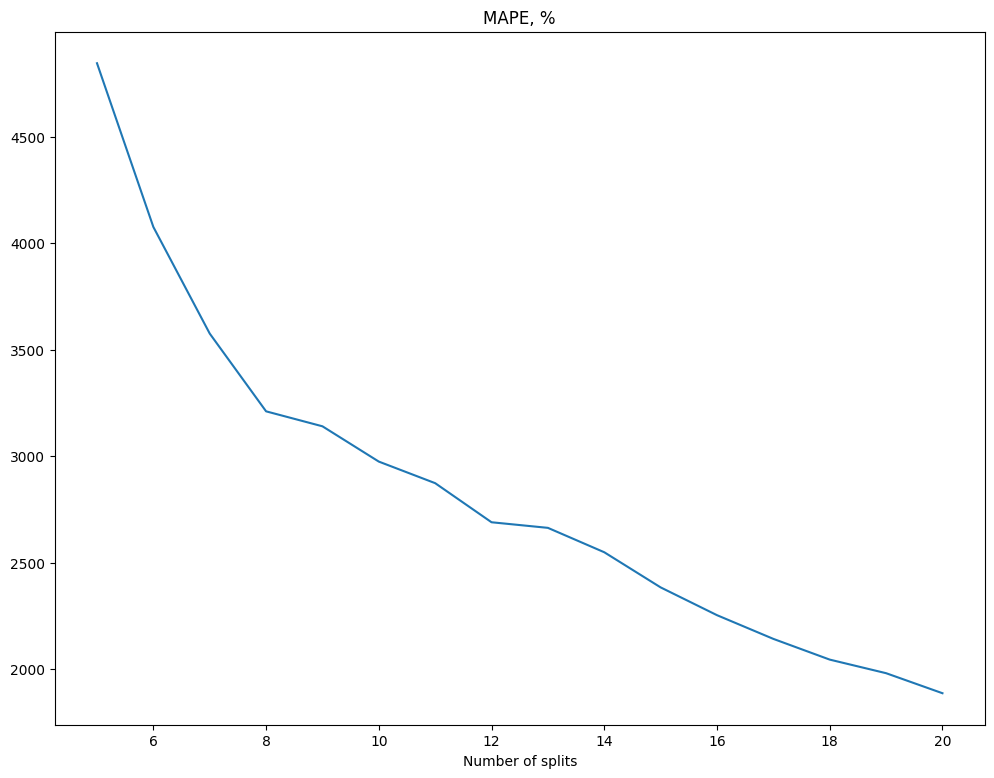

In [325]:
model2_metrics['test'].plot(figsize=(12,9), title="MAPE, %", xlabel='Number of splits')

In [326]:
# Валидация третьей модели (линейная регрессия)
model3_metrics = pd.DataFrame(columns=['train', 'test'], index=list(range(5,21)))
for i in list(range(5,21)):
    model3_metrics['train'][i] = timeseries_validate(df=filled_data["vol"], n_splits=i, model=model3)[0]
    model3_metrics['test'][i] = timeseries_validate(df=filled_data["vol"], n_splits=i, model=model3)[1]

<AxesSubplot: title={'center': 'MAPE, %'}, xlabel='Number of splits'>

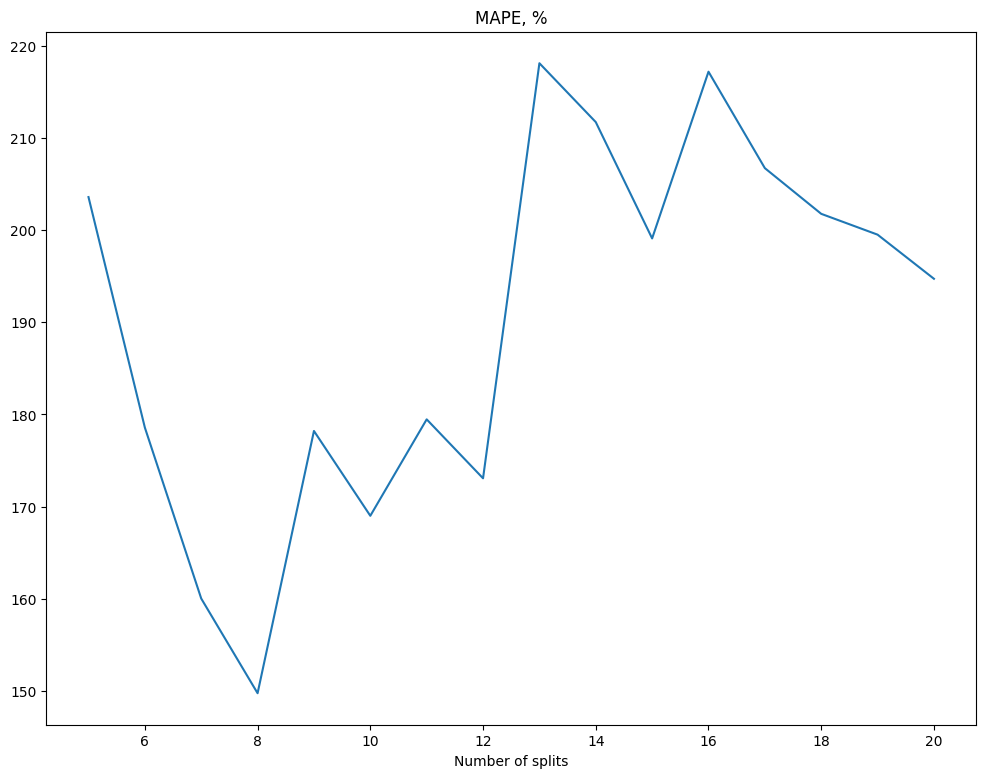

In [327]:
#визуализируем
model3_metrics['test'].plot(figsize=(12,9), title="MAPE, %", xlabel='Number of splits')

### Выводы:
После валидации моделей на графиках видно, что метрика MAPE на тестовых данных в модели линейной регресии в разы ниже, что ещё раз подтверждает что модель GARCH не смогла уловить измненения в волатильности.